This file exists to maximize my understanding on each algorithm flow. :)

In [1]:
import os
import re
import pandas as pd
from scipy import stats
import numpy as np
import random as rd
from tqdm import tqdm

from typing import *
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
import cv2
from imblearn.over_sampling import SMOTE
from sklearn.metrics import  balanced_accuracy_score
from skimage.feature import hog

import seaborn as sns
from scipy.stats import f_oneway, kruskal
import scikit_posthocs as sp

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.inspection import permutation_importance

from scipy.stats import spearmanr, kruskal
import scikit_posthocs as sp

import ast
from time import time
from PIL import Image
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
# No warning, thank you! ^^
import warnings
warnings.filterwarnings('ignore')

def kruskal_walis_test(data: pd.DataFrame, groupby: str, y: str = "F1 Score"):
    '''
    Use only for groupping categorical independent variable
    '''
    groups = [group[y].values for _, group in data.groupby(groupby)]
    stat, p_value = kruskal(*groups)
    significance = "Significant" if p_value < 0.05 else "Not significant"
    result = pd.DataFrame({
        "H-statistic": [stat],
        "p-value": [p_value],
        "Significance": [significance]
    })
    return result


# Ignore this func use costum_dunn_test instead
# def post_hoc_dunn(data, group, val_y):
#     # FML THIS ONLY WORKS FOR TWO TAILED OMFG. JS CHECK ON THE EXCEL INSTEAD OF TS. TS PMO TS PMO. Yeah, defo gonna use the fucking median to determine the ranking later on.

#     unique_values = data[group].unique()
#     group_score = {(unique_values[i]): 0 for i in range(len(unique_values))}
#     dunn_results = sp.posthoc_dunn(data, val_col=val_y, group_col=group, p_adjust='bonferroni')
#     dunn_results = dunn_results.round(5) # Only show with first 5 decimal places

#     # Len of each unique group
#     n_group = [[i, len(data[data[group] == i])] for i in sorted(unique_values)]
#     n_group = pd.DataFrame(n_group, columns=['Group', 'Count'])

#     '''
#     Sort which one actually better. E.g, linier 1 poly 2 and rbf 3 bcz (linier v rbf p < 0.05 then linier v poly p < 0.05) and rbf v poly p > 0.05 
#     also bcz of median f1 score higher on linier > rbf > poly. Yeah. [Mix of actual median and pairwise p-value]. IF win count higher means better rank (1 is best) but if tie, then both get same rank.
#     '''

#     median_f1 = data.groupby(group)[val_y].median().sort_values(ascending=False)

#     # Pairwise test
#     for i in range(len(unique_values)):
#         for j in range(i + 1, len(unique_values)):
#             group1 = unique_values[i]
#             group2 = unique_values[j]

#             p_value = dunn_results[group1][group2]

#             if p_value < 0.05:
#                 if median_f1[group1] > median_f1[group2]:
#                     group_score[group1] += 1
#                 elif median_f1[group1] < median_f1[group2]:
#                     group_score[group2] += 1

#     median_f1 = median_f1.reset_index().rename(columns={val_y: 'Median F1 Score'})

#     group_win = dict(sorted(group_score.items(), key=lambda item: item[1], reverse=True))

#     temp = []

#     current_rank = 1
#     for i, (k, v) in enumerate(group_win.items()):
#         if i > 0 and v < list(group_win.values())[i - 1]:
#             current_rank = i + 1
#         temp.append((k, current_rank))
#     group_ranking = sorted([[k, rank] for k, rank in temp], key=lambda x: x[1])
#     group_ranking = pd.DataFrame(group_ranking, columns=['Group', 'Rank'])

#     print("Post-hoc Dunn's Test Results:")
#     print("Groups' Sample Sizes:")
#     display(n_group)
#     print("P-values:")
#     display(dunn_results)
#     print("Score-based Ranking from Dunn's Test:")
#     display(group_ranking)

def costum_dunn_test(data, group, val_y, tail: Literal['two-sided', 'left', 'right'] = 'right', alpha = 0.05, simple = False):
    '''
    Custom dunn test to fix the issue mentioned above, bcz scipy's implementation only does two tailed AND I FUCKING NEED ONE TAILED PRIMARILY FOR THE RIGHT ONE OMFG
    '''
    data = data[[group, val_y]]
    unique_values = sorted(data[group].unique())
    k = len(unique_values)
    n = len(data)

    # Len of each unique group
    n_group = [[i, len(data[data[group] == i])] for i in sorted(unique_values)]
    n_group = pd.DataFrame(n_group, columns=['Group', 'Count'])

    # Get rank
    data["rank"] = data[val_y].rank(method='average')

    group_mean_rank = data.groupby(group)["rank"].mean()

    # Pairwise comparison
    dunn_z = np.zeros((k, k))
    for i in range(k):
        ni = n_group[n_group['Group'] == unique_values[i]]['Count'].values
        mean_rank_i = group_mean_rank[unique_values[i]]
        for j in range(k):
            if i == j:
                dunn_z[i, j] = 0
            else:
                nj = n_group[n_group['Group'] == unique_values[j]]['Count'].values
                mean_rank_j = group_mean_rank[unique_values[j]]
                z = (mean_rank_i - mean_rank_j) / np.sqrt((n * (n + 1) / 12) * (1/ni + 1/nj))               # FORMULA 53!
                dunn_z[i, j] = np.round(z, 4)

    m = (k-1)*k/2
    adjusted_alpha = alpha / m  # Bonferroni pizza

    if tail == 'two-sided':
        z_table = stats.norm.ppf(adjusted_alpha/2)
        decision = np.abs(dunn_z) > z_table

    elif tail == 'right':
        z_table = stats.norm.ppf(1 - adjusted_alpha)
        decision = dunn_z > z_table

    elif tail == 'left':
        z_table = stats.norm.ppf(adjusted_alpha)
        decision = dunn_z < z_table
    
    decision = np.array(decision, dtype=bool)

    decision = pd.DataFrame(decision, index=unique_values, columns=unique_values)

    score = decision.T.sum()
    score = pd.DataFrame(score, columns=['Score'])
    score = score.reset_index().rename(columns={'index': 'Group'})
    score["rank"] = score['Score'].rank(method='min', ascending=False)

    dunn_z = pd.DataFrame(dunn_z, (unique_values), (unique_values))
    dunn_z[decision == True] = dunn_z[decision == True].astype(str) + '*'

    if simple:
        return score.sort_values(by='rank')
    
    # display(n_group)
    print(f"\nZ-table value: {z_table:.4f}")

    print("\nDunn's Test Z-values:")
    display(dunn_z)

    print("\nScore-based Ranking from Dunn's Test:")
    display(score.sort_values(by='rank'))

    return score.sort_values(by='rank')

# Basic Algorithm Flow and answer to my questions

## One versus one (oVo) vs One versus rest (oVr)

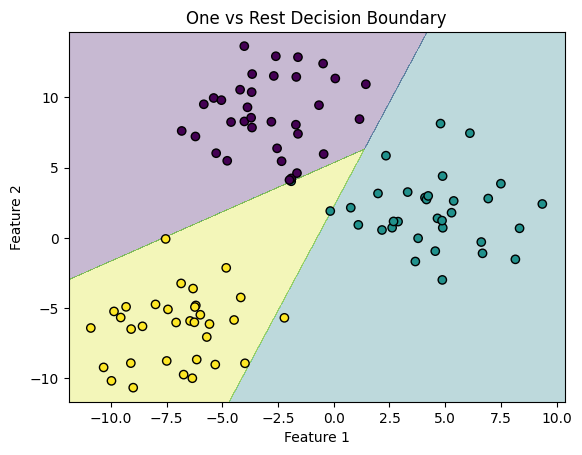

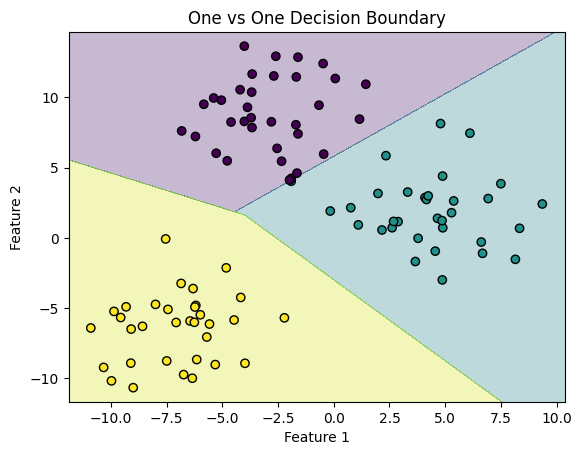

In [13]:
# understanding One versus one and one versus rest classification
'''
IDEA:
1. Generate a synthetic dataset with three classes using `make_blobs`
2. Split the dataset into training and testing sets
3. Train two SVM classifiers: one using One-vs-Rest (OvR) and the other using One-vs-One (OvO)
    strategies with a hard margin (very large C value)
4. Plot the decision boundaries for both classifiers to visualize how they separate the classes
'''

randomState = 42
# STEP 1: -Generate synthetic dataset that can be clearly separated
X, y = datasets.make_blobs(n_samples=100, centers=3, random_state=randomState, cluster_std=2.5)
# STEP 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

# Hard margin SVM (using humongous value of regularization to mimic hard margin)
hard_margin_C = 1e10

# STEP 3: Train One-vs-Rest and One-vs-One classifiers
ovr = OneVsRestClassifier(SVC(kernel='linear', C=hard_margin_C, random_state=randomState))
ovr.fit(X_train, y_train)

ovo = OneVsOneClassifier(SVC(kernel='linear', C=hard_margin_C, random_state=randomState))
ovo.fit(X_train, y_train)


def plot_decision_boundaries(X, y, model, title):
    '''
    This for plot
    '''
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# STEP 4: Plot decision boundaries
plot_decision_boundaries(X, y, ovr, 'One vs Rest Decision Boundary')
plot_decision_boundaries(X, y, ovo, 'One vs One Decision Boundary')

## Histogram of Oriented Gradients (HOG) from scratch

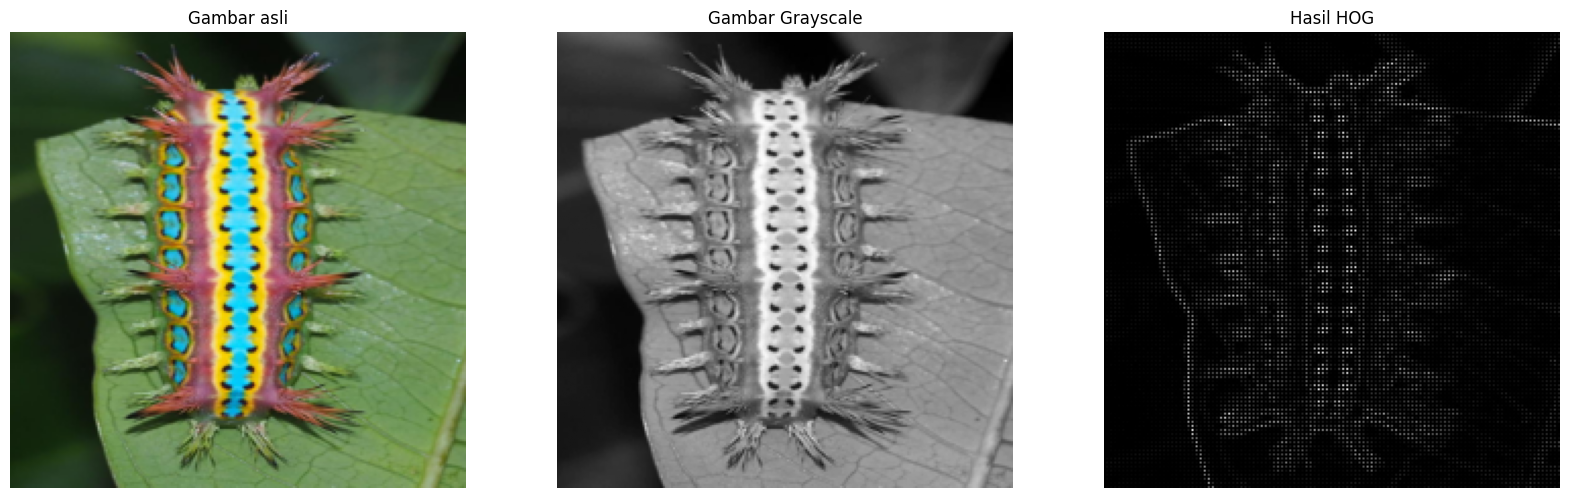

In [10]:
# Comparison of actual HOG vs grayscale vs HOG extracted
x = "../DATA/!FINAL/train_val/Setora_nitens/Setora_nitens-2.jpeg"
image_original = Image.open(x)
image_original = image_original.resize((224, 224))  # Resize to a standard size
image = image_original.convert("L")  # Convert to grayscale

image_array = np.array(image) / 255.0
hog_features, hog_image = hog(
    image_array,
    orientations=9,
    pixels_per_cell=(2, 2),
    cells_per_block=(2,2),
    transform_sqrt=True,
    block_norm='L2-Hys',
    visualize=True
)

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(image_original)
plt.title('Gambar asli')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image, cmap='gray')
plt.title('Gambar Grayscale')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(hog_image, cmap='gray')
plt.title('Hasil HOG')
plt.axis('off')
plt.show()

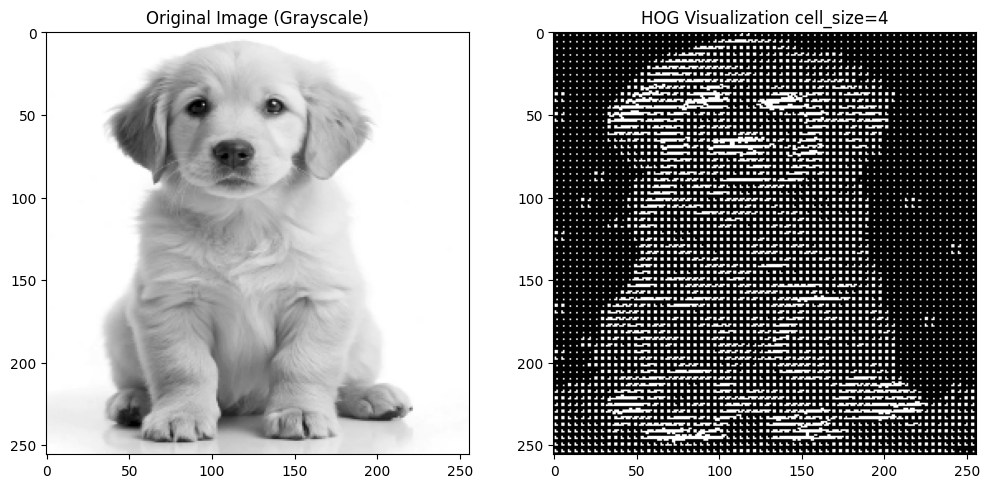

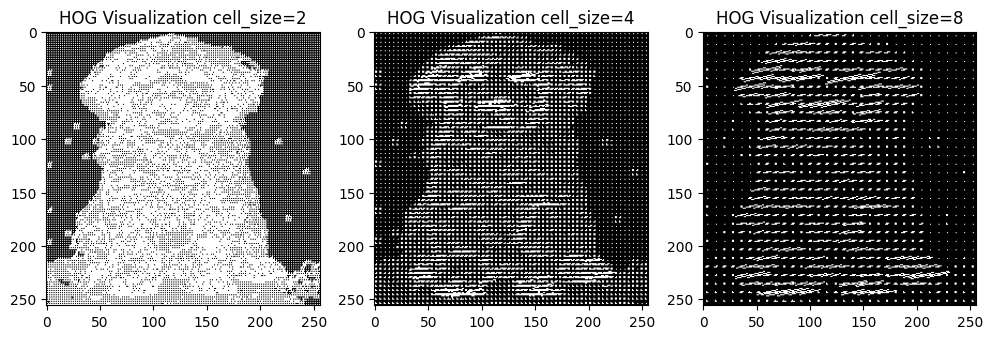

Original Image Shape            : 196608
Original Image Shape Grayscale  : 65536
HOG Vectors Shape (cell_size=2) : 1285956
HOG Vectors Shape (cell_size=4) : 311364
HOG Vectors Shape (cell_size=8) : 72900


In [62]:
# Understanding HOG algorithm

'''
My idea of the procedure!:
1. Generate a random grayscale image which has been normalized (2D numpy array)
2. Compute gradients of X and Y (Formula 21 & 22)
3. Compute magnitude and orientation of gradients (Formula 23 & 24)
4. Divide the image into cells (n x n pixels)
5. For each cell, create a histogram of gradient orientations (9 bins for 0-180 degrees)
6. Create lines for visualizing HOG features based on histogram values of each cell
7. Group cells into blocks (m x m cells) for normalization
8. Normalize histograms over blocks (m x m cells)
9. Concatenate all normalized histograms to form the final HOG feature vector
'''

def compute_hog(image, cell_size=8, block_size=2, nbins=9):
    
    # Get image dimensions
    height, width = image.shape
    # Return matrices, used for visualizing HOG features later
    hog_image = np.zeros_like(image, dtype=np.float32)

    # STEP 1: Compute gradients using finite difference (Formula 21 & 22)
    # Applies zero padding to handle borders. So there'll be value in the border.
    grad_x = np.zeros_like(image, dtype=np.float32)
    grad_y = np.zeros_like(image, dtype=np.float32)
    # Compute gradients of X and Y. Only compute the real valur of the image, not the border.
    for i in range(1, height-1):
        for j in range(1, width-1):
            grad_x[i, j] = image[i, j+1] - image[i, j-1]    # G_h(i,j)
            grad_y[i, j] = image[i+1, j] - image[i-1, j]    # G_v(i,j)
    
    # STEP 2: Compute magnitude and orientation of gradients (Formula 23 & 24)
    magnitude = np.sqrt(grad_x**2 + grad_y**2)              # G(i,j)
    orientation = np.arctan2(grad_y, grad_x) % 180          # φ(i,j)

    # STEP 3: Divide the image into cells (n x n pixels)
    cells_x = width // cell_size
    cells_y = height // cell_size
    hist_bins = np.linspace(0, 180, nbins+1)[:-1]                           # bin centers: [0, 20, 40, ..., 160]
    histograms = np.zeros((cells_y, cells_x, nbins), dtype=np.float32)      # This will store histograms for each cell. Shape: (cells_y, cells_x, nbins)
    # STEP 4: Initialize histogram for each cell
    for i in range(cells_y):
        for j in range(cells_x):

            # Get cell magnitude and orientation
            cell_magnitude = magnitude[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
            cell_orientation = orientation[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
            
            # STEP 5: Populate histogram for the cell with bilinear interpolation
            for m in range(cell_size):
                for n in range(cell_size):
                    mag = cell_magnitude[m, n]
                    ori = cell_orientation[m, n]
                    
                    # find the two nearest bins
                    bin_idx = int(ori // 20)
                    if bin_idx >= nbins:
                        bin_idx = nbins - 1
                    
                    b1 = hist_bins[min(bin_idx, nbins-1)]
                    b2 = hist_bins[min(bin_idx+1, nbins-1)] if bin_idx < nbins-1 else hist_bins[0]
                    
                    # if exactly on a bin
                    if abs(ori - b1) < 1e-6:
                        histograms[i, j, bin_idx] += mag
                    else:
                        # Bilinear interpolation
                        w1 = (b2 - ori) / 20 * mag  # formula 25
                        w2 = (ori - b1) / 20 * mag  # formula 26
                        
                        histograms[i, j, bin_idx] += w1
                        if bin_idx < nbins-1:
                            histograms[i, j, bin_idx+1] += w2
                        else:
                            histograms[i, j, 0] += w2

    # These syntax below are used for visualizing HOG features. I guess
    for i in range(cells_y):
        for j in range(cells_x):
            cell_hist = histograms[i, j]
            cell_center = (j * cell_size + cell_size // 2, i * cell_size + cell_size // 2)

            # Draw lines for each bin in the histogram depending on its magnitude, angle, and length
            for b in range(nbins):
                angle = hist_bins[b]
                length = cell_hist[b] / (np.max(histograms) + 1e-6) * cell_size / 2
                # Get line start and end points based on angle and length
                x1 = int(cell_center[0] - length * np.cos(angle))
                y1 = int(cell_center[1] - length * np.sin(angle))
                x2 = int(cell_center[0] + length * np.cos(angle))
                y2 = int(cell_center[1] + length * np.sin(angle))

                cv2.line(hog_image, (x1, y1), (x2, y2), 255, 1, cv2.LINE_AA)



    # STEP 6: Normalize histograms over blocks (m x m cells)
    blocks_x = cells_x - block_size + 1                         # stride 1, sliding window method
    blocks_y = cells_y - block_size + 1
    epsilon = 1e-6
    
    hog_features = []
    
    for i in range(blocks_y):
        for j in range(blocks_x):
            # Get histogram from block (m x m cells)
            block_hist = histograms[i:i+block_size, j:j+block_size, :].ravel()

            # L2-Normalization (Formula 27)
            norm = np.sqrt(np.sum(block_hist**2) + epsilon**2)
            block_hist_normalized = block_hist / norm
            
            hog_features.append(block_hist_normalized)

    hog_vectors = np.concatenate(hog_features)

    return hog_image, hog_vectors


def fetch_image(height=64, width=128):

    # Get image from directory
    image = cv2.imread('test.png', cv2.IMREAD_GRAYSCALE)

    # Normalize by rescaling it to 0-255 and convert to float
    image = cv2.resize(image, (width, height))
    image = image.astype(np.float32) / 255.0 * 255.0
    image = image.reshape(height, width).astype(np.float32)

    return image

random_image = fetch_image(height=256, width=256)
hog_image, hog_vectors = compute_hog(random_image, cell_size=4, block_size=3, nbins=9)


# Compare original image and HOG visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image (Grayscale)')
plt.imshow(random_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('HOG Visualization cell_size=4')
plt.imshow(hog_image, cmap='gray')
plt.show()


# Another with difference cell_size
hog_image_2, hog_vectors_2 = compute_hog(random_image, cell_size=8, block_size=3, nbins=9)
hog_image_3 , hog_vectors_3 = compute_hog(random_image, cell_size=2, block_size=3, nbins=9)
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('HOG Visualization cell_size=2')
plt.imshow(hog_image_3, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('HOG Visualization cell_size=4')
plt.imshow(hog_image, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('HOG Visualization cell_size=8')
plt.imshow(hog_image_2, cmap='gray')
plt.show()

# Shape of each image
print(f'Original Image Shape            : {random_image.shape[0] * random_image.shape[1] * 3}')
print(f'Original Image Shape Grayscale  : {random_image.shape[0] * random_image.shape[1] }')
print(f'HOG Vectors Shape (cell_size=2) : {hog_vectors_3.shape[0]}')
print(f'HOG Vectors Shape (cell_size=4) : {hog_vectors.shape[0]}')
print(f'HOG Vectors Shape (cell_size=8) : {hog_vectors_2.shape[0]}')

In [64]:
image =  cv2.imread('test.png', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (256, 256))
image_array = np.array(image) / 255.0
hog_features = hog(
    image_array,
    pixels_per_cell=(4,4),
    cells_per_block=(3,3),
    transform_sqrt=True,
    block_norm='L2-Hys'
)

print(f'Skimage HOG feature vector shape: {hog_features.shape}') # Should be similar to custom HOG with cell_size=4 if not then there's something wong wong wong wong wong xd

Skimage HOG feature vector shape: (311364,)


## Imbalanced technique 
(Combination of oversamling [augmentation] and undersampling). Aswell as Evaluation metrics used (Balanced accuracy, macro average F1-Score)

In [4]:
def get_metrics(model, X, y_true, class_labels, wantmetoreturn = False, displayoutput = True):
    '''
    the IDK
    '''
    y_pred = model.predict(X).astype(int)
    y_true = np.array(y_true)

    returnClassmetrics = {}
    for index, class_name in enumerate(class_labels):
        # Get true positives, false positives, and false negatives
        tp = sum((y_true == index) & (y_pred == index))
        fp = sum((y_true != index) & (y_pred == index))
        fn = sum((y_true == index) & (y_pred != index))

        class_precision = tp / (tp + fp) if (tp + fp) > 0 else 0    # Precision = TP / (TP + FP)
        class_recall = tp / (tp + fn) if (tp + fn) > 0 else 0       # Recall = TP / (TP + FN)
        class_f1 = 2 * class_precision * class_recall / (class_precision + class_recall) if (class_precision + class_recall) > 0 else 0 # F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

        returnClassmetrics[class_name] = {
            'True Positives': int(tp),
            "False Positives": int(fp),
            "False Negatives": int(fn),
            'Precision': round(class_precision,4),
            'Recall': round(class_recall, 4),
            'F1 Score': round(class_f1,4)
        }
    
    # Calculate overall metrics (macro averaged)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    overal_precision = np.mean([metrics['Precision'] for metrics in returnClassmetrics.values()])
    overall_recall = np.mean([metrics['Recall'] for metrics in returnClassmetrics.values()])
    overall_f1_score = np.mean([metrics['F1 Score'] for metrics in returnClassmetrics.values()])

    result = { 
        "Balanced Accuracy": round(balanced_accuracy, 4),
        "Precision": round(overal_precision, 4), 
        "Recall": round(overall_recall, 4), 
        "F1 Score": round(overall_f1_score, 4), 
        "Class Metrics": returnClassmetrics
        } 
    
    # Create a main DataFrame with overall metrics
    overall_metrics = {k: [v] for k, v in result.items() if k != "Class Metrics"}
    overall_df = pd.DataFrame(overall_metrics)

    # Create a DataFrame for class-specific metrics
    class_metrics = result["Class Metrics"]
    class_df = pd.DataFrame.from_dict(class_metrics, orient='index').sort_index()

    if displayoutput:
        print("Overall Metrics:")
        display(overall_df)
        print("\nClass-Specific Metrics:")
        display(class_df)

    if wantmetoreturn:        
        return result

In [ ]:
# Understanding the metrics used in the thesis

state = rd.randint(1, 9999)
np.random.seed(state)

# Generate data that can be separated linearly, 3 classes with shitty ass imbalanced problems
X, y = datasets.make_blobs(n_samples=[1200, 150, 100], n_features=4096, cluster_std=100, random_state=state)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=state)

# Len of train and test dataset of each class
for i in range(len(np.unique(y))):
    print(f'Class {i} Train samples: {len(y_train[y_train==i])} | Class {i} Test samples: {len(y_test[y_test==i])}')


# Handle class imbalance, mix of oversampling and undersampling
target_sampling = 200
print(f'Target sampling: {target_sampling}')

# undersampling (majority classes above target_sampling will be set to target_sampling)
X_train_resampled, y_train_resampled = X_train.copy(), y_train.copy()
for i in range(len(np.unique(y))):
    if len(y_train[y_train==i]) > target_sampling:
        indexs = np.where(y_train_resampled == i)[0]
        chosen_index = np.random.choice(indexs, len(y_train[y_train==i]) - target_sampling, replace=False)  
        X_train_resampled = np.delete(X_train_resampled, chosen_index, axis=0)
        y_train_resampled = np.delete(y_train_resampled, chosen_index, axis=0)

# Use smote, bcz it's the most similiar thing to image augmentation.
smote = SMOTE(sampling_strategy="not majority", random_state=state)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

# Len of resampled train dataset of each class
for i in range(len(np.unique(y))):
    print(f'Class {i} Resampled Train samples: {len(y_train_resampled[y_train_resampled==i])}')

# Comparison of SVM on original vs resampled data
model_original = SVC(kernel='linear', random_state=state)
model_original.fit(X_train, y_train)

model_resampled = SVC(kernel='linear', random_state=state)
model_resampled.fit(X_train_resampled, y_train_resampled)

y_test_original_pred = model_original.predict(X_test)
y_test_resampled_pred = model_resampled.predict(X_test)

# Compute metrics for original and resampled models
print("\nMetrics for Original Model:")
get_metrics(model_original, X_test, y_test, class_labels=[0,1,2], wantmetoreturn=False)
print("\nMetrics for Resampled Model:")
get_metrics(model_resampled, X_test, y_test, class_labels=[0,1,2], wantmetoreturn=False)

# Resampled shows better performance on minority class (class 2) while maintaining similar performance on majority class (class 0)


Class 0 Train samples: 838 | Class 0 Test samples: 362
Class 1 Train samples: 103 | Class 1 Test samples: 47
Class 2 Train samples: 74 | Class 2 Test samples: 26
Target sampling: 200
Class 0 Resampled Train samples: 200
Class 1 Resampled Train samples: 200
Class 2 Resampled Train samples: 200

Metrics for Original Model:
Overall Metrics:


Balanced Accuracy  Precision  Recall  F1 Score
0              0.518     0.9588   0.518     0.596


Class-Specific Metrics:


True Positives  False Positives  False Negatives  Precision  Recall  \
0             362               51                0     0.8765  1.0000   
1              17                0               30     1.0000  0.3617   
2               5                0               21     1.0000  0.1923   

   F1 Score  
0    0.9342  
1    0.5312  
2    0.3226


Metrics for Resampled Model:
Overall Metrics:


Balanced Accuracy  Precision  Recall  F1 Score
0             0.6825     0.9111  0.6825    0.7541


Class-Specific Metrics:


True Positives  False Positives  False Negatives  Precision  Recall  \
0             357               30                5     0.9225  0.9862   
1              30                7               17     0.8108  0.6383   
2              11                0               15     1.0000  0.4231   

   F1 Score  
0    0.9533  
1    0.7143  
2    0.5946

In [ ]:
# Simulation for 100 runs (Anjay MSR). Don't run this agen yest? xd

thenormal = []
resampled = []

for i in tqdm(range(100)):
    state = rd.randint(0, 10000)
    np.random.seed(state)

    # Generate data that doesn't look like it can be separated linearly, 3 classes with shitty ass imbalanced problems and high dimension
    X, y = datasets.make_blobs(n_samples=[1200, 150, 100], n_features=4096, cluster_std=100, random_state=state)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=state)

    # Handle class imbalance, mix of oversampling and undersampling
    target_sampling = 400

    # undersampling (majority classes above target_sampling will be set to target_sampling)
    X_train_resampled, y_train_resampled = X_train.copy(), y_train.copy()
    for i in range(len(np.unique(y))):
        if len(y_train[y_train==i]) > target_sampling:
            indexs = np.where(y_train_resampled == i)[0]
            chosen_index = np.random.choice(indexs, len(y_train[y_train==i]) - target_sampling, replace=False)  
            X_train_resampled = np.delete(X_train_resampled, chosen_index, axis=0)
            y_train_resampled = np.delete(y_train_resampled, chosen_index, axis=0)

    # Use smote, bcz it's the most similiar thing to image augmentation.
    smote = SMOTE(sampling_strategy="not majority", random_state=state)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

    # Comparison of SVM on original vs resampled data
    model_original = SVC(kernel='linear', random_state=state)
    model_original.fit(X_train, y_train)

    model_resampled = SVC(kernel='linear', random_state=state)
    model_resampled.fit(X_train_resampled, y_train_resampled)

    y_test_original_pred = model_original.predict(X_test)
    y_test_resampled_pred = model_resampled.predict(X_test)

    # Compute metrics for original and resampled models
    thenormal.append(get_metrics(model_original, X_test, y_test, class_labels=[0,1,2], wantmetoreturn=True, displayoutput=False))
    resampled.append(get_metrics(model_resampled, X_test, y_test, class_labels=[0,1,2], wantmetoreturn=True, displayoutput=False))

thenormal = [thenormal[i]["F1 Score"] for i in range(len(thenormal))]
resampled = [resampled[i]["F1 Score"] for i in range(len(resampled))]

df_results = pd.DataFrame({
    "Normal": thenormal,
    "Resampled": resampled
})

df_melted = df_results.melt(var_name='Method', value_name='F1 Score')
print("Kruskal-Walis Test Results:")
display(kruskal_walis_test(df_melted, groupby='Method', y='F1 Score'))
print("\nPost-hoc Dunn's Test Results:")
costum_dunn_test(df_melted, group='Method', val_y='F1 Score', tail='right', alpha=0.05)

100%|██████████| 100/100 [07:43<00:00,  4.64s/it]

Kruskal-Walis Test Results:


H-statistic       p-value Significance
0    99.552521  1.910296e-23  Significant


Post-hoc Dunn's Test Results:


C:\Users\Rhey PC\AppData\Local\Temp\ipykernel_23716\3306275036.py:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dunn_z[i, j] = z


Group  Count
0     Normal    100
1  Resampled    100


Dunn's Test Z-values:


Normal  Resampled
Normal     0.000000  -9.977579
Resampled  9.977579   0.000000


Adjusted alpha (Bonferroni) for right tail: 0.05000, Z-table value: 1.6449

Decision Matrix (True indicates significant difference):


Normal  Resampled
Normal      False      False
Resampled    True      False


Score-based Ranking from Dunn's Test:


Group  Score  rank
1  Resampled      1   1.0
0     Normal      0   2.0

## Tree structured parzen estimator (TPE)

In [5]:
# Understanding TPE

'''
IDFK LMAO :SOB:
1. Generate synthetic linear data with noise (y = mx + b + noise)
2. Uses RMSE as the objective function to minimize
3. minimize M and b using TPE optimization
'''

# Stuff imma use. Minimize RMSE with linier model y = mx + b.
# WITH THE TASK OF MINIMIZING THE Weight (M) AND BIAS (B)

# Metric used as the objective function
def rmse(m, b):
    y_pred = m*x + b
    return np.sqrt(np.mean((y - y_pred)**2))

# Generate synthetic linear datae
x = np.linspace(0, 100, 1000)
real_m = np.random.randint(0, 100)
real_b = np.random.randint(-5000, 5000)
y = real_m*x + real_b + np.random.randn(1000)*700 # Yeah add noise to make it difficult, i guess


# TPE optimization with tracking good and bad samples
def fit_kde(values):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(np.array(values).reshape(-1, 1))
    return kde


def tpe_optimization_with_tracking(objective,
                                   what_to_do: Literal["maximize", "minimize"],
                                   search_space,
                                   n_iterations=200,
                                   n_initial_points=20,
                                   threshold=0.2):
    
    # 1. Random initialization
    samples = []
    for _ in range(n_initial_points):
        sample = {key: np.random.uniform(low, high) for key, (low, high) in search_space.items()}
        score = objective(**sample)
        samples.append((sample, score))

    remaining_samples = n_iterations - n_initial_points

    # 2. Main optimization loop
    for _ in range(remaining_samples):
        scores = [s[1] for s in samples]
        # Quantile threshold (different for minimize/maximize)
        objective_threshold = np.quantile(scores, threshold if what_to_do == "minimize" else 1 - threshold)     # If minimize, lower is better. If maximize, higher is better so get the 1-threshold percentile.

        # Split into good and bad sets
        good_samples = [s for s in samples if (s[1] <= objective_threshold if what_to_do == "minimize" else s[1] >= objective_threshold)]
        bad_samples = [s for s in samples if (s[1] > objective_threshold if what_to_do == "minimize" else s[1] < objective_threshold)]

        # Extract values per parameter
        good_params = {key: [s[0][key] for s in good_samples] for key in search_space.keys()}
        bad_params = {key: [s[0][key] for s in bad_samples] for key in search_space.keys()}

        # Fit KDEs
        good_dists = {key: fit_kde(vals) for key, vals in good_params.items()}
        bad_dists = {key: fit_kde(vals) for key, vals in bad_params.items()}

        # 3. Propose new candidate maximizing l(x)/g(x)
        new_sample = {}
        for key in search_space.keys():
            best_ratio = -np.inf
            best_value = None
            for _ in range(100):  # sample 100 candidates
                candidate = np.random.uniform(*search_space[key])
                p_good = np.exp(good_dists[key].score_samples([[candidate]]))
                p_bad = np.exp(bad_dists[key].score_samples([[candidate]]))
                ratio = p_good / (p_bad + 1e-6)
                if ratio > best_ratio:
                    best_ratio = ratio
                    best_value = candidate
                    
            new_sample[key] = best_value

        # Evaluate new candidate
        new_score = objective(**new_sample)
        samples.append((new_sample, new_score))

    # 4. Final evaluation
    scores = [s[1] for s in samples]
    objective_threshold = np.quantile(scores, threshold if what_to_do == "minimize" else 1 - threshold)

    good_samples = [s for s in samples if (s[1] <= objective_threshold if what_to_do == "minimize" else s[1] >= objective_threshold)]
    bad_samples = [s for s in samples if (s[1] > objective_threshold if what_to_do == "minimize" else s[1] < objective_threshold)]

    # Pick best result
    if what_to_do == "minimize":
        best_sample, best_score = min(samples, key=lambda s: s[1])
        print(f'Best Trial: {samples.index((best_sample, best_score))+1}')
    else:
        best_sample, best_score = max(samples, key=lambda s: s[1])
        print(f'Best Trial: {samples.index((best_sample, best_score))+1}')

    print("\n=== BEST RESULT ===")
    print(f"Best m = {best_sample['m']:.4f}")
    print(f"Best b = {best_sample['b']:.4f}")
    print(f"RMSE   = {best_score:.4f}")
    print(f"Good samples: {len(good_samples)}, Bad samples: {len(bad_samples)}")

    return best_sample, best_score, good_samples, bad_samples, samples

# Hyperparameter search space
search_space = {
    'm': (0, 100),        # slope
    'b': (-5000, 5000)   # intercept
}

# Run optimization
best_params, best_score, good_samples, bad_samples, all_samples = tpe_optimization_with_tracking(
    rmse, "minimize", search_space, n_iterations=200, n_initial_points=20
)

Best Trial: 179

=== BEST RESULT ===
Best m = 73.2352
Best b = -4222.0276
RMSE   = 709.7208
Good samples: 40, Bad samples: 160


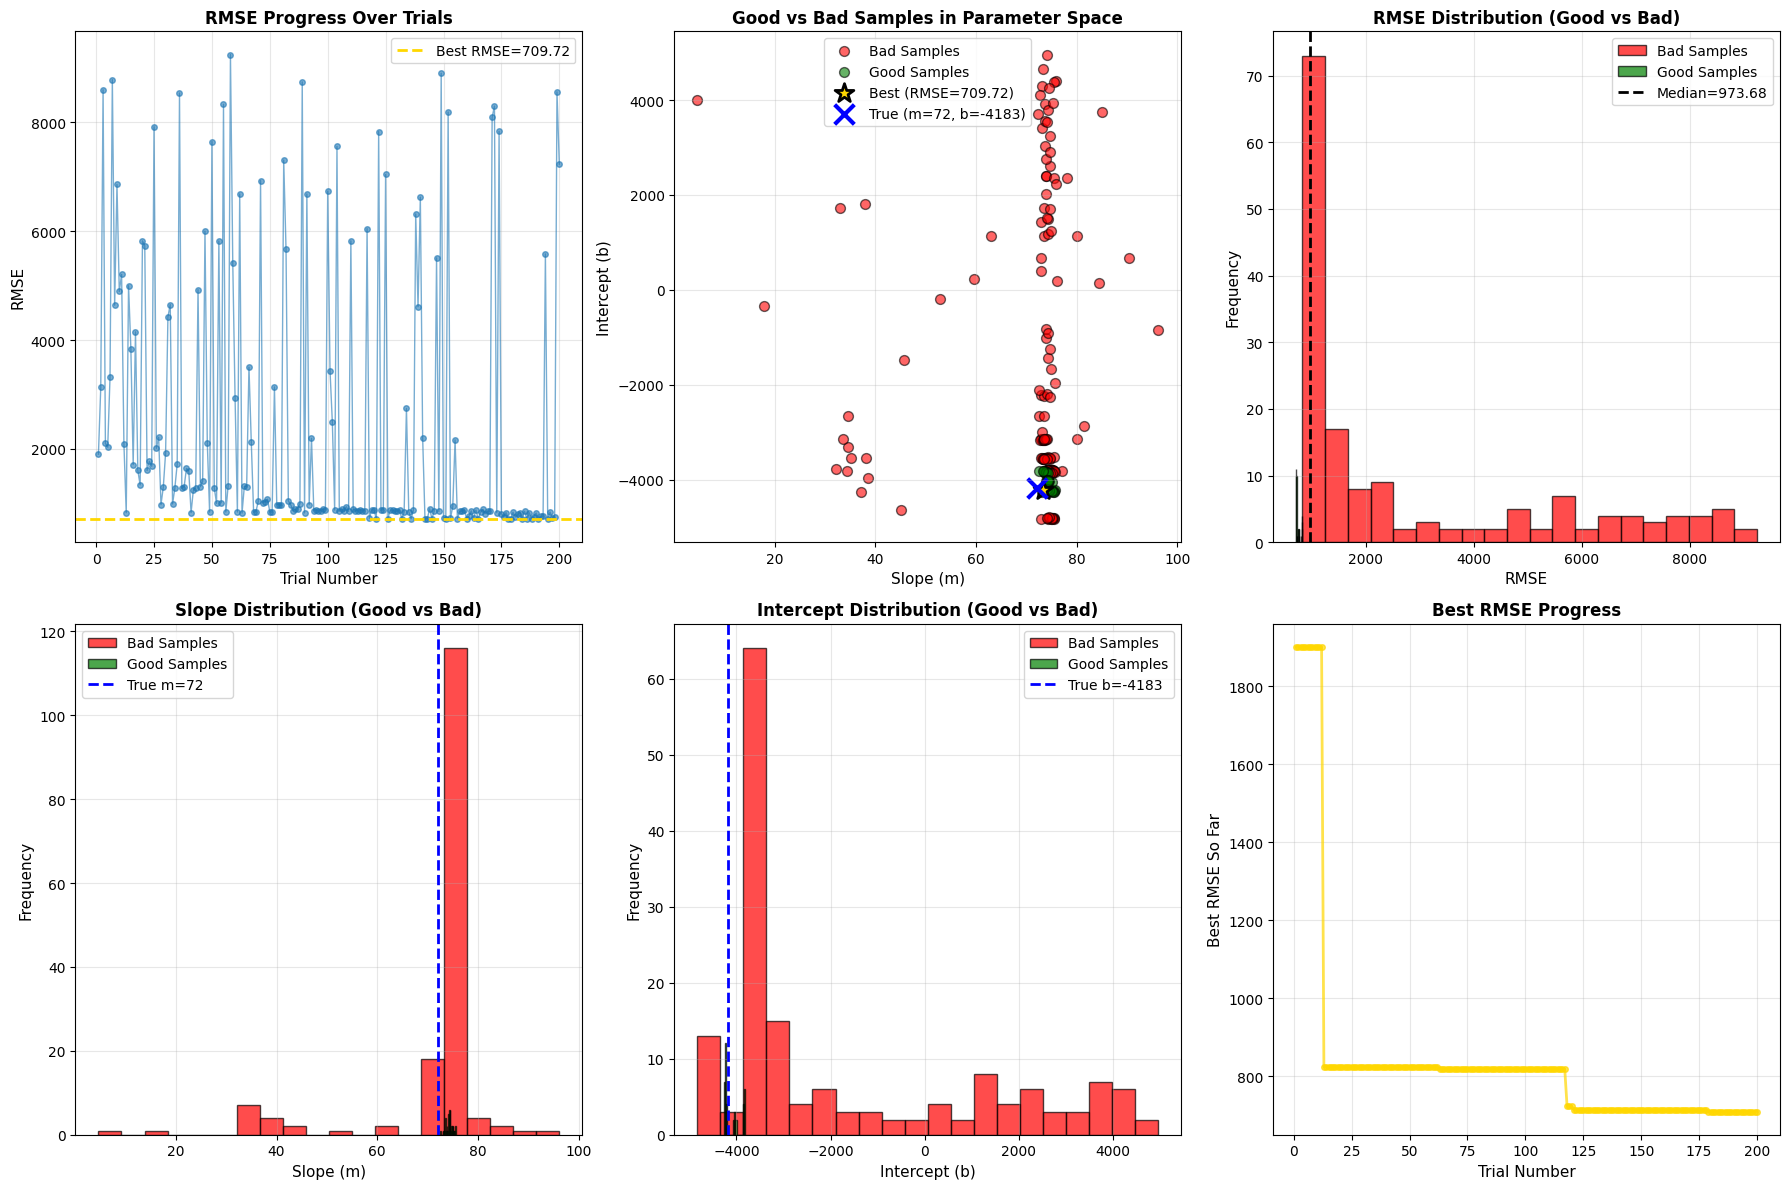

good Samples
Count: 40
Mean RMSE: 748.4922
Mean m: 74.2684 (True: 72)
Mean b: -4099.3867 (True: -4183)

Bad Samples
Count: 160
Mean RMSE: 2814.9313
Mean m: 70.6453 (True: 72)
Mean b: -1769.2361 (True: -4183)


In [6]:
all_rmse = [s[1] for s in all_samples]

# Coordinates things
good_m = [s[0]['m'] for s in good_samples]
good_b = [s[0]['b'] for s in good_samples]
good_scores = [s[1] for s in good_samples]

bad_m = [s[0]['m'] for s in bad_samples]
bad_b = [s[0]['b'] for s in bad_samples]
bad_scores = [s[1] for s in bad_samples]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: RMSE all trials
axes[0, 0].plot(range(1, len(all_rmse) + 1), all_rmse, 'o-', alpha=0.6, markersize=4, linewidth=1)
axes[0, 0].axhline(y=best_score, color='gold', linestyle='--', linewidth=2, label=f'Best RMSE={best_score:.2f}')
axes[0, 0].set_xlabel('Trial Number', fontsize=11)
axes[0, 0].set_ylabel('RMSE', fontsize=11)
axes[0, 0].set_title('RMSE Progress Over Trials', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Scatter of good vs bad samples
axes[0, 1].scatter(bad_m, bad_b, c='red', alpha=0.6, s=50, label='Bad Samples', edgecolors='black')
axes[0, 1].scatter(good_m, good_b, c='green', alpha=0.6, s=50, label='Good Samples', edgecolors='black')
axes[0, 1].scatter(best_params['m'], best_params['b'], c='gold', s=200, marker='*', 
                   label=f'Best (RMSE={best_score:.2f})', edgecolors='black', linewidths=2)
axes[0, 1].scatter(real_m, real_b, c='blue', s=200, marker='x', label=f'True (m={real_m}, b={real_b})', linewidths=3)
axes[0, 1].set_xlabel('Slope (m)', fontsize=11)
axes[0, 1].set_ylabel('Intercept (b)', fontsize=11)
axes[0, 1].set_title('Good vs Bad Samples in Parameter Space', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: RMSE distribution
axes[0, 2].hist(bad_scores, bins=20, alpha=0.7, color='red', label='Bad Samples', edgecolor='black')
axes[0, 2].hist(good_scores, bins=20, alpha=0.7, color='green', label='Good Samples', edgecolor='black')
axes[0, 2].axvline(np.median(good_scores + bad_scores), color='black', linestyle='--', 
                   linewidth=2, label=f'Median={np.median(good_scores + bad_scores):.2f}')
axes[0, 2].set_xlabel('RMSE', fontsize=11)
axes[0, 2].set_ylabel('Frequency', fontsize=11)
axes[0, 2].set_title('RMSE Distribution (Good vs Bad)', fontsize=12, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: m parameter distribution
axes[1, 0].hist(bad_m, bins=20, alpha=0.7, color='red', label='Bad Samples', edgecolor='black')
axes[1, 0].hist(good_m, bins=20, alpha=0.7, color='green', label='Good Samples', edgecolor='black')
axes[1, 0].axvline(real_m, color='blue', linestyle='--', linewidth=2, label=f'True m={real_m}')
axes[1, 0].set_xlabel('Slope (m)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Slope Distribution (Good vs Bad)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: b parameter distribution
axes[1, 1].hist(bad_b, bins=20, alpha=0.7, color='red', label='Bad Samples', edgecolor='black')
axes[1, 1].hist(good_b, bins=20, alpha=0.7, color='green', label='Good Samples', edgecolor='black')
axes[1, 1].axvline(real_b, color='blue', linestyle='--', linewidth=2, label=f'True b={real_b}')
axes[1, 1].set_xlabel('Intercept (b)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Intercept Distribution (Good vs Bad)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Best RMSE progress
best_so_far = [min(all_rmse[:i+1]) for i in range(len(all_rmse))]
axes[1, 2].plot(range(1, len(best_so_far) + 1), best_so_far, 'o-', color='gold', 
                alpha=0.7, markersize=4, linewidth=2)
axes[1, 2].set_xlabel('Trial Number', fontsize=11)
axes[1, 2].set_ylabel('Best RMSE So Far', fontsize=11)
axes[1, 2].set_title('Best RMSE Progress', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("good Samples")
print(f"Count: {len(good_samples)}")
print(f"Mean RMSE: {np.mean(good_scores):.4f}")
print(f"Mean m: {np.mean(good_m):.4f} (True: {real_m})")
print(f"Mean b: {np.mean(good_b):.4f} (True: {real_b})")

print("\nBad Samples")
print(f"Count: {len(bad_samples)}")
print(f"Mean RMSE: {np.mean(bad_scores):.4f}")
print(f"Mean m: {np.mean(bad_m):.4f} (True: {real_m})")
print(f"Mean b: {np.mean(bad_b):.4f} (True: {real_b})")

### Said TPE objective distribution

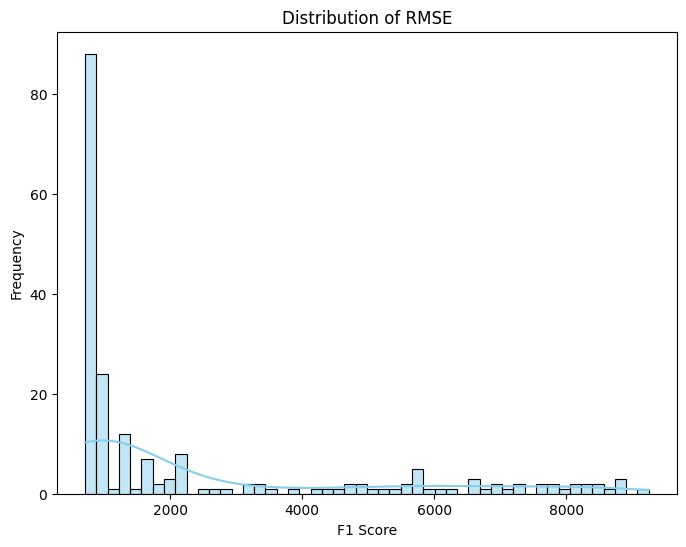

H0: The data is normally distributed
H1: The data is not normally distributed

Shapiro-Wilk Test: Statistics=0.6920, p-value=0.0000
Reject H0


In [7]:
# Example why parametric test is not suitable

# F1 Score distribution
plt.figure(figsize=(8,6))
sns.histplot(all_rmse, bins=50, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of RMSE")
plt.xlabel("F1 Score")
plt.ylabel("Frequency")
plt.show()

# Normality test using Shapiro-Wilk test
stat, p_value = stats.shapiro(all_rmse)

print("H0: The data is normally distributed")
print("H1: The data is not normally distributed")

print(f'\nShapiro-Wilk Test: Statistics={stat:.4f}, p-value={p_value:.4f}')
print("Reject H0" if p_value < 0.05 else "Fail to Reject H0")

# Tbfh this doesn't look normal at all jeez.

## Pooling

Time taken for convolution and max pooling: 1.162162 seconds
Time taken for convolution and average pooling: 1.191463 seconds


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

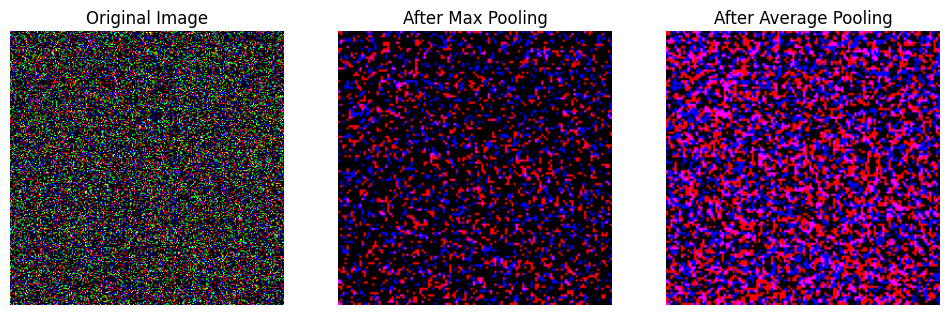

In [67]:
## Understanding Convolutional layer with pooling layers (maxpool, avgpool)                    # (1, 512, 512, 3)

def max_pooling(image, pool_size=2, stride=2):
    output_height = (image.shape[0] - pool_size) // stride + 1
    output_width = (image.shape[1] - pool_size) // stride + 1
    output = np.zeros((output_height, output_width, image.shape[2]))

    for y in range(0, output_height):
        for x in range(0, output_width):
            for c in range(image.shape[2]):
                region = image[y*stride:y*stride+pool_size, x*stride:x*stride+pool_size, c]
                output[y, x, c] = np.max(region)
    
    return output

def avg_pooling(image, pool_size=2, stride=2):
    output_height = (image.shape[0] - pool_size) // stride + 1
    output_width = (image.shape[1] - pool_size) // stride + 1
    output = np.zeros((output_height, output_width, image.shape[2]))

    for y in range(output_height):
        for x in range(output_width):
            for c in range(image.shape[2]):
                region = image[y*stride:y*stride+pool_size, x*stride:x*stride+pool_size, c]
                output[y, x, c] = np.mean(region)
    
    return output

# Convolution operation (3x3 filter with stride 1 and padding 1)
def conv2d_pooling(image, kernel, stride=1, padding=1, pooling_type='max', pool_size=2, pool_stride=2):
    # Add padding to the image
    image_padded = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='constant')
    kernel_height, kernel_width, _ = kernel.shape
    output_height = (image.shape[0] - kernel_height + 2 * padding) // stride + 1
    output_width = (image.shape[1] - kernel_width + 2 * padding) // stride + 1
    output = np.zeros((output_height, output_width, image.shape[2]))

    for y in range(output_height):
        for x in range(output_width):
            for c in range(image.shape[2]):
                region = image_padded[y*stride:y*stride+kernel_height, x*stride:x*stride+kernel_width, c]
                output[y, x, c] = np.sum(region * kernel[:, :, c])
    
    if pooling_type == 'max':
        output = max_pooling(output, pool_size, pool_stride)
    elif pooling_type == 'avg':
        output = avg_pooling(output, pool_size, pool_stride)
    
    return output

# Example usage of the conv2d_pooling function
X, _ = datasets.make_classification(n_samples=1, n_features=256*256*3)

X = X.reshape(1, 256, 256, 3)         # Say we have 1 image of 256x256 with 3 channels (RGB)
image = X[0]                          # (256, 256, 3)

# Define a simple 3x3 filter (kernel) for convolution
kernel = np.array([[[1, 0, -1], [1, 0, -1], [1, 0, -1]],
                   [[1, 0, -1], [1, 0, -1], [1, 0, -1]],
                   [[1, 0, -1], [1, 0, -1], [1, 0, -1]]])  # Shape (3, 3, 3)

# Apply convolution followed by max pooling
time_start = time()
output_maxpool = conv2d_pooling(image, kernel, pooling_type='max', pool_size=2, pool_stride=2)
time_end = time()
print("Time taken for convolution and max pooling: {:.6f} seconds".format(time_end - time_start))

# Apply convolution followed by average pooling
time_start = time()
output_avgpool = conv2d_pooling(image, kernel, pooling_type='avg', pool_size=2, pool_stride=2)
time_end = time()
print("Time taken for convolution and average pooling: {:.6f} seconds".format(time_end - time_start))

# Visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image.astype(np.uint8))
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title("After Max Pooling")
plt.imshow(output_maxpool.astype(np.uint8))
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title("After Average Pooling")
plt.imshow(output_avgpool.astype(np.uint8))
plt.axis('off')

## (?) Kruskal wallis and Dunn dillema

these methods used to compare multiple groups when the assumptions normality isn't met. It works well to compare which groups are different from each other and find which is the best performing one. 

BUT it doesn't account for fluctuations in the data. I.e, if some of group A observations performs the best but rests are extremly low, say while group B has moderate performance but low variance, Dunn test will say B is better than A, eventhough A has better potential.

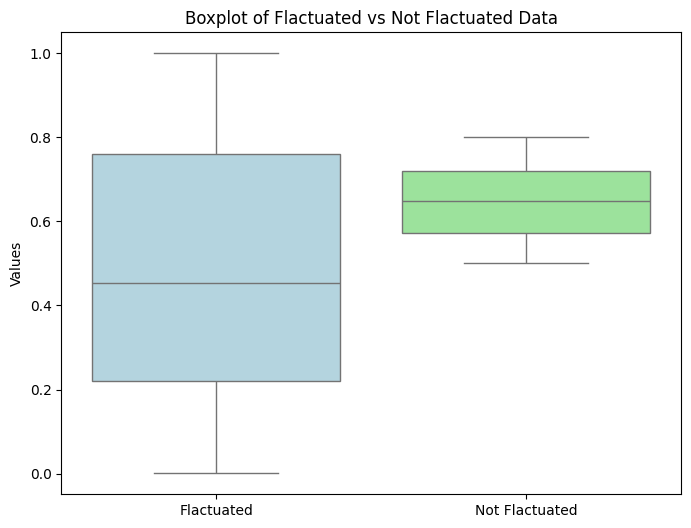


Z-table value: 1.6449

Dunn's Test Z-values:


Flactuated  Not Flactuated
Flactuated            0.0        -11.8631
Not Flactuated   11.8631*          0.0000


Score-based Ranking from Dunn's Test:


Group  Score  rank
1  Not Flactuated      1   1.0
0      Flactuated      0   2.0

Group  Score  rank
1  Not Flactuated      1   1.0
0      Flactuated      0   2.0

In [96]:
flactuated_data = np.random.uniform(low=0, high=1, size=1000)
not_flactuated_data = np.random.uniform(low=0.5, high=0.8, size=1000)
thedf = pd.DataFrame({
    "Flactuated": flactuated_data,
    "Not Flactuated": not_flactuated_data
})

plt.figure(figsize=(8,6))
sns.boxplot(data=thedf, palette=["lightblue", "lightgreen"])
plt.title("Boxplot of Flactuated vs Not Flactuated Data")
plt.ylabel("Values")
plt.show()


costum_dunn_test(thedf.melt(var_name='Group', value_name='Value'), group='Group', val_y='Value', tail='right', alpha=0.05)


## (?) Variable importance biased in random forests and solutions

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-8-25

- `RESULT`: 
When random forest variable importance measures are used with data of varying types, the results are misleading because suboptimal predictor variables may be artificially preferred in variable selection. The two mechanisms underlying this deficiency are biased variable selection in the individual classification trees used to build the random forest on one hand, and effects induced by bootstrap sampling with replacement on the other hand.

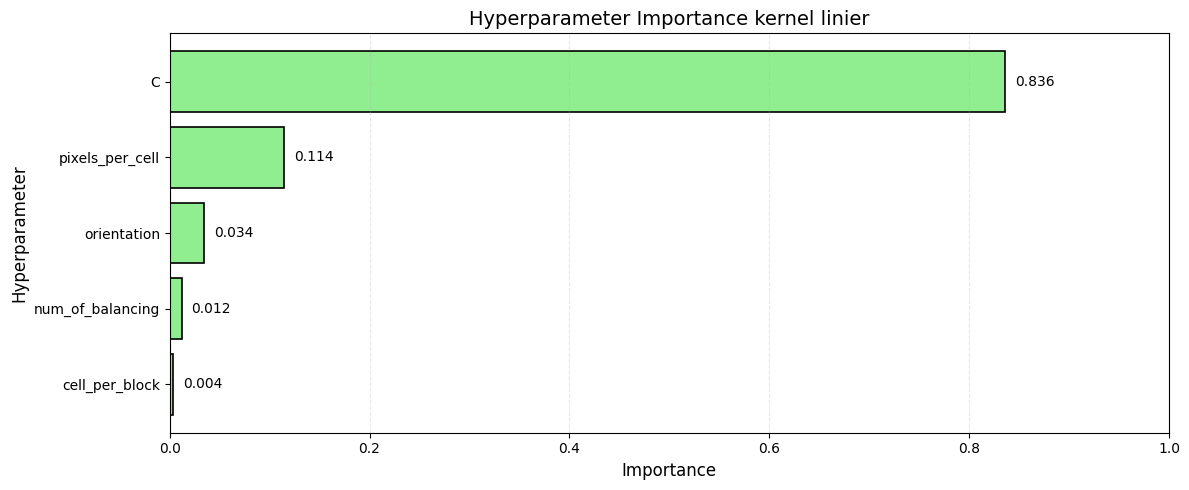

In [149]:
# Load CSV file containing entire FOLDS
hogsvm_all_df = pd.read_csv("!SVM_RESULT/OVERALL_SVM_HOG_TUNING.csv")
hogsvm_all_df = hogsvm_all_df.drop(columns=['fold'])

linear_df = hogsvm_all_df[hogsvm_all_df["kernel"] == "linear"]
linear_df = linear_df.drop(columns=["kernel", "gamma", "degree"])

X = linear_df.drop(columns=["Balanced Accuracy", "Precision", "Recall", "F1 Score"])
y = linear_df["F1 Score"]

X[["C", "orientation", "num_of_balancing"]] = X[["C", "orientation", "num_of_balancing"]].astype(float)
X[["C", "orientation", "num_of_balancing"]] = StandardScaler().fit_transform(X[["C", "orientation", "num_of_balancing"]])

pixels_per_cell_map = {j:i for i,j in enumerate(sorted(linear_df["pixels_per_cell"].unique()))  }
X["pixels_per_cell"] = X["pixels_per_cell"].map(pixels_per_cell_map)
cell_per_block_map = {j:i for i,j in enumerate(sorted(linear_df["cell_per_block"].unique()))  }
X["cell_per_block"] = X["cell_per_block"].map(cell_per_block_map)

#  Random Forest Regressor as the model with hyperparameter collections as features
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)

# cross validate the model
result = permutation_importance(rf, X, y, n_repeats=10)
importance_df_RF = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df_RF = importance_df_RF.sort_values(by='Importance', ascending=True)
importance_df_RF['Normalized'] = importance_df_RF['Importance'] / importance_df_RF['Importance'].sum()


plt.figure(figsize=(12, 5))
bars = plt.barh(importance_df_RF['Feature'], importance_df_RF['Normalized'], color='lightgreen', edgecolor='black', linewidth=1.2)
for i, (bar, value) in enumerate(zip(bars, importance_df_RF['Normalized'])):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Hyperparameter', fontsize=12)
plt.title('Hyperparameter Importance kernel linier', fontsize=14)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

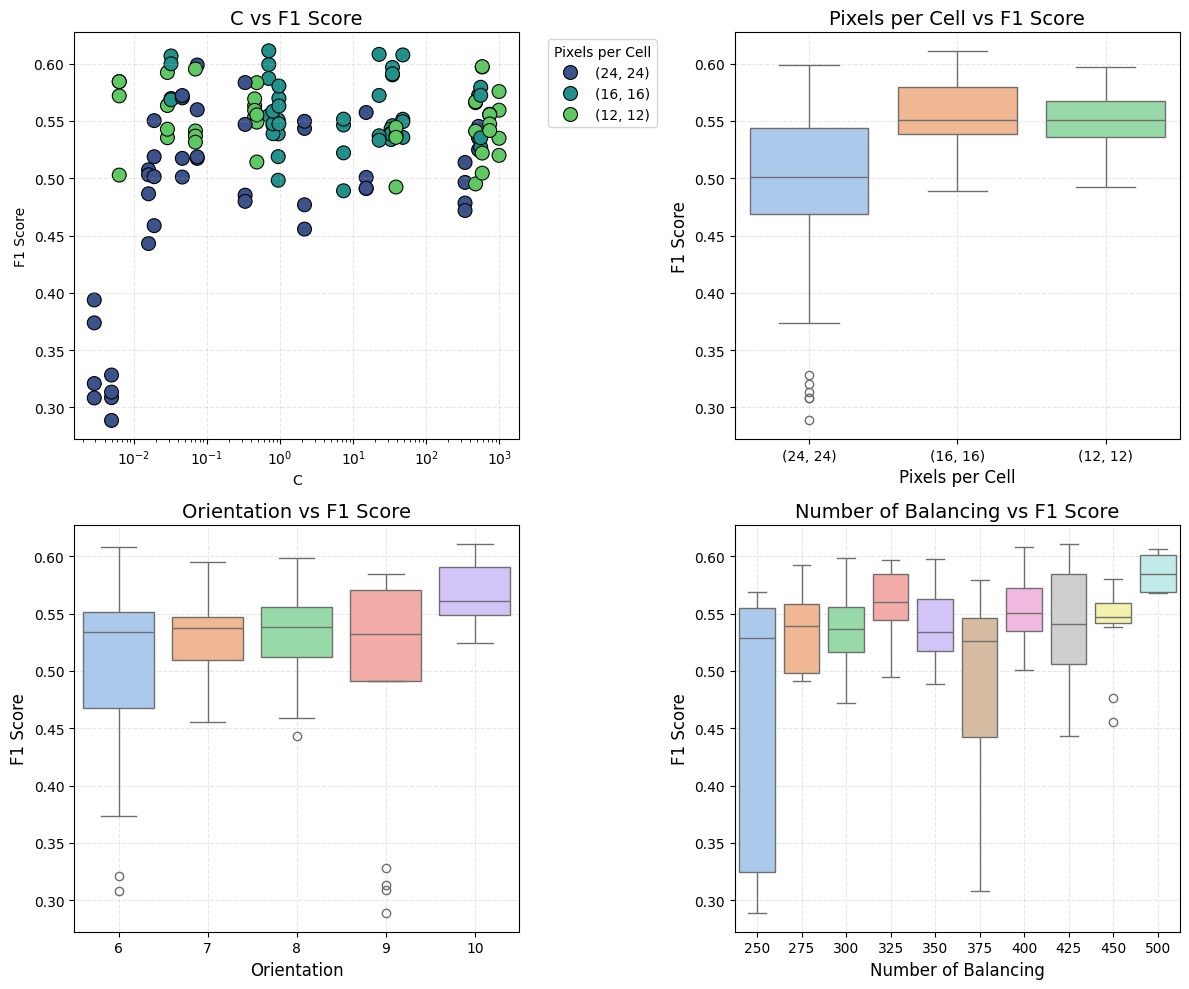

In [145]:
# Plot C, pixels per cell, orientation, and num balancing
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot C
sns.scatterplot(ax=axes[0, 0], data=linear_df, x='C', y='F1 Score', hue='pixels_per_cell', palette='viridis', s=100, edgecolor='black')
axes[0,0].set_xscale('log')
axes[0, 0].set_title('C vs F1 Score', fontsize=14)
axes[0, 0].grid(True, alpha=0.3, linestyle='--')
axes[0, 0].legend(title='Pixels per Cell', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot pixels_per_cell
sns.boxplot(ax=axes[0, 1], data=linear_df, x='pixels_per_cell', y='F1 Score', palette='pastel')
axes[0, 1].set_title('Pixels per Cell vs F1 Score', fontsize=14)
axes[0, 1].grid(True, alpha=0.3, linestyle='--')
axes[0, 1].set_xlabel('Pixels per Cell', fontsize=12)
axes[0, 1].set_ylabel('F1 Score', fontsize=12)

# Plot orientation
sns.boxplot(ax=axes[1, 0], data=linear_df, x='orientation', y='F1 Score', palette='pastel')
axes[1, 0].set_title('Orientation vs F1 Score', fontsize=14)
axes[1, 0].grid(True, alpha=0.3, linestyle='--')
axes[1, 0].set_xlabel('Orientation', fontsize=12)
axes[1, 0].set_ylabel('F1 Score', fontsize=12)

# Plot num_of_balancing
sns.boxplot(ax=axes[1, 1], data=linear_df, x='num_of_balancing', y='F1 Score', palette='pastel')
axes[1, 1].set_title('Number of Balancing vs F1 Score', fontsize=14)
axes[1, 1].grid(True, alpha=0.3, linestyle='--')
axes[1, 1].set_xlabel('Number of Balancing', fontsize=12)
axes[1, 1].set_ylabel('F1 Score', fontsize=12)
plt.tight_layout()
plt.show()



In [156]:
'''
Factor 1: Linear
Factor 2: C Value
Y: F1 Score
'''

# C spearman Correlation Test
corr_c_linear, pvalue_c_linear = stats.spearmanr(linear_df["C"], linear_df["F1 Score"])

print(f'Significant: {pvalue_c_linear < 0.05}\nP-value: {pvalue_c_linear:.4f}\nCorrelation Coefficient: {corr_c_linear:.4f}')

Significant: False
P-value: 0.0620
Correlation Coefficient: 0.1654


Plot and stats result above show the bias in variable importance as it measures continous data with wide range of values as more important than binary or categorical data with less values. Even if the continous variable is not related to the outcome. `LOOK AT PLOT [0,0] DAWG!` There's no way `C` has more importance than `pixels_per_cell` when `pixels_per_cell` is clearly more correlated with the outcome.

Solutions proposed: Use extra trees which use random splits for each node rather than optimal splits. This way the bias is reduced.

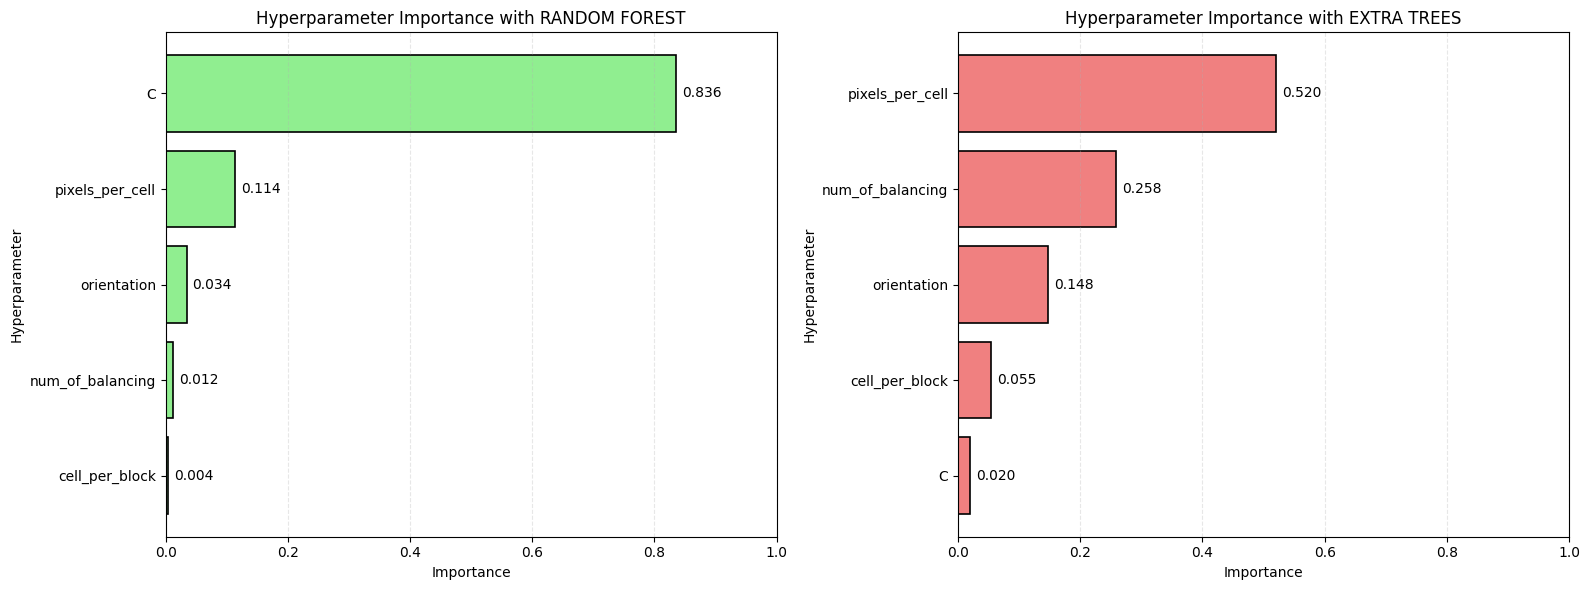

In [ ]:
et = ExtraTreesRegressor(n_estimators=500)
et.fit(X, y)

result = permutation_importance(et, X, y, n_repeats=10)
importance_df_ET = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=True)
importance_df_ET['Normalized'] = importance_df_ET['Importance'] / importance_df_ET['Importance'].sum()


# Comparison with Random Forest
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Importance Plot
bars = axes[0].barh(importance_df_RF['Feature'], importance_df_RF['Normalized'], color='lightgreen', edgecolor='black', linewidth=1.2)
for i, (bar, value) in enumerate(zip(bars, importance_df_RF['Normalized'])):
    axes[0].text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center')

axes[0].set_xlabel('Importance')
axes[0].set_ylabel('Hyperparameter')
axes[0].set_title('Hyperparameter Importance with RANDOM FOREST')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3, linestyle='--')

# Extra Trees Importance Plot
bars = axes[1].barh(importance_df_ET['Feature'], importance_df_ET['Normalized'], color='lightcoral', edgecolor='black', linewidth=1.2)
for i, (bar, value) in enumerate(zip(bars, importance_df_ET['Normalized'])):
    axes[1].text(value + 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{value:.3f}', va='center')

axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Hyperparameter')
axes[1].set_title('Hyperparameter Importance with EXTRA TREES')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Yeah, lowkey extra trees are more reasonable than random forest.

# SVM

In [ ]:
# Don't uncomment this part, it was only used for sorting the csv file of kfold results

# def average_Kfold_latest(DIR, csv_name = ""):
#     """
#     THIS ONE DOESN'T SORT BY HIGHEST VALUE
#     """
#     latest_csv_path = DIR
#     table = pd.read_csv(latest_csv_path)
    
#     filters = [i for i in list(table.columns) if i not in ["fold", "Balanced Accuracy", "Precision", "Recall", "F1 Score"]]
#     table[filters] = table[filters].astype(str)
    
#     avg_metrics = table.groupby(filters).mean().reset_index().drop(columns=["fold"])
    
#     avg_metrics["Balanced Accuracy"] = avg_metrics["Balanced Accuracy"].round(4)
#     avg_metrics["Precision"] = avg_metrics["Precision"].round(4)
#     avg_metrics["Recall"] = avg_metrics["Recall"].round(4)
#     avg_metrics["F1 Score"] = avg_metrics["F1 Score"].round(4)
    
#     avg_metrics.to_csv(csv_name, index=False)

# average_Kfold_latest("OVERALL_SVM_HOG_TUNING.csv", "UNSORTED_AVERAGE_SVM_TUNING.csv")

In [285]:
# Load CSV file with entire folds
all_df = pd.read_csv("!SVM_RESULT/OVERALL_SVM_TUNING.csv")
all_df = all_df.drop(columns=['fold'])

## Basic visualization and Statistical Test 

### No filter

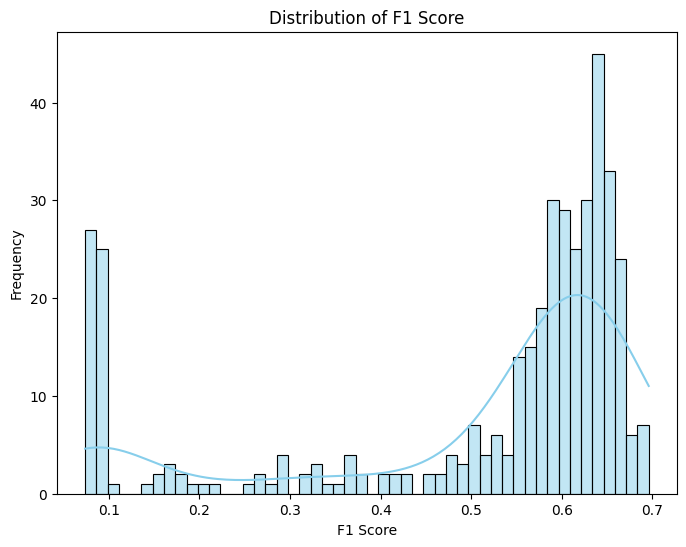

H0: The data is normally distributed
H1: The data is not normally distributed

Shapiro-Wilk Test: Statistics=0.7214, p-value=0.0000
Reject H0


In [286]:
# Example why parametric test is not suitable

# F1 Score distribution
plt.figure(figsize=(8,6))
sns.histplot(all_df["F1 Score"], bins=50, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of F1 Score")
plt.xlabel("F1 Score")
plt.ylabel("Frequency")
plt.show()

# Normality test using Shapiro-Wilk test
stat, p_value = stats.shapiro(all_df["F1 Score"])

print("H0: The data is normally distributed")
print("H1: The data is not normally distributed")

print(f'\nShapiro-Wilk Test: Statistics={stat:.4f}, p-value={p_value:.4f}')
print("Reject H0" if p_value < 0.05 else "Fail to Reject H0")

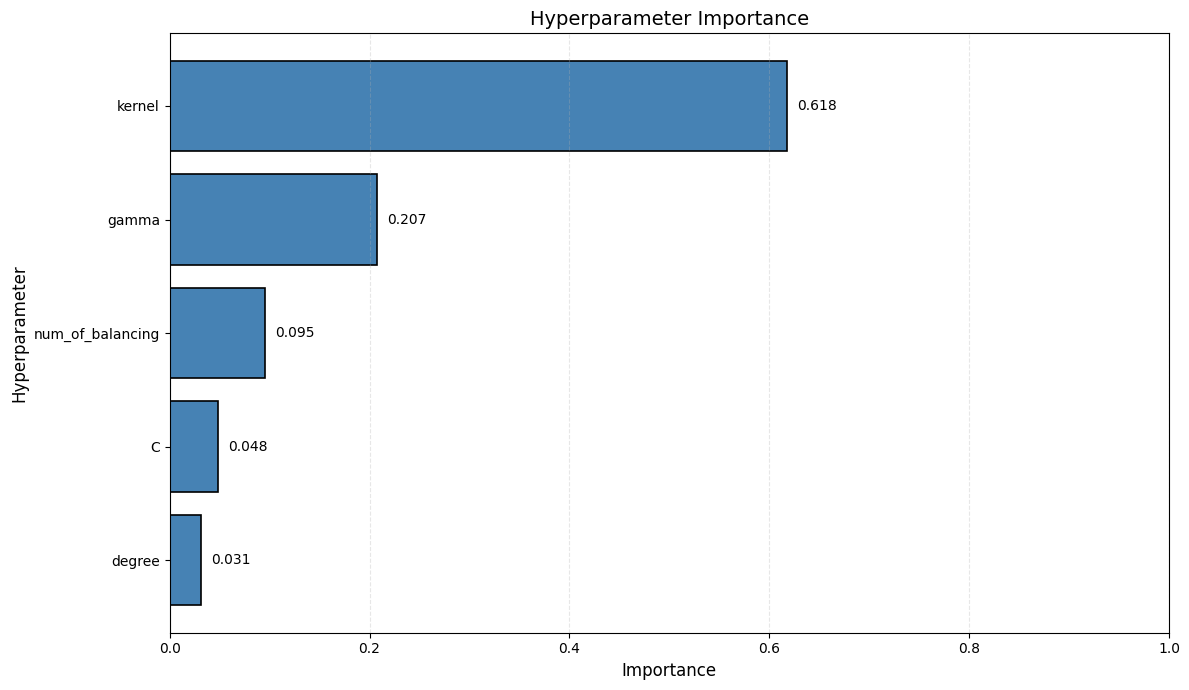

In [287]:
X = all_df.drop(columns=["Balanced Accuracy", "Precision", "Recall", "F1 Score"])
y = all_df["F1 Score"]

X["gamma"] = X["gamma"].replace("auto", 0)
X["degree"].fillna(0, inplace=True)
X[["C", "gamma", "degree", "num_of_balancing"]] = X[["C", "gamma", "degree", "num_of_balancing"]].astype(float)
X[["C", "gamma", "degree", "num_of_balancing"]] = StandardScaler().fit_transform(X[["C", "gamma", "degree", "num_of_balancing"]])

kernel_map = {kernel: i for i, kernel in enumerate(X["kernel"].unique())}
X["kernel"] = X["kernel"].map(kernel_map)

# Extra Trees Regressor as the model for hyperparameter importance
et = ExtraTreesRegressor(n_estimators=500)
et.fit(X, y)

# cross validate the model
result = permutation_importance(et, X, y, n_repeats=10)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance_df['Normalized'] = importance_df['Importance'] / importance_df['Importance'].sum()


plt.figure(figsize=(12, 7))
bars = plt.barh(importance_df['Feature'], importance_df['Normalized'], color='steelblue', edgecolor='black', linewidth=1.2)
for i, (bar, value) in enumerate(zip(bars, importance_df['Normalized'])):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Hyperparameter', fontsize=12)
plt.title('Hyperparameter Importance', fontsize=14)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#### Kernel

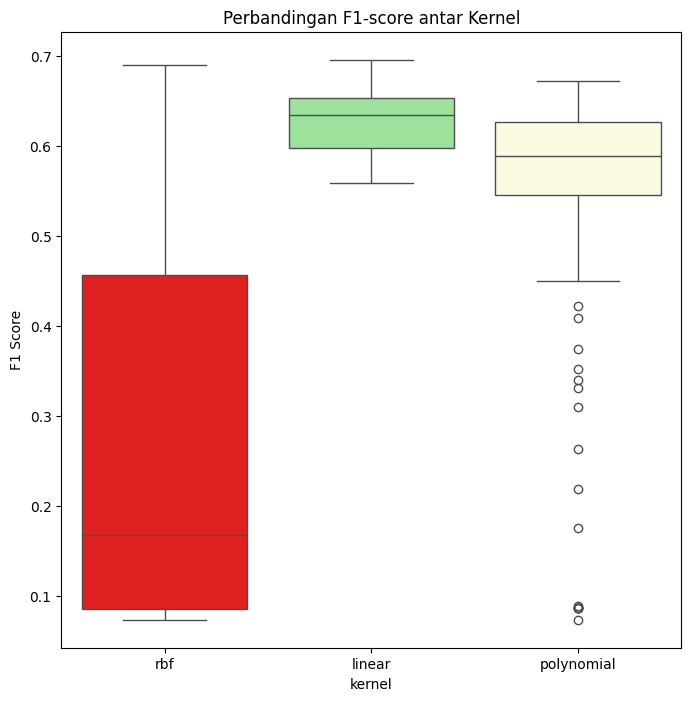

In [52]:
# Kernel BOXPLOT
thecolors = {
    "linear": "lightgreen",
    "polynomial": "lightyellow",
    "rbf": "red",
}
plt.figure(figsize=(8,8))
sns.boxplot(x="kernel", y="F1 Score", data=all_df, palette=thecolors)
plt.title("Perbandingan F1-score antar Kernel")
plt.show()

In [53]:
kruskal_kernel = kruskal_walis_test(all_df, groupby='kernel', y='F1 Score')
print(kruskal_kernel)

   H-statistic       p-value Significance
0   179.173936  1.238438e-39  Significant


In [54]:
dunn_kernel = costum_dunn_test(all_df, group='kernel', val_y='F1 Score', tail='right', alpha=0.05)


Z-table value: 2.1280

Dunn's Test Z-values:


linear polynomial       rbf
linear       0.0000    6.1954*  13.3711*
polynomial  -6.1954        0.0   7.5423*
rbf        -13.3711    -7.5423       0.0


Score-based Ranking from Dunn's Test:


Group  Score  rank
0      linear      2   1.0
1  polynomial      1   2.0
2         rbf      0   3.0

### Linear

In [186]:
linear_df = all_df[all_df["kernel"] == "linear"]
linear_df = linear_df.drop(columns=["kernel", "gamma", "degree"])

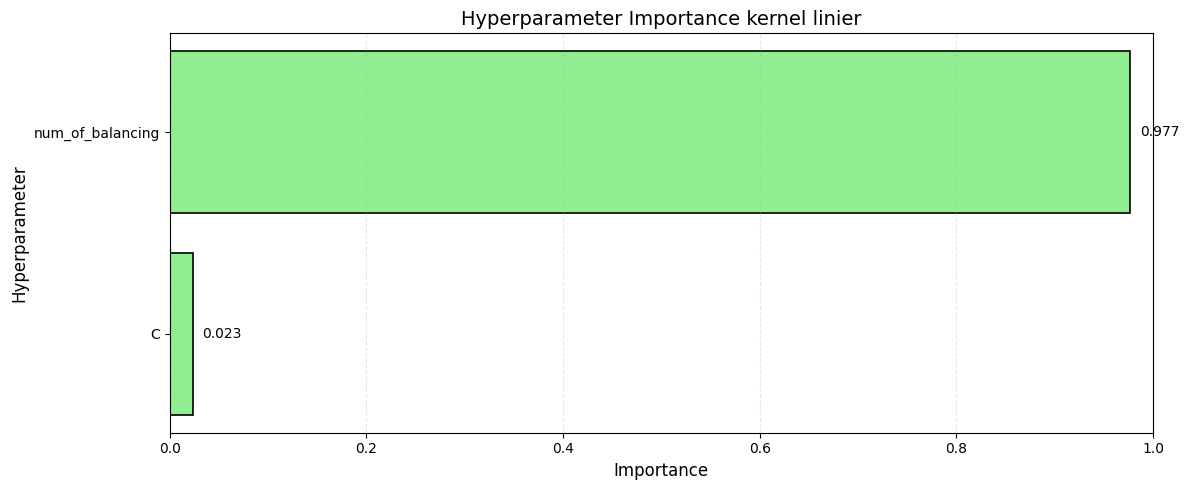

In [187]:
X = linear_df.drop(columns=["Balanced Accuracy", "Precision", "Recall", "F1 Score"])
y = linear_df["F1 Score"]

X[["C", "num_of_balancing"]] = X[["C", "num_of_balancing"]].astype(float)
X[["C", "num_of_balancing"]] = StandardScaler().fit_transform(X[["C", "num_of_balancing"]])

# Extra Trees Regressor as the model for hyperparameter importance
et = ExtraTreesRegressor(n_estimators=500)
et.fit(X, y)

# cross validate the model
result = permutation_importance(et, X, y, n_repeats=10)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance_df['Normalized'] = importance_df['Importance'] / importance_df['Importance'].sum()


plt.figure(figsize=(12, 5))
bars = plt.barh(importance_df['Feature'], importance_df['Normalized'], color='lightgreen', edgecolor='black', linewidth=1.2)
for i, (bar, value) in enumerate(zip(bars, importance_df['Normalized'])):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Hyperparameter', fontsize=12)
plt.title('Hyperparameter Importance kernel linier', fontsize=14)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#### C

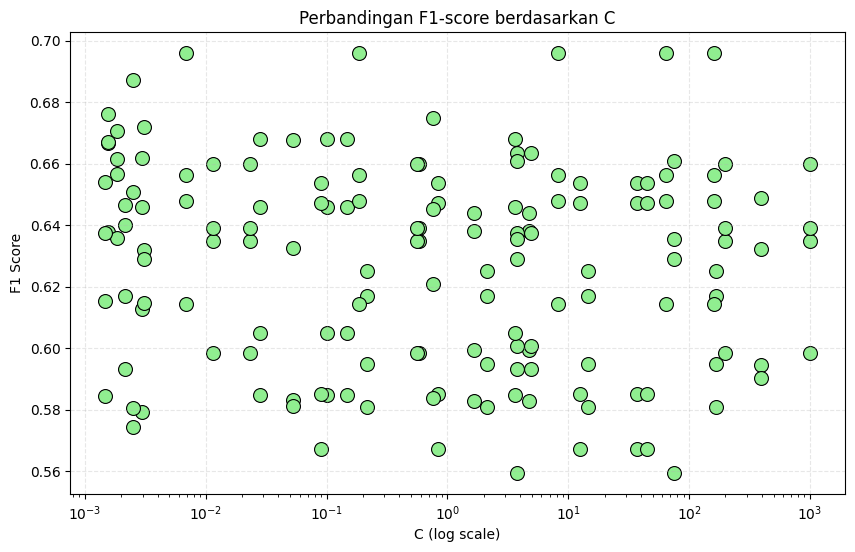

In [188]:
# Plot C vs F1 Score for linear kernel
plt.figure(figsize=(10,6))
sns.scatterplot(x="C", y="F1 Score", data=linear_df, color='lightgreen', s=100, edgecolor='black')
plt.xscale('log')
plt.title("Perbandingan F1-score berdasarkan C")
plt.xlabel("C (log scale)")
plt.ylabel("F1 Score")
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [189]:
'''
Factor 1: Linear
Factor 2: C Value
Y: F1 Score
'''
# C spearman Correlation Test
corr_c_linear, pvalue_c_linear = stats.spearmanr(linear_df["C"], linear_df["F1 Score"])

print(f'Significant: {pvalue_c_linear < 0.05}\nP-value: {pvalue_c_linear:.4f}\nCorrelation Coefficient: {corr_c_linear:.4f}')

Significant: False
P-value: 0.1371
Correlation Coefficient: -0.1181


#### Num Balancing

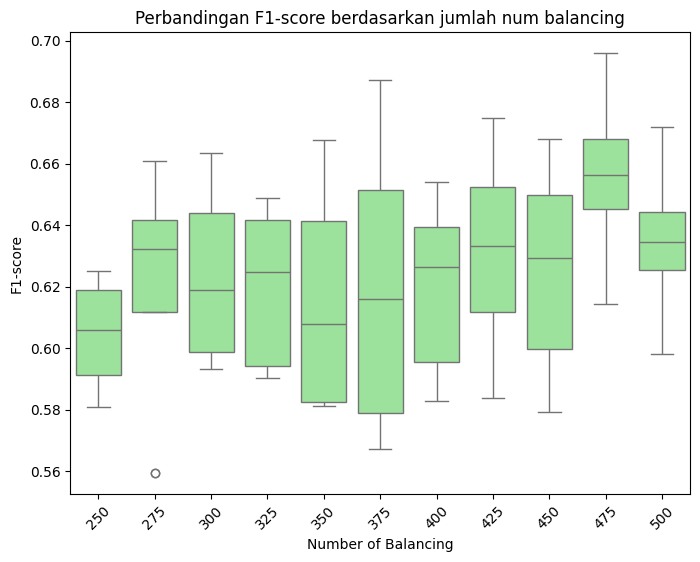

In [190]:
# Plot num_of_balancing vs F1 Score for linear kernel
plt.figure(figsize=(8,6))
sns.boxplot(x="num_of_balancing", y="F1 Score", data=linear_df, color='lightgreen')
plt.title("Perbandingan F1-score berdasarkan jumlah num balancing")
plt.xlabel("Number of Balancing")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.show()

In [191]:
'''
Factor 1: Linear
Factor 2: num_of_balancing
Y: F1 Score
'''
# Num balancing kruskal the fuck out test and Dunn test
kruskal_num_linear = kruskal_walis_test(linear_df, groupby='num_of_balancing', y='F1 Score')
print(kruskal_num_linear)
if kruskal_num_linear["Significance"][0] == "Significant":
    dunn_num_linear = costum_dunn_test(linear_df, group='num_of_balancing', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value Significance
0    33.419776  0.000231  Significant

Z-table value: 3.1184

Dunn's Test Z-values:


250     275     300     325     350      375      400     425  \
250      0.0 -1.4455 -1.6075 -1.2337 -0.7239  -1.4824  -1.2104 -1.5347   
275   1.4455  0.0000 -0.1403  0.1835  0.3613   0.3613   0.3586 -0.3789   
300   1.6075  0.1403  0.0000  0.3237  0.4758   0.5331   0.5123 -0.2643   
325   1.2337 -0.1835 -0.3237  0.0000  0.2115   0.1366   0.1576 -0.5287   
350   0.7239 -0.3613 -0.4758 -0.2115  0.0000  -0.1365  -0.0997 -0.6410   
375   1.4824 -0.3613 -0.5331 -0.1366  0.1365      0.0   0.0458 -0.7027   
400   1.2104 -0.3586 -0.5123 -0.1576  0.0997  -0.0458      0.0 -0.6854   
425   1.5347  0.3789  0.2643  0.5287  0.6410   0.7027   0.6854  0.0000   
450   2.2812  0.3328  0.1651  0.5521  0.6581   0.9469   0.8295 -0.1694   
475  5.0767*  2.4073  2.2324  2.6361  2.2194  3.9995*  3.2714*  1.3714   
500   2.9417  0.7384  0.5634  0.9672  0.9676   1.5943   1.3323  0.1197   

        450     475     500  
250 -2.2812 -5.0767 -2.9417  
275 -0.3328 -2.4073 -0.7384  
300 -0.1651 -2.2324 -0.5634  
325 -0.5521 -2.6361 -0.9672  
350 -0.6581 -2.2194 -0.9676  
375 -0.9469 -3.9995 -1.5943  
400 -0.8295 -3.2714 -1.3323  
425  0.1694 -1.3714 -0.1197  
450  0.0000 -2.8209 -0.5355  
475  2.8209  0.0000  2.5035  
500  0.5355 -2.5035  0.0000


Score-based Ranking from Dunn's Test:


Group  Score  rank
9     475      3   1.0
0     250      0   2.0
2     300      0   2.0
1     275      0   2.0
4     350      0   2.0
5     375      0   2.0
6     400      0   2.0
3     325      0   2.0
7     425      0   2.0
8     450      0   2.0
10    500      0   2.0

### Polynomial

In [165]:
poly_df = all_df[all_df["kernel"] == "polynomial"]
poly_df = poly_df.drop(columns=["kernel"])
poly_df["gamma"] = pd.to_numeric(poly_df["gamma"], errors='coerce')

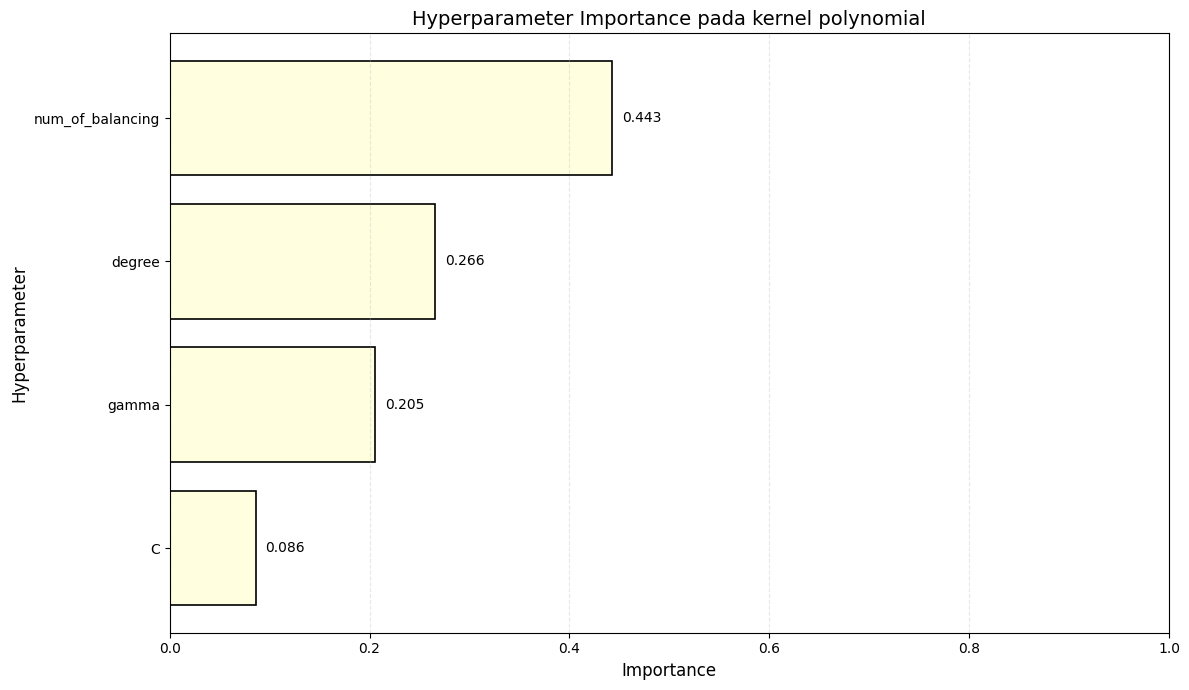

In [166]:
X = poly_df.drop(columns=["Balanced Accuracy", "Precision", "Recall", "F1 Score"])
y = poly_df["F1 Score"]

X[["C", "gamma", "degree", "num_of_balancing"]] = X[["C", "gamma", "degree", "num_of_balancing"]].astype(float)
X[["C", "gamma", "degree", "num_of_balancing"]] = StandardScaler().fit_transform(X[["C", "gamma", "degree", "num_of_balancing"]])

# Extra Trees Regressor as the model for hyperparameter importance
et = ExtraTreesRegressor(n_estimators=500)
et.fit(X, y)

# cross validate the model
result = permutation_importance(et, X, y, n_repeats=10)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance_df['Normalized'] = importance_df['Importance'] / importance_df['Importance'].sum()


plt.figure(figsize=(12, 7))
bars = plt.barh(importance_df['Feature'], importance_df['Normalized'], color='lightyellow', edgecolor='black', linewidth=1.2)
for i, (bar, value) in enumerate(zip(bars, importance_df['Normalized'])):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Hyperparameter', fontsize=12)
plt.title('Hyperparameter Importance pada kernel polynomial', fontsize=14)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#### C

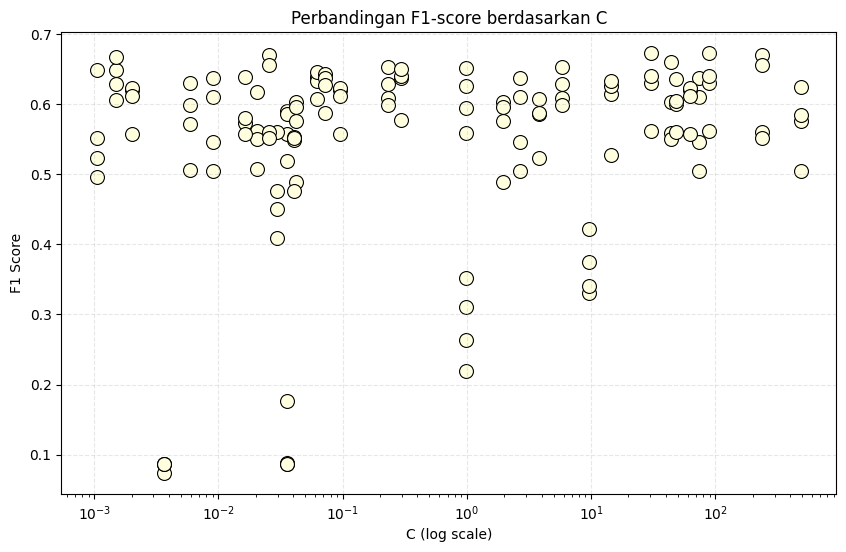

In [167]:
# Plot C vs F1 Score for poly poly poly polyci, mamah takutt ada polici 

plt.figure(figsize=(10,6))
sns.scatterplot(x="C", y="F1 Score", data=poly_df, color='lightyellow', s=100, edgecolor='black')
plt.xscale('log')
plt.title("Perbandingan F1-score berdasarkan C")
plt.xlabel("C (log scale)")
plt.ylabel("F1 Score")
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [168]:
'''
Factor 1: Poly
Factor 2: C Value
Y: F1 Score
'''
# C spearman Correlation Test
corr_c_poly, pvalue_c_poly = stats.spearmanr(poly_df["C"], poly_df["F1 Score"])

print(f'Significant: {pvalue_c_poly < 0.05}\nP-value: {pvalue_c_poly:.4f}\nCorrelation Coefficient: {corr_c_poly:.4f}')

Significant: True
P-value: 0.0458
Correlation Coefficient: 0.1691


#### Num Balancing

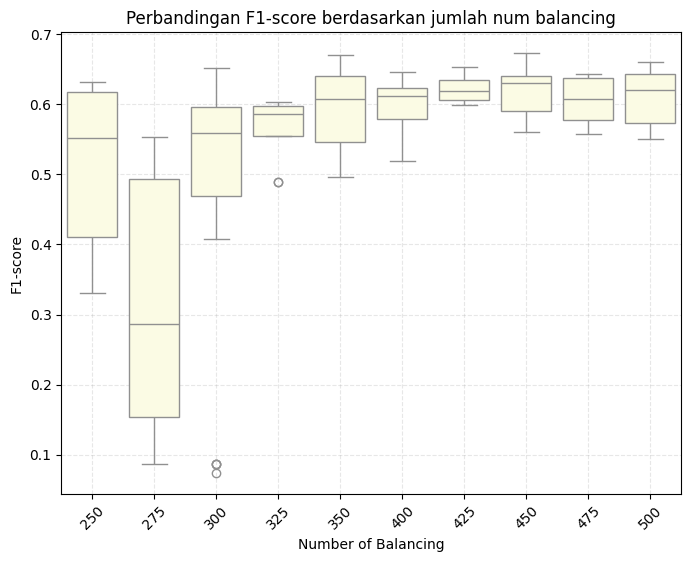

In [169]:
# Plot num_of_balancing vs F1 Score for poly kernel
plt.figure(figsize=(8,6))
sns.boxplot(x="num_of_balancing", y="F1 Score", data=poly_df, color='lightyellow')
plt.title("Perbandingan F1-score berdasarkan jumlah num balancing")
plt.xlabel("Number of Balancing")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [170]:
'''
Factor 1: Poly
Factor 2: num_of_balancing
Y: F1 Score
'''
# Num balancing kruskal and dunn test
kruskal_num_poly = kruskal_walis_test(poly_df, groupby='num_of_balancing', y='F1 Score')

print(kruskal_num_poly)
if kruskal_num_poly["Significance"][0] == "Significant":
    dunn_num_poly = costum_dunn_test(poly_df, group='num_of_balancing', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic       p-value Significance
0    45.811262  6.527857e-07  Significant

Z-table value: 3.0588

Dunn's Test Z-values:


250      275      300     325     350     400     425     450     475  \
250  0.0000   2.2472   0.2644 -0.2633 -1.7418 -1.9396 -2.4781 -2.6548 -1.8299   
275 -2.2472      0.0  -2.3304 -2.2733 -4.4007 -4.4520 -4.4880 -4.9020 -3.8398   
300 -0.2644   2.3304      0.0 -0.5234 -2.4965 -2.6480 -2.9996 -3.3299 -2.2748   
325  0.2633   2.2733   0.5234  0.0000 -1.1993 -1.4057 -2.0218 -2.1112 -1.4300   
350  1.7418  4.4007*   2.4965  1.1993  0.0000 -0.3663 -1.3223 -1.3994 -0.5843   
400  1.9396   4.452*    2.648  1.4057  0.3663  0.0000 -1.0108 -1.0286 -0.3035   
425  2.4781   4.488*   2.9996  2.0218  1.3223  1.0108  0.0000  0.1035  0.5917   
450  2.6548   4.902*  3.3299*  2.1112  1.3994  1.0286 -0.1035  0.0000  0.5447   
475  1.8299  3.8398*   2.2748  1.4300  0.5843  0.3035 -0.5917 -0.5447  0.0000   
500  2.0155  4.0255*   2.4824  1.5995  0.7957  0.5061 -0.4222 -0.3590  0.1695   

        500  
250 -2.0155  
275 -4.0255  
300 -2.4824  
325 -1.5995  
350 -0.7957  
400 -0.5061  
425  0.4222  
450  0.3590  
475 -0.1695  
500  0.0000


Score-based Ranking from Dunn's Test:


Group  Score  rank
7    450      2   1.0
6    425      1   2.0
4    350      1   2.0
5    400      1   2.0
9    500      1   2.0
8    475      1   2.0
3    325      0   7.0
2    300      0   7.0
0    250      0   7.0
1    275      0   7.0

#### Gamma

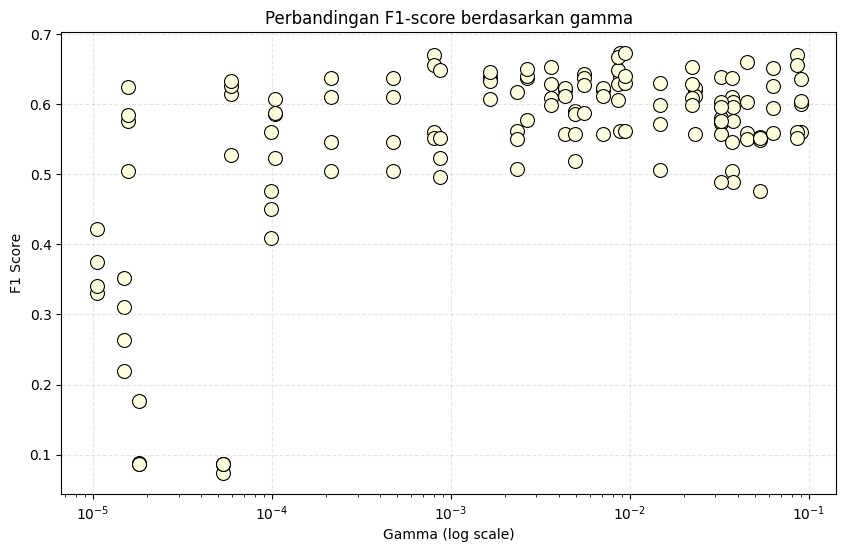

In [171]:
# Scatter gamma vs f1 score fur das poly kernel

plt.figure(figsize=(10,6))
sns.scatterplot(x="gamma", y="F1 Score", data=poly_df, color='lightyellow', s=100, edgecolor='black')
plt.xscale('log')
plt.title("Perbandingan F1-score berdasarkan gamma")
plt.xlabel("Gamma (log scale)")
plt.ylabel("F1 Score")
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [172]:
'''
Factor 1: Poly
Factor 2: gamma
Y: F1 Score
'''
# Gamma spearman Correlation Test
corr_gamma_poly, pvalue_gamma_poly = stats.spearmanr(pd.to_numeric(poly_df["gamma"], errors='coerce'), poly_df["F1 Score"])

print(f'Significant: {pvalue_gamma_poly < 0.05}\nP-value: {pvalue_gamma_poly:.4f}\nCorrelation Coefficient: {corr_gamma_poly:.4f}')

Significant: True
P-value: 0.0000
Correlation Coefficient: 0.3368


#### Degree

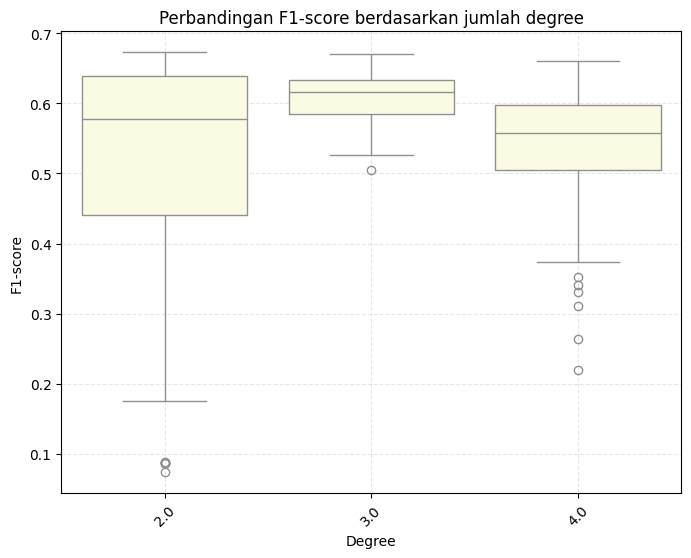

In [173]:
# boxplot derajat vs f1 score fur das poly kernel

plt.figure(figsize=(8,6))
sns.boxplot(x="degree", y="F1 Score", data=poly_df, color='lightyellow')
plt.title("Perbandingan F1-score berdasarkan jumlah degree")
plt.xlabel("Degree")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [174]:
'''
Factor 1: Poly
Factor 2: digri
Y: F1 Score
'''
# Kruskal and dunn test for degree
kruskal_degree_poly = kruskal_walis_test(poly_df, groupby='degree', y='F1 Score')

print(kruskal_degree_poly)
if kruskal_degree_poly["Significance"][0] == "Significant":
    dunn_degree_poly = costum_dunn_test(poly_df, group='degree', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value Significance
0     20.12826  0.000043  Significant

Z-table value: 2.1280

Dunn's Test Z-values:


2.0     3.0      4.0
2.0      0.0 -2.4237   1.6192
3.0  2.4237*  0.0000  4.4752*
4.0  -1.6192 -4.4752      0.0


Score-based Ranking from Dunn's Test:


Group  Score  rank
1    3.0      2   1.0
0    2.0      0   2.0
2    4.0      0   2.0

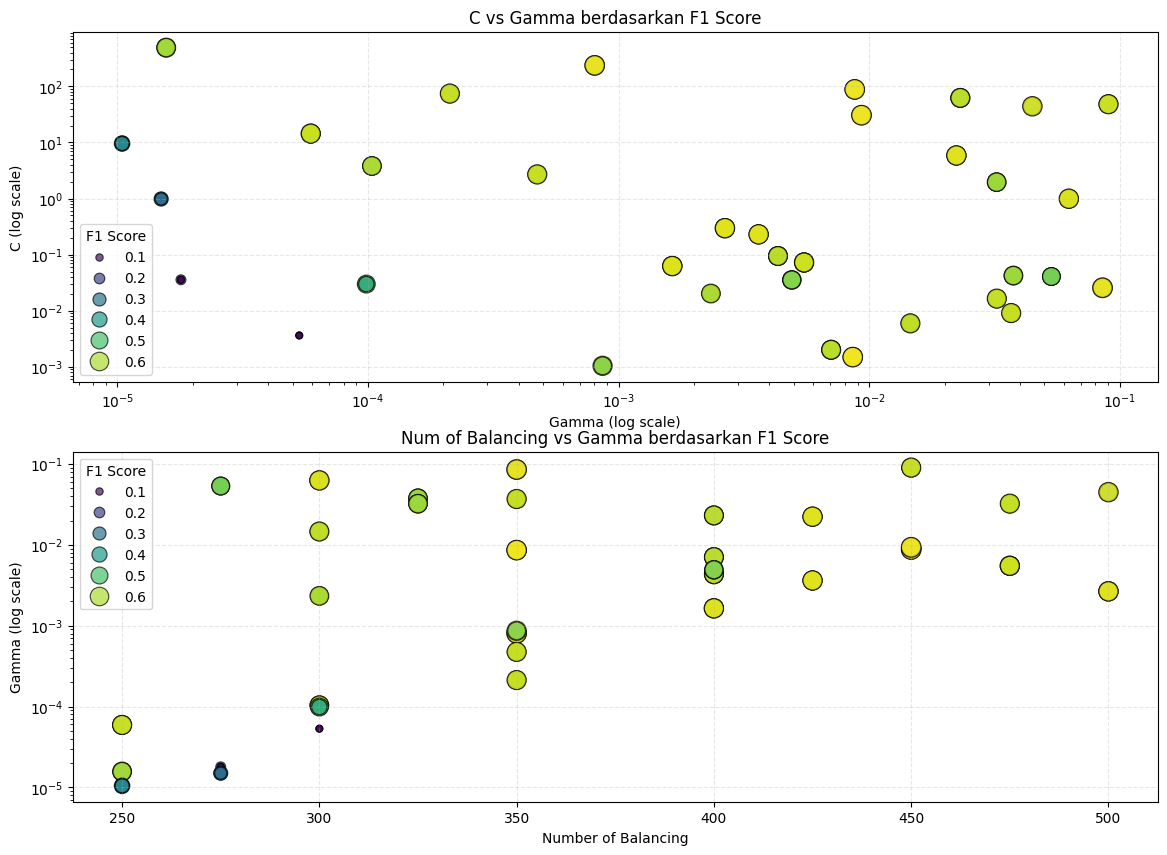

In [175]:
fig, axes = plt.subplots(2,1, figsize=(14, 10))

# Scatter C vs gamma
sns.scatterplot(x="gamma", y="C", size="F1 Score", sizes=(20, 200), hue="F1 Score", data=poly_df, palette="viridis", edgecolor='black', alpha=0.7, ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title("C vs Gamma berdasarkan F1 Score")
axes[0].set_xlabel("Gamma (log scale)")
axes[0].set_ylabel("C (log scale)")
axes[0].grid(True, alpha=0.3, linestyle='--')


# Scatter num_of_balancing
sns.scatterplot(x="num_of_balancing", y="gamma", size="F1 Score", sizes=(20, 200), hue="F1 Score", data=poly_df, palette="viridis", edgecolor='black', alpha=0.7, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel("Number of Balancing")
axes[1].set_ylabel("Gamma (log scale)")
axes[1].set_title("Num of Balancing vs Gamma berdasarkan F1 Score")
axes[1].grid(True, alpha=0.3, linestyle='--')

### RBF

In [176]:
rbf_df = all_df[all_df["kernel"] == "rbf"]
rbf_df = rbf_df.drop(columns=["kernel", "degree"])
rbf_df["gamma"] = pd.to_numeric(rbf_df["gamma"], errors='coerce')

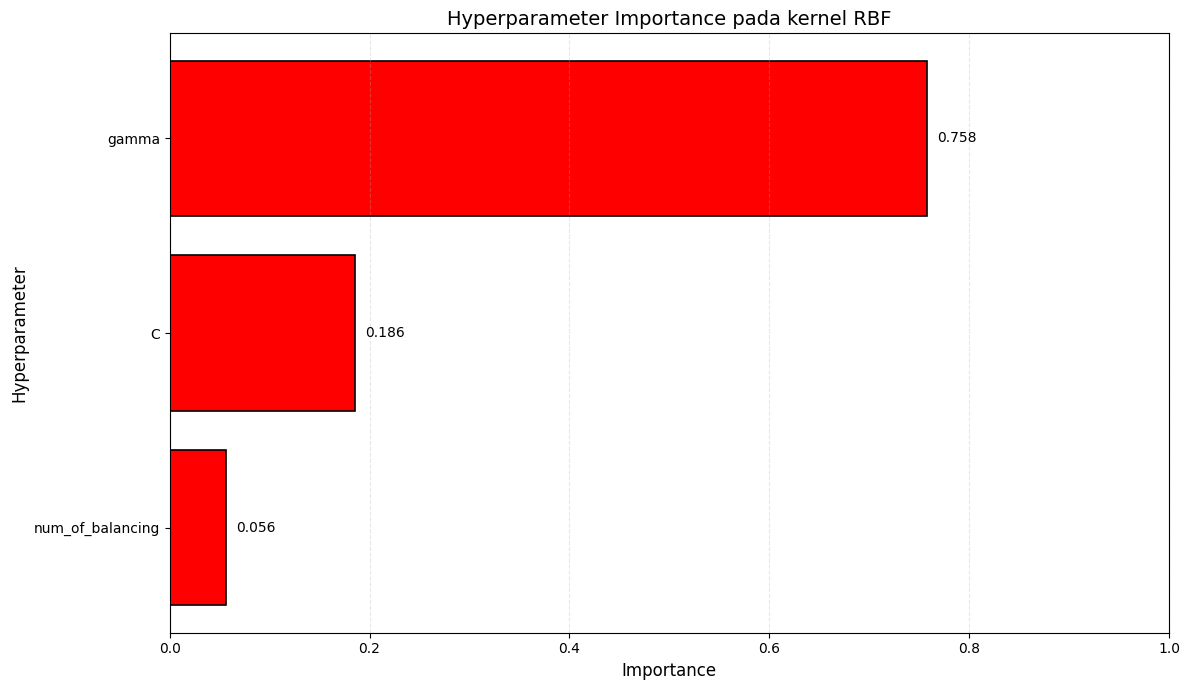

In [177]:
X = rbf_df.drop(columns=["Balanced Accuracy", "Precision", "Recall", "F1 Score"])
y = rbf_df["F1 Score"]

X[["C", "gamma", "num_of_balancing"]] = X[["C", "gamma", "num_of_balancing"]].astype(float)
X[["C", "gamma", "num_of_balancing"]] = StandardScaler().fit_transform(X[["C", "gamma", "num_of_balancing"]])

# Extra Trees Regressor as the model for hyperparameter importance
et = ExtraTreesRegressor(n_estimators=500)
et.fit(X, y)

# cross validate the model
result = permutation_importance(et, X, y, n_repeats=10)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance_df['Normalized'] = importance_df['Importance'] / importance_df['Importance'].sum()


plt.figure(figsize=(12, 7))
bars = plt.barh(importance_df['Feature'], importance_df['Normalized'], color='red', edgecolor='black', linewidth=1.2)
for i, (bar, value) in enumerate(zip(bars, importance_df['Normalized'])):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Hyperparameter', fontsize=12)
plt.title('Hyperparameter Importance pada kernel RBF', fontsize=14)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#### C

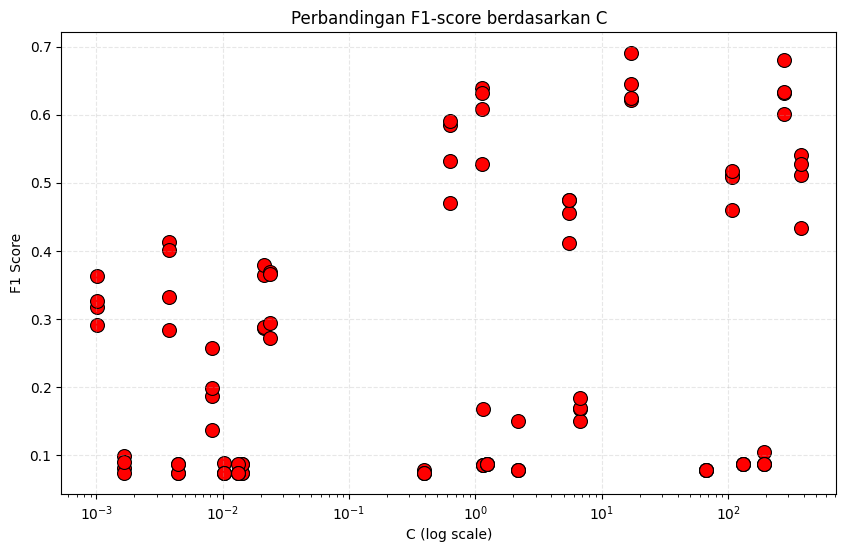

In [178]:
# Plot C vs F1 Score for rbf kernel aka gaussian or idfk u wanna call it
plt.figure(figsize=(10,6))
sns.scatterplot(x="C", y="F1 Score", data=rbf_df, color='red', s=100, edgecolor='black')
plt.xscale('log')
plt.title("Perbandingan F1-score berdasarkan C")
plt.xlabel("C (log scale)")
plt.ylabel("F1 Score")
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [179]:
'''
Factor 1: RBF
Factor 2: C Value
Y: F1 Score
'''
# C spearman Correlation Test
corr_c_rbf, pvalue_c_rbf = stats.spearmanr(rbf_df["C"], rbf_df["F1 Score"])

print(f'Significant: {pvalue_c_rbf < 0.05}\nP-value: {pvalue_c_rbf:.4f}\nCorrelation Coefficient: {corr_c_rbf:.4f}')

Significant: True
P-value: 0.0023
Correlation Coefficient: 0.3011


#### Num Balancing

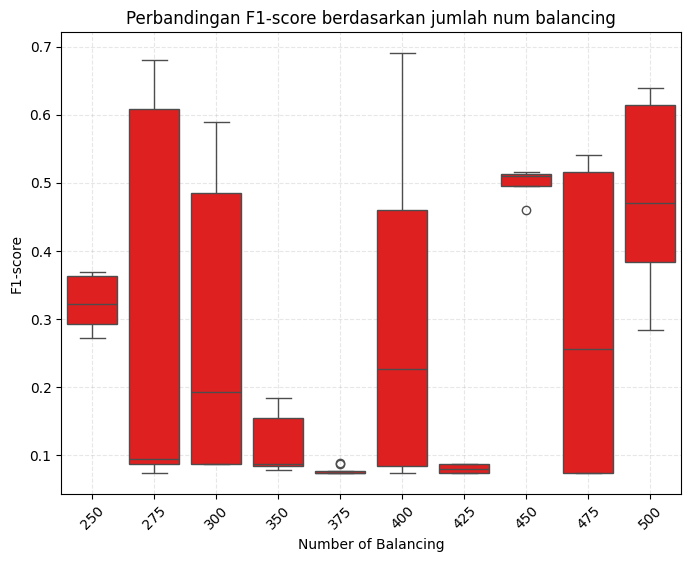

In [180]:
# Plot num_of_balancing vs F1 Score for rbf kernel

plt.figure(figsize=(8,6))
sns.boxplot(x="num_of_balancing", y="F1 Score", data=rbf_df, color='red')
plt.title("Perbandingan F1-score berdasarkan jumlah num balancing")
plt.xlabel("Number of Balancing")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [181]:
'''
Factor 1: RBF
Factor 2: num_of_balancing
Y: F1 Score
'''
# Num balancing kruskal and dunn test
kruskal_num_rbf = kruskal_walis_test(rbf_df, groupby='num_of_balancing', y='F1 Score')

print(kruskal_num_rbf)
if kruskal_num_rbf["Significance"][0] == "Significant":
    dunn_num_rbf = costum_dunn_test(rbf_df, group='num_of_balancing', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value Significance
0     33.51228  0.000109  Significant

Z-table value: 3.0588

Dunn's Test Z-values:


250     275     300     350      375     400      425     450     475  \
250  0.0000  0.7300  0.4720  2.0075  3.3392*  1.0677   2.4063 -0.9287  1.2323   
275 -0.7300  0.0000 -0.2885  1.4283   2.9279  0.2904   1.9751 -1.5622  0.6199   
300 -0.4720  0.2885  0.0000  1.7168  3.1859*  0.6236   2.1791 -1.3582  0.8779   
350 -2.0075 -1.4283 -1.7168     0.0   1.6504 -1.3588   0.9652 -2.5722 -0.6576   
375 -3.3392 -2.9279 -3.1859 -1.6504      0.0 -3.0220  -0.3201 -3.6552 -2.1069   
400 -1.0677 -0.2904 -0.6236  1.3588    3.022  0.0000   1.9214 -1.8602  0.4415   
425 -2.4063 -1.9751 -2.1791 -0.9652   0.3201 -1.9214      0.0 -2.8882 -1.4002   
450  0.9287  1.5622  1.3582  2.5722  3.6552*  1.8602   2.8882  0.0000  1.9349   
475 -1.2323 -0.6199 -0.8779  0.6576   2.1069 -0.4415   1.4002 -1.9349  0.0000   
500  1.0685  1.9005  1.6425  3.178*  4.4077*  2.3764  3.2788* -0.0563  2.3008   

        500  
250 -1.0685  
275 -1.9005  
300 -1.6425  
350 -3.1780  
375 -4.4077  
400 -2.3764  
425 -3.2788  
450  0.0563  
475 -2.3008  
500  0.0000


Score-based Ranking from Dunn's Test:


Group  Score  rank
9    500      3   1.0
0    250      1   2.0
7    450      1   2.0
2    300      1   2.0
3    350      0   5.0
4    375      0   5.0
5    400      0   5.0
1    275      0   5.0
6    425      0   5.0
8    475      0   5.0

#### Gamma

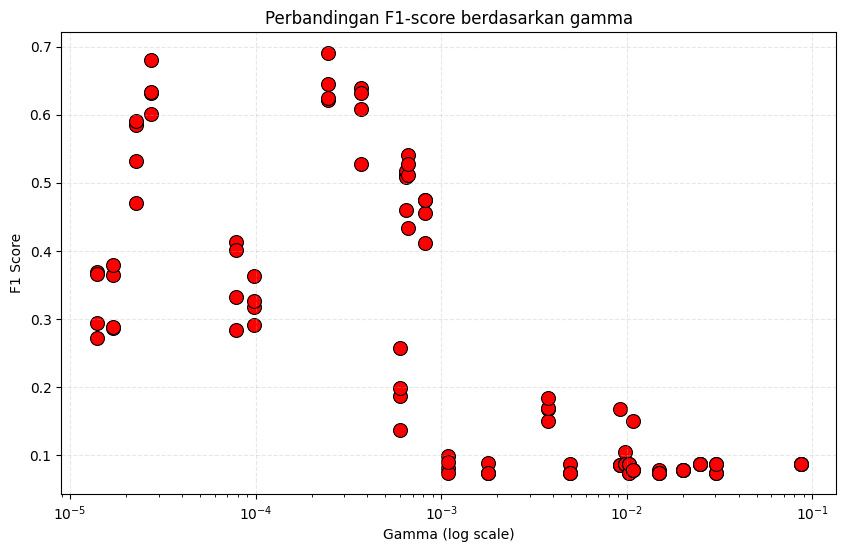

In [182]:
# Scatter gamma vs f1 score fur das poly kernel
plt.figure(figsize=(10,6))
sns.scatterplot(x="gamma", y="F1 Score", data=rbf_df, color='red', s=100, edgecolor='black')
plt.xscale('log')
plt.title("Perbandingan F1-score berdasarkan gamma")
plt.xlabel("Gamma (log scale)")
plt.ylabel("F1 Score")
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [183]:
'''
Factor 1: RBF
Factor 2: gamma
Y: F1 Score
'''
# Gamma spearman Correlation Test
corr_gamma_rbf, pvalue_gamma_rbf = stats.spearmanr(pd.to_numeric(rbf_df["gamma"], errors='coerce'), rbf_df["F1 Score"])

print(f'Significant: {pvalue_gamma_rbf < 0.05}\nP-value: {pvalue_gamma_rbf:.4f}\nCorrelation Coefficient: {corr_gamma_rbf:.4f}')


Significant: True
P-value: 0.0000
Correlation Coefficient: -0.7446


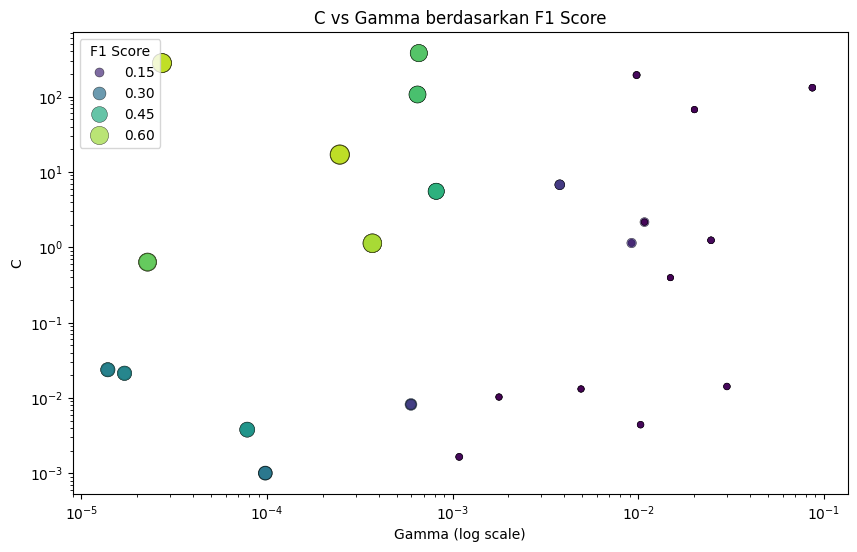

In [184]:
plt.figure(figsize=(10,6))
# Scatter C vs gamma
sns.scatterplot(x="gamma", y="C", size="F1 Score", sizes=(20, 200), hue="F1 Score", data=rbf_df, palette="viridis", edgecolor='black', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title("C vs Gamma berdasarkan F1 Score")
plt.xlabel("Gamma (log scale)")
axes[0].set_ylabel("C (log scale)")
axes[0].grid(True, alpha=0.3, linestyle='--')

## Summary

In [192]:
results_summary_linear = pd.DataFrame({
    'Hyperparameter': ['C', 'Num balancing'],
    'Test': ['Spearman', 'Kruskal-Wallis'],
    'P_Value': [round(pvalue_c_linear, 4), round(kruskal_num_linear["p-value"][0], 4)],
    'Significant': [pvalue_c_linear < 0.05, kruskal_num_linear["p-value"][0] < 0.05],
    'Detail': [f'Corr: {round(corr_c_linear, 4)}', 
               f'Dunn: {dunn_num_linear[dunn_num_linear["rank"] == dunn_num_linear["rank"].unique()[0]]["Group"].values if kruskal_num_linear["Significance"][0] == "Significant" else "Nothing good"}']
})

In [37]:
# Yuh
results_summary_poly = pd.DataFrame({
    'Hyperparameter': ['C', 'Num balancing', "Gamma", "Degree"],
    'Test': ['Spearman', 'Kruskal-Wallis', "Spearman", "Kruskal-Wallis"],
    'P_Value': [round(pvalue_c_poly, 4), round(kruskal_num_poly["p-value"][0], 4), round(pvalue_gamma_poly, 4), round(kruskal_degree_poly["p-value"][0], 4)],
    'Significant': [pvalue_c_poly < 0.05, kruskal_num_poly["p-value"][0] < 0.05, pvalue_gamma_poly < 0.05, kruskal_degree_poly["p-value"][0] < 0.05],
    'Detail': [f'Corr: {round(corr_c_poly, 4)}', 
               f'Dunn: {dunn_num_poly[dunn_num_poly["rank"] == dunn_num_poly["rank"].unique()[0]]["Group"].values if kruskal_num_poly["Significance"][0] == "Significant" else "Nothing good"}',
               f'Corr: {round(corr_gamma_poly, 4)}',
               f'Dunn: {dunn_degree_poly[dunn_degree_poly["rank"] == dunn_degree_poly["rank"].unique()[0]]["Group"].values if kruskal_degree_poly["Significance"][0] == "Significant" else "Nothing good"}']
})

In [38]:
# At this point, why the fuck did i not steamline TS :sob:
results_summary_rbf = pd.DataFrame({
    'Hyperparameter': ['C', 'Num balancing', "Gamma"],
    'Test': ['Spearman', 'Kruskal-Wallis', "Spearman"],
    'P_Value': [round(pvalue_c_rbf, 4), round(kruskal_num_rbf["p-value"][0], 4), round(pvalue_gamma_rbf, 4)],
    'Significant': [pvalue_c_rbf < 0.05, kruskal_num_rbf["p-value"][0] < 0.05, pvalue_gamma_rbf < 0.05],
    'Detail': [f'Corr: {round(corr_c_rbf, 4)}',
               f'Dunn: {dunn_num_rbf[dunn_num_rbf["rank"] == dunn_num_rbf["rank"].unique()[0]]["Group"].values if kruskal_num_rbf["Significance"][0] == "Significant" else "Nothing good"}',
               f'Corr: {round(corr_gamma_rbf, 4)}']
})

In [39]:
print("\nKernel:")
display(kruskal_kernel)
display(dunn_kernel)

print(f'\n{"="*100}')
print("\nLinear")

display(results_summary_linear)

print("\nPolynomial")
display(results_summary_poly)

print("\nRBF")
display(results_summary_rbf)



Kernel:


H-statistic       p-value Significance
0   179.173936  1.238438e-39  Significant

Group  Score  rank
0      linear      2   1.0
1  polynomial      1   2.0
2         rbf      0   3.0



Linear


Hyperparameter            Test  P_Value  Significant         Detail
0              C        Spearman   0.1371        False  Corr: -0.1181
1  Num balancing  Kruskal-Wallis   0.0002         True    Dunn: [475]


Polynomial


Hyperparameter            Test  P_Value  Significant        Detail
0              C        Spearman   0.0458         True  Corr: 0.1691
1  Num balancing  Kruskal-Wallis   0.0000         True   Dunn: [450]
2          Gamma        Spearman   0.0000         True  Corr: 0.3368
3         Degree  Kruskal-Wallis   0.0000         True    Dunn: [3.]


RBF


Hyperparameter            Test  P_Value  Significant         Detail
0              C        Spearman   0.0023         True   Corr: 0.3011
1  Num balancing  Kruskal-Wallis   0.0001         True    Dunn: [500]
2          Gamma        Spearman   0.0000         True  Corr: -0.7446

# HOG-SVM

In [288]:
# Load CSV file containing entire FOLDS
hogsvm_all_df = pd.read_csv("!SVM_RESULT/OVERALL_SVM_HOG_TUNING.csv")
hogsvm_all_df = hogsvm_all_df.drop(columns=['fold'])

## Basic visualization and Statistical Test 

### No filter

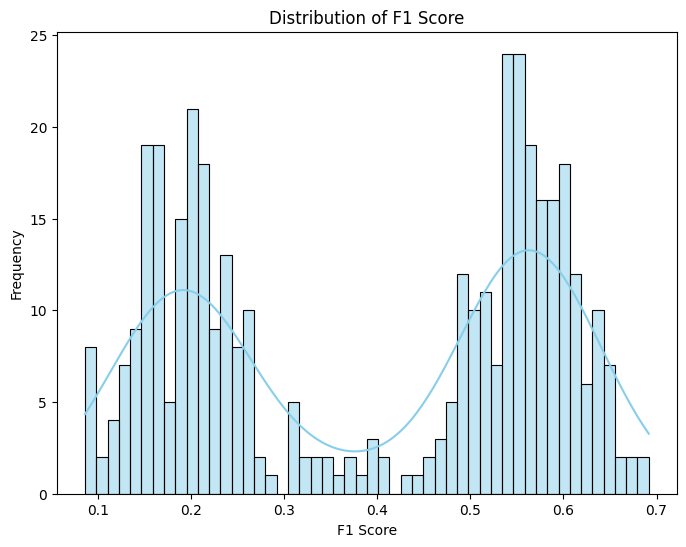

H0: The data is normally distributed
H1: The data is not normally distributed

Shapiro-Wilk Test: Statistics=0.8622, p-value=0.0000
Reject H0


In [289]:
# Example why parametric test is not suitable

# F1 Score distribution
plt.figure(figsize=(8,6))
sns.histplot(hogsvm_all_df["F1 Score"], bins=50, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of F1 Score")
plt.xlabel("F1 Score")
plt.ylabel("Frequency")
plt.show()

# Normality test using Ben Shapiro test on hogsvm_all_df
stat, p_value = stats.shapiro(hogsvm_all_df["F1 Score"])

print("H0: The data is normally distributed")
print("H1: The data is not normally distributed")

print(f'\nShapiro-Wilk Test: Statistics={stat:.4f}, p-value={p_value:.4f}')
print("Reject H0" if p_value < 0.05 else "Fail to Reject H0")

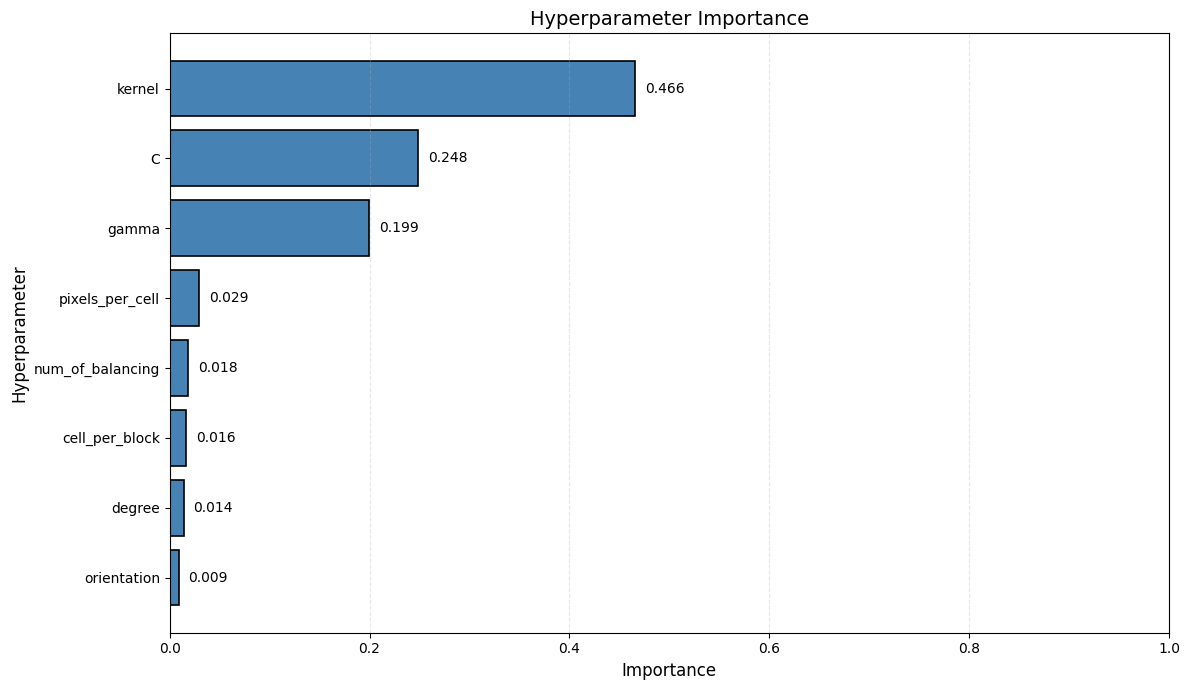

In [337]:
X = hogsvm_all_df.drop(columns=["Balanced Accuracy", "Precision", "Recall", "F1 Score"])
y = hogsvm_all_df["F1 Score"]

X["gamma"] = X["gamma"].replace("auto", 0)
X["degree"].fillna(0, inplace=True)
X["pixels_per_cell"] = X["pixels_per_cell"].apply(lambda x: int(x.strip("()").split(",")[0]) * int(x.strip("()").split(",")[1]))
X["cell_per_block"] = X["cell_per_block"].apply(lambda x: int(x.strip("()").split(",")[0]) * int(x.strip("()").split(",")[1]))

X[["C", "gamma", "degree", "num_of_balancing", "orientation", "pixels_per_cell", "cell_per_block"]] = X[["C", "gamma", "degree", "num_of_balancing", "orientation", "pixels_per_cell", "cell_per_block"]].astype(float)
X[["C", "gamma", "degree", "num_of_balancing", "orientation", "pixels_per_cell", "cell_per_block"]] = StandardScaler().fit_transform(X[["C", "gamma", "degree", "num_of_balancing", "orientation", "pixels_per_cell", "cell_per_block"]])

kernel_map = {kernel: i for i, kernel in enumerate(X["kernel"].unique())}
X["kernel"] = X["kernel"].map(kernel_map)

# Extra Trees Regressor as the model for hyperparameter importance
et = ExtraTreesRegressor(n_estimators=500)
et.fit(X, y)

# cross validate the model
result = permutation_importance(et, X, y, n_repeats=10)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance_df['Normalized'] = importance_df['Importance'] / importance_df['Importance'].sum()

plt.figure(figsize=(12, 7))
bars = plt.barh(importance_df['Feature'], importance_df['Normalized'], color='steelblue', edgecolor='black', linewidth=1.2)
for i, (bar, value) in enumerate(zip(bars, importance_df['Normalized'])):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Hyperparameter', fontsize=12)
plt.title('Hyperparameter Importance', fontsize=14)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#### Kernel

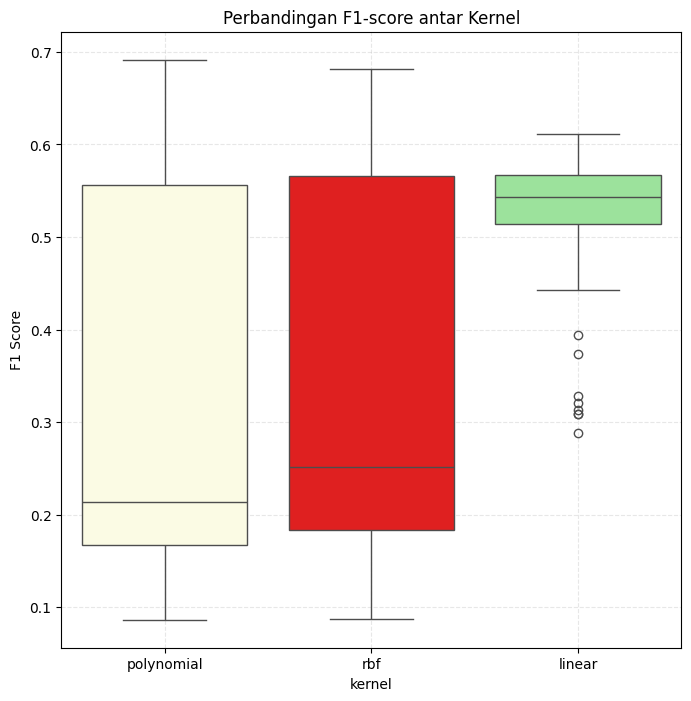

In [291]:
# Kernel BOXPLOT
thecolors = {
    "linear": "lightgreen",
    "polynomial": "lightyellow",
    "rbf": "red",
}
plt.figure(figsize=(8,8))
sns.boxplot(x="kernel", y="F1 Score", data=hogsvm_all_df, palette=thecolors)
plt.title("Perbandingan F1-score antar Kernel")
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [292]:
kruskal_kernel = kruskal_walis_test(hogsvm_all_df, groupby='kernel', y='F1 Score')
print(kruskal_kernel)

   H-statistic       p-value Significance
0    58.733399  1.762805e-13  Significant


In [293]:
dunn_kernel =costum_dunn_test(hogsvm_all_df, group='kernel', val_y='F1 Score', tail='right', alpha=0.05)


Z-table value: 2.1280

Dunn's Test Z-values:


linear polynomial      rbf
linear      0.0000    7.3742*  5.5711*
polynomial -7.3742        0.0  -1.4473
rbf        -5.5711     1.4473      0.0


Score-based Ranking from Dunn's Test:


Group  Score  rank
0      linear      2   1.0
1  polynomial      0   2.0
2         rbf      0   2.0

### Linear

In [294]:
linear_df = hogsvm_all_df[hogsvm_all_df["kernel"] == "linear"]
linear_df = linear_df.drop(columns=["kernel", "gamma", "degree"])

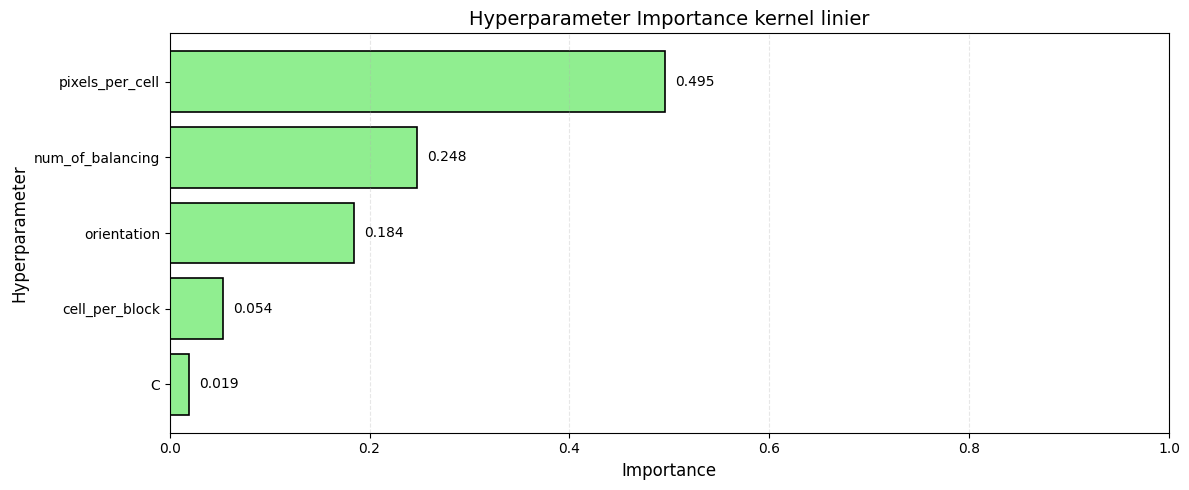

In [295]:
X = linear_df.drop(columns=["Balanced Accuracy", "Precision", "Recall", "F1 Score"])
y = linear_df["F1 Score"]

X[["C", "orientation", "num_of_balancing"]] = X[["C", "orientation", "num_of_balancing"]].astype(float)
X[["C", "orientation", "num_of_balancing"]] = StandardScaler().fit_transform(X[["C", "orientation", "num_of_balancing"]])

pixels_per_cell_map = {j:i for i,j in enumerate(sorted(linear_df["pixels_per_cell"].unique()))  }
X["pixels_per_cell"] = X["pixels_per_cell"].map(pixels_per_cell_map)
cell_per_block_map = {j:i for i,j in enumerate(sorted(linear_df["cell_per_block"].unique()))  }
X["cell_per_block"] = X["cell_per_block"].map(cell_per_block_map)

# Extra Trees Regressor as the model for hyperparameter importance
et = ExtraTreesRegressor(n_estimators=500)
et.fit(X, y)

# cross validate the model
result = permutation_importance(et, X, y, n_repeats=10)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance_df['Normalized'] = importance_df['Importance'] / importance_df['Importance'].sum()


plt.figure(figsize=(12, 5))
bars = plt.barh(importance_df['Feature'], importance_df['Normalized'], color='lightgreen', edgecolor='black', linewidth=1.2)
for i, (bar, value) in enumerate(zip(bars, importance_df['Normalized'])):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Hyperparameter', fontsize=12)
plt.title('Hyperparameter Importance kernel linier', fontsize=14)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#### C

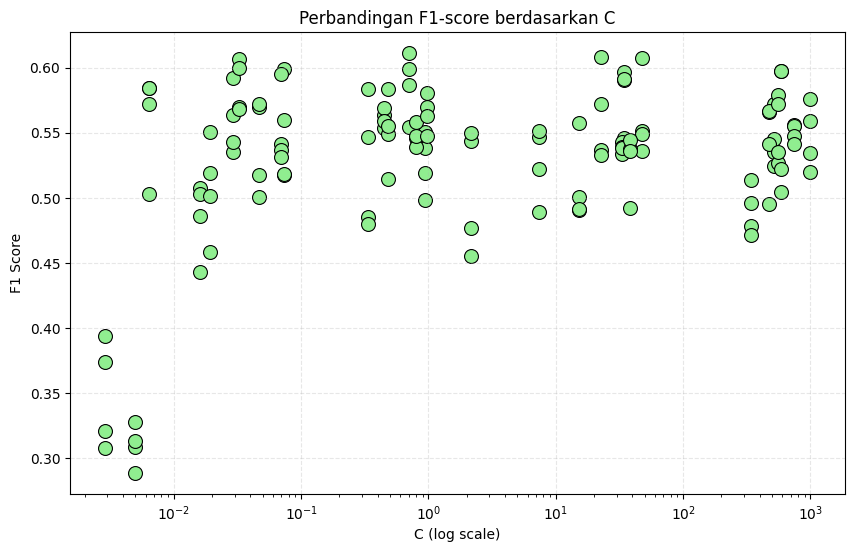

In [296]:
# Plot C vs F1 Score for linear kernel
plt.figure(figsize=(10,6))
sns.scatterplot(x="C", y="F1 Score", data=linear_df, color='lightgreen', s=100, edgecolor='black')
plt.xscale('log')
plt.title("Perbandingan F1-score berdasarkan C")
plt.xlabel("C (log scale)")
plt.ylabel("F1 Score")
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [297]:
'''
Factor 1: Linear
Factor 2: C Value
Y: F1 Score
'''
# C spearman Correlation Test
corr_c_linear, pvalue_c_linear = stats.spearmanr(linear_df["C"], linear_df["F1 Score"])

print(f'Significant: {pvalue_c_linear < 0.05}\nP-value: {pvalue_c_linear:.4f}\nCorrelation Coefficient: {corr_c_linear:.4f}')

Significant: False
P-value: 0.0620
Correlation Coefficient: 0.1654


#### Num Balancing

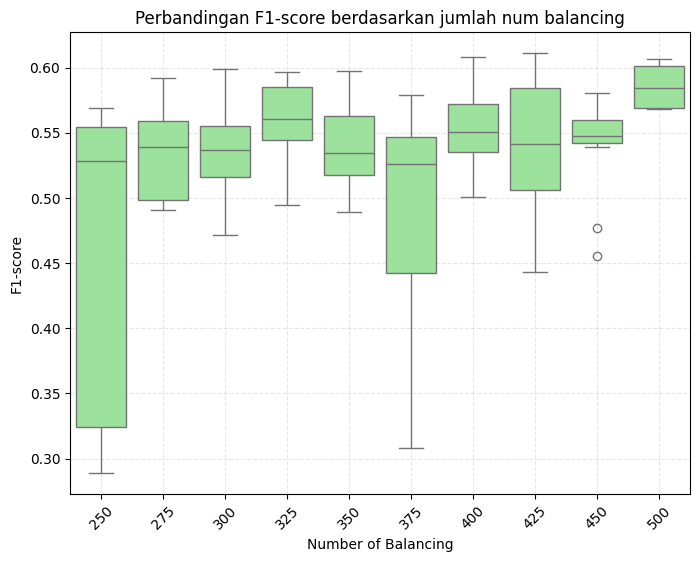

In [298]:
# Plot num_of_balancing vs F1 Score for linear kernel
plt.figure(figsize=(8,6))
sns.boxplot(x="num_of_balancing", y="F1 Score", data=linear_df, color='lightgreen')
plt.title("Perbandingan F1-score berdasarkan jumlah num balancing")
plt.xlabel("Number of Balancing")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [299]:
'''
Factor 1: Linear
Factor 2: num_of_balancing
Y: F1 Score
'''
# Num balancing kruskal the fuck out test and Dunn test
kruskal_num_linear = kruskal_walis_test(linear_df, groupby='num_of_balancing', y='F1 Score')
print(kruskal_num_linear)
if kruskal_num_linear["Significance"][0] == "Significant":
    dunn_num_linear = costum_dunn_test(linear_df, group='num_of_balancing', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value Significance
0    18.306517  0.031779  Significant

Z-table value: 3.0588

Dunn's Test Z-values:


250     275     300     325     350      375     400     425     450  \
250  0.0000 -0.6817 -0.8250 -2.3057 -1.0213   0.0985 -1.9480 -1.5383 -1.3977   
275  0.6817  0.0000  0.0660 -1.3806 -0.3100   0.8055 -1.0607 -0.6381 -0.5685   
300  0.8250 -0.0660  0.0000 -1.9031 -0.4527   1.0284 -1.4799 -0.9662 -0.8288   
325  2.3057  1.3806  1.9031  0.0000  1.0410   2.5634  0.3577  0.9265  0.9080   
350  1.0213  0.3100  0.4527 -1.0410  0.0000   1.1634 -0.7211 -0.2802 -0.2289   
375 -0.0985 -0.8055 -1.0284 -2.5634 -1.1634      0.0 -2.1810 -1.7680 -1.5928   
400  1.9480  1.0607  1.4799 -0.3577  0.7211    2.181  0.0000  0.5442  0.5503   
425  1.5383  0.6381  0.9662 -0.9265  0.2802    1.768 -0.5442  0.0000  0.0441   
450  1.3977  0.5685  0.8288 -0.9080  0.2289   1.5928 -0.5503 -0.0441  0.0000   
500  2.9611  2.2837  2.6658  1.3307  2.0305  3.1255*  1.5837  2.0073  1.9728   

        500  
250 -2.9611  
275 -2.2837  
300 -2.6658  
325 -1.3307  
350 -2.0305  
375 -3.1255  
400 -1.5837  
425 -2.0073  
450 -1.9728  
500  0.0000


Score-based Ranking from Dunn's Test:


Group  Score  rank
9    500      1   1.0
0    250      0   2.0
2    300      0   2.0
1    275      0   2.0
4    350      0   2.0
5    375      0   2.0
6    400      0   2.0
3    325      0   2.0
7    425      0   2.0
8    450      0   2.0

#### HOG HYPERAMETERS!

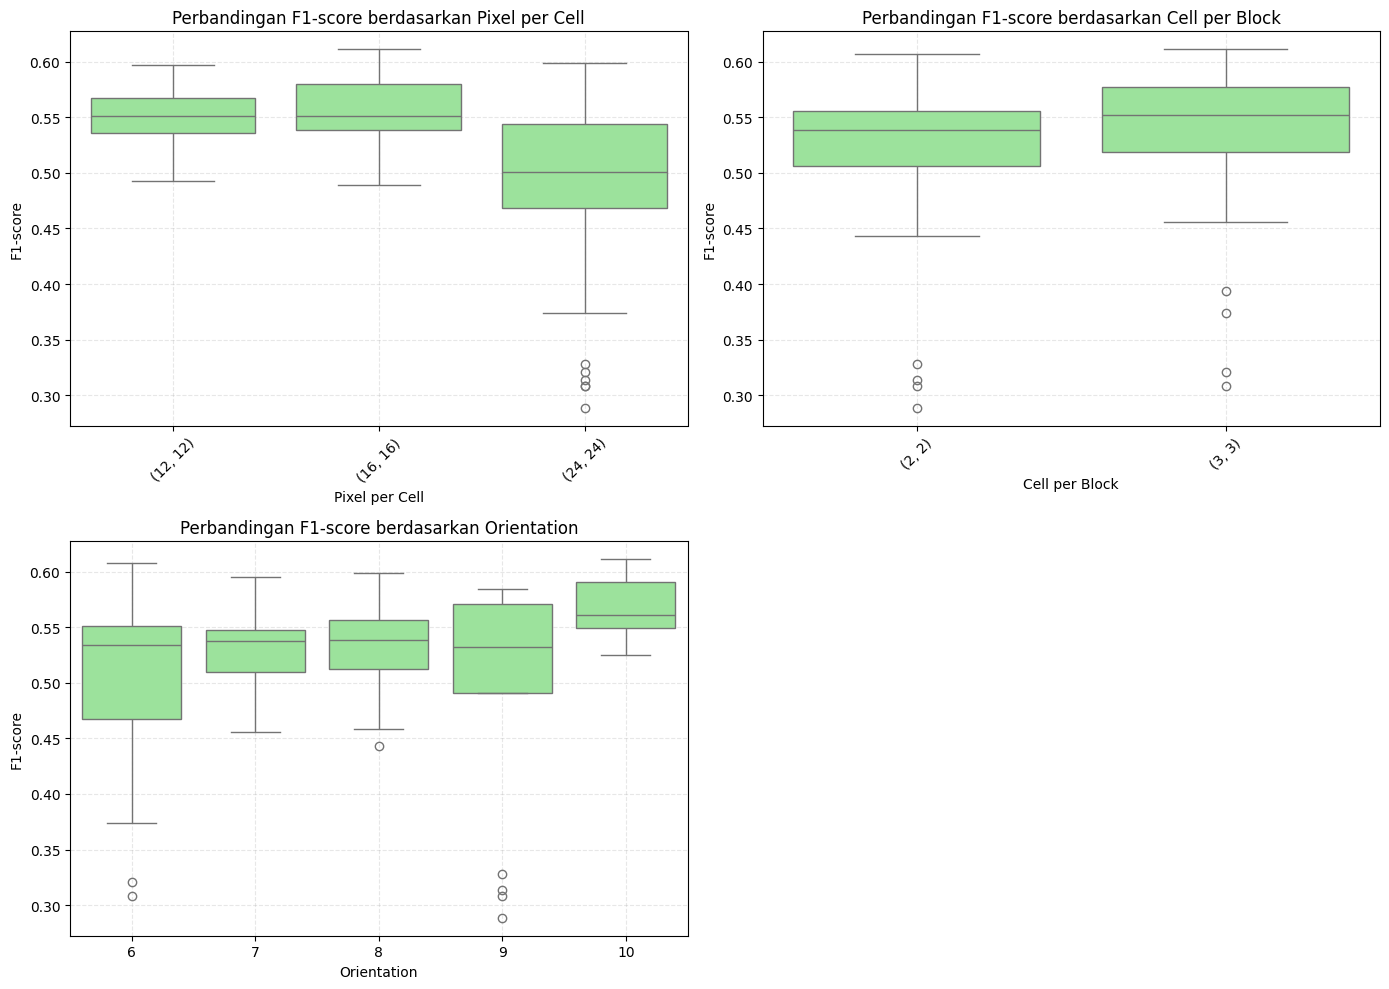

In [300]:
# HOG parameter PLOTS
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Pixel per cell
sns.boxplot(x="pixels_per_cell", y="F1 Score", data=linear_df.sort_values(by="pixels_per_cell", ascending=True), ax=axes[0, 0], color='lightgreen')
axes[0, 0].set_title("Perbandingan F1-score berdasarkan Pixel per Cell")
axes[0, 0].set_xlabel("Pixel per Cell")
axes[0, 0].set_ylabel("F1-score")
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

# Cell per block BOXPLOT
sns.boxplot(x="cell_per_block", y="F1 Score", data=linear_df.sort_values(by="cell_per_block", ascending=True), ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title("Perbandingan F1-score berdasarkan Cell per Block")
axes[0, 1].set_xlabel("Cell per Block")
axes[0, 1].set_ylabel("F1-score")
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, linestyle='--')

# Orientation BOXPLOT
sns.boxplot(x="orientation", y="F1 Score", data=linear_df, ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title("Perbandingan F1-score berdasarkan Orientation")
axes[1, 0].set_xlabel("Orientation")
axes[1, 0].set_ylabel("F1-score")
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

# Hide the fourth subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

##### Pixels per cell

In [301]:
'''
Factor 1: Linear
Factor 2: Pixels per cell
Y: F1 Score
'''
# Pixels per cell kruskal the fuck out test and Dunn test
kruskal_pixels_linear = kruskal_walis_test(linear_df, groupby='pixels_per_cell', y='F1 Score')
print(kruskal_pixels_linear)
if kruskal_pixels_linear["Significance"][0] == "Significant":
    dunn_pixels_linear = costum_dunn_test(linear_df, group='pixels_per_cell', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic       p-value Significance
0    33.497455  5.322553e-08  Significant

Z-table value: 2.1280

Dunn's Test Z-values:


(12, 12)  (16, 16) (24, 24)
(12, 12)    0.0000   -0.8205  4.4506*
(16, 16)    0.8205    0.0000  5.4012*
(24, 24)   -4.4506   -5.4012      0.0


Score-based Ranking from Dunn's Test:


Group  Score  rank
0  (12, 12)      1   1.0
1  (16, 16)      1   1.0
2  (24, 24)      0   3.0

##### Cell per block

In [302]:
'''
Factor 1: Linear
Factor 2: Cells per block
Y: F1 Score
'''
# Cells per block kruskal the fuck out test and Dunn test
kruskal_cellperblock_linear = kruskal_walis_test(linear_df, groupby='cell_per_block', y='F1 Score')
print(kruskal_cellperblock_linear)
if kruskal_cellperblock_linear["Significance"][0] == "Significant":
    dunn_cellperblock_linear = costum_dunn_test(linear_df, group='cell_per_block', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value Significance
0     4.589279  0.032173  Significant

Z-table value: 1.6449

Dunn's Test Z-values:


(2, 2)  (3, 3)
(2, 2)      0.0 -2.1423
(3, 3)  2.1423*  0.0000


Score-based Ranking from Dunn's Test:


Group  Score  rank
1  (3, 3)      1   1.0
0  (2, 2)      0   2.0

##### Orientation

In [303]:
'''
Factor 1: Linear
Factor 2: orientation
Y: F1 Score
'''
# Orientation kruskal the fuck out test and Dunn test
kruskal_orientation_linear = kruskal_walis_test(linear_df, groupby='orientation', y='F1 Score')
print(kruskal_orientation_linear)
if kruskal_orientation_linear["Significance"][0] == "Significant":
    dunn_orientation_linear = costum_dunn_test(linear_df, group='orientation', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value Significance
0    19.994285  0.000501  Significant

Z-table value: 2.5758

Dunn's Test Z-values:


6        7       8        9       10
6       0.0   -0.111 -0.5081  -0.3552 -3.3045
7     0.111      0.0 -0.4679  -0.2881 -3.7447
8    0.5081   0.4679     0.0   0.1203 -3.5040
9    0.3552   0.2881 -0.1203      0.0 -3.1304
10  3.3045*  3.7447*  3.504*  3.1304*  0.0000


Score-based Ranking from Dunn's Test:


Group  Score  rank
4     10      4   1.0
0      6      0   2.0
2      8      0   2.0
1      7      0   2.0
3      9      0   2.0

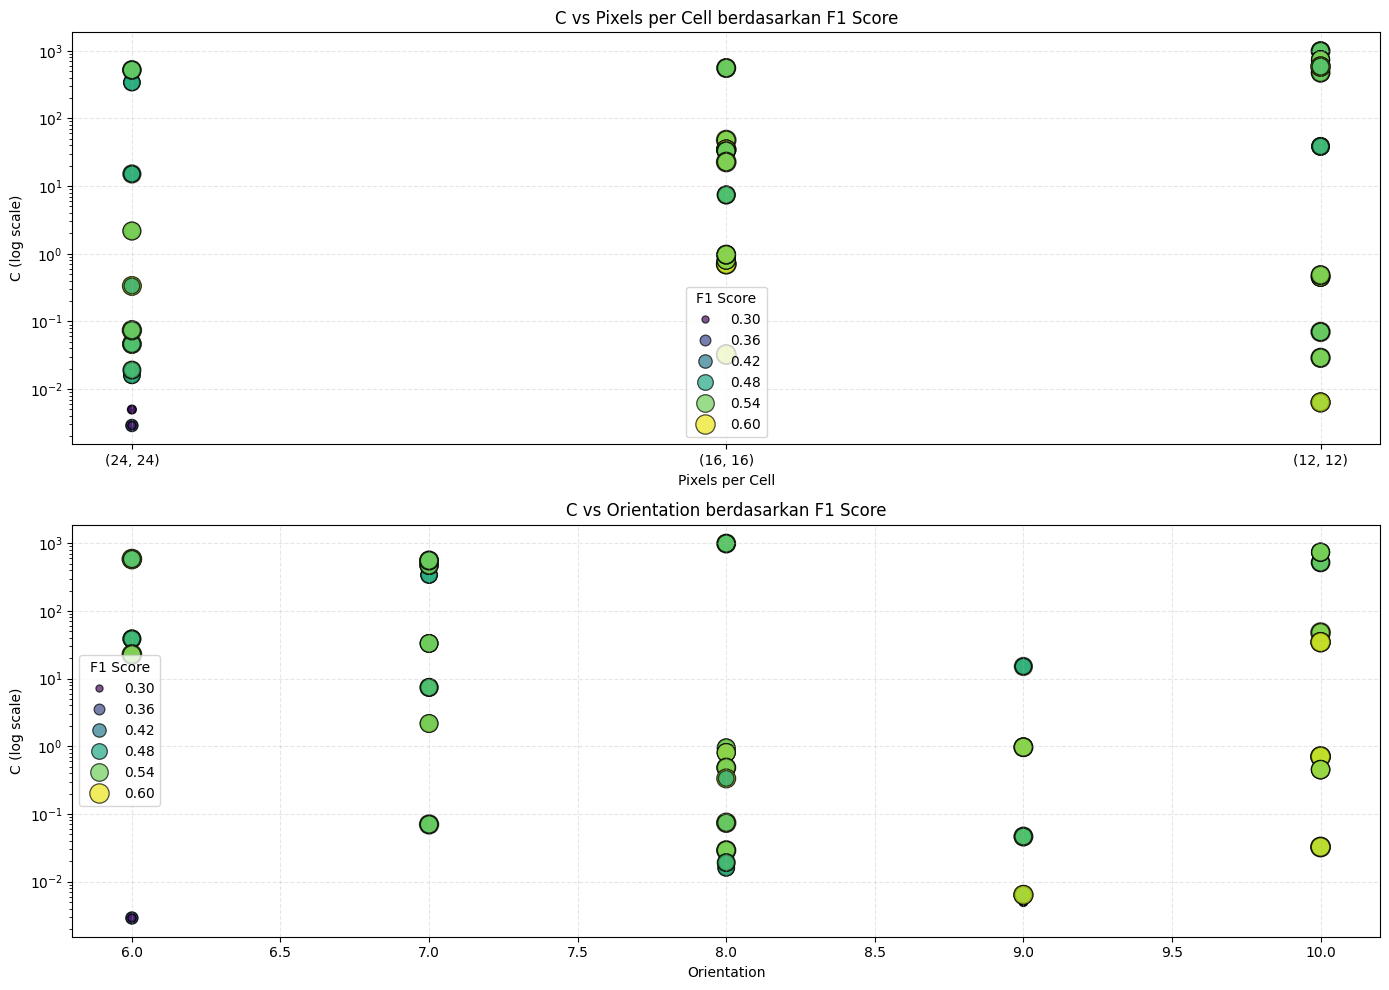

In [304]:
fig, axes = plt.subplots(2,1, figsize=(14, 10))

# Scatter C vs pixels_per_cell
sns.scatterplot(x="pixels_per_cell", y="C", size="F1 Score", sizes=(20, 200), hue="F1 Score", data=linear_df, palette="viridis", edgecolor='black', alpha=0.7, ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_title("C vs Pixels per Cell berdasarkan F1 Score")
axes[0].set_xlabel("Pixels per Cell")
axes[0].set_ylabel("C (log scale)")
axes[0].grid(True, alpha=0.3, linestyle='--')

# Scatter C vs Orientation
sns.scatterplot(x="orientation", y="C", size="F1 Score", sizes=(20, 200), hue="F1 Score", data=linear_df, palette="viridis", edgecolor='black', alpha=0.7, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title("C vs Orientation berdasarkan F1 Score")
axes[1].set_xlabel("Orientation")
axes[1].set_ylabel("C (log scale)")
axes[1].grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### Polynomial

In [305]:
poly_df = hogsvm_all_df[hogsvm_all_df["kernel"] == "polynomial"]
poly_df = poly_df.drop(columns=["kernel"])
poly_df["gamma"] = pd.to_numeric(poly_df["gamma"], errors='coerce')

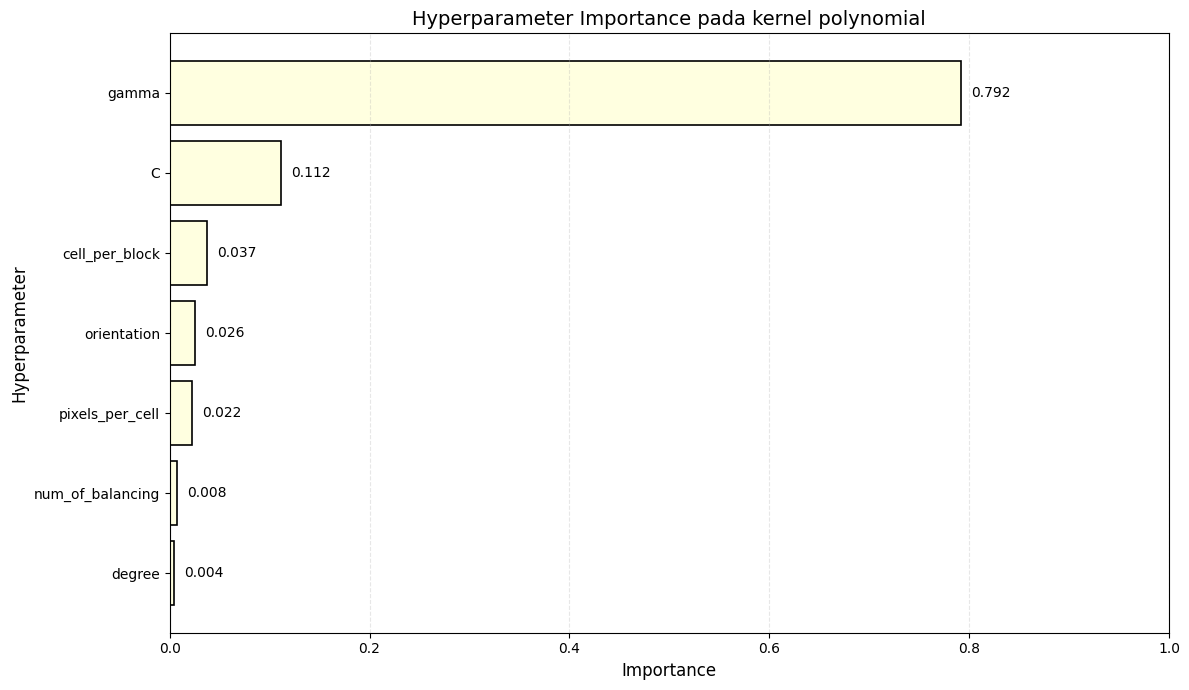

In [306]:
X = poly_df.drop(columns=["Balanced Accuracy", "Precision", "Recall", "F1 Score"])
y = poly_df["F1 Score"]

X[["C", "gamma", "degree", "num_of_balancing","orientation"]] = X[["C", "gamma", "degree", "num_of_balancing","orientation"]].astype(float)
X[["C", "gamma", "degree", "num_of_balancing","orientation"]] = StandardScaler().fit_transform(X[["C", "gamma", "degree", "num_of_balancing","orientation"]])

pixels_per_cell_map = {j:i for i,j in enumerate(sorted(poly_df["pixels_per_cell"].unique()))  }
X["pixels_per_cell"] = X["pixels_per_cell"].map(pixels_per_cell_map)
cell_per_block_map = {j:i for i,j in enumerate(sorted(poly_df["cell_per_block"].unique()))  }
X["cell_per_block"] = X["cell_per_block"].map(cell_per_block_map)

# Extra Trees Regressor as the model for hyperparameter importance
et = ExtraTreesRegressor(n_estimators=500)
et.fit(X, y)

# cross validate the model
result = permutation_importance(et, X, y, n_repeats=10)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance_df['Normalized'] = importance_df['Importance'] / importance_df['Importance'].sum()


plt.figure(figsize=(12, 7))
bars = plt.barh(importance_df['Feature'], importance_df['Normalized'], color='lightyellow', edgecolor='black', linewidth=1.2)
for i, (bar, value) in enumerate(zip(bars, importance_df['Normalized'])):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Hyperparameter', fontsize=12)
plt.title('Hyperparameter Importance pada kernel polynomial', fontsize=14)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#### C

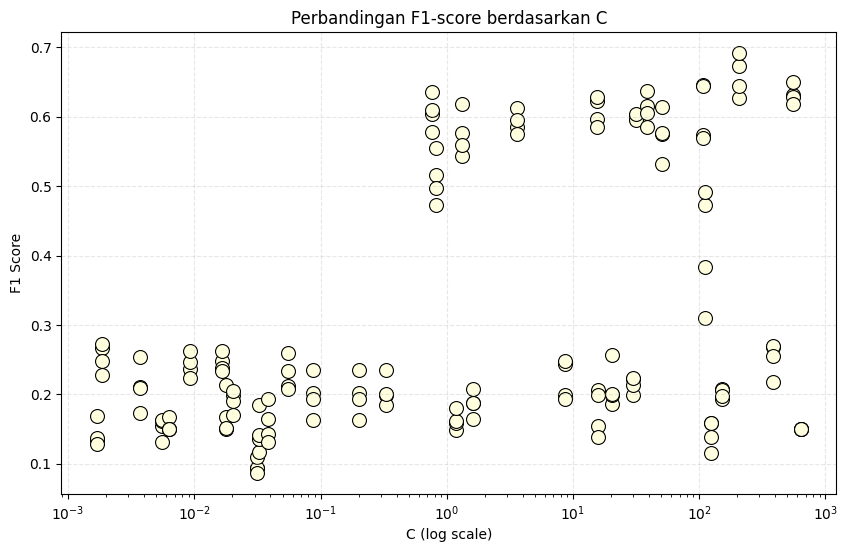

In [307]:
# Plot C vs F1 Score for polynomial kernel
plt.figure(figsize=(10,6))
sns.scatterplot(x="C", y="F1 Score", data=poly_df, color='lightyellow', s=100, edgecolor='black')
plt.xscale('log')
plt.title("Perbandingan F1-score berdasarkan C")
plt.xlabel("C (log scale)")
plt.ylabel("F1 Score")
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [308]:
'''
Factor 1: Polynomial
Factor 2: C Value
Y: F1 Score
'''
# C spearman Correlation Test
corr_c_poly, pvalue_c_poly = stats.spearmanr(poly_df["C"], poly_df["F1 Score"])

print(f'Significant: {pvalue_c_poly < 0.05}\nP-value: {pvalue_c_poly:.4f}\nCorrelation Coefficient: {corr_c_poly:.4f}')

Significant: True
P-value: 0.0000
Correlation Coefficient: 0.4046


#### Num Balancing

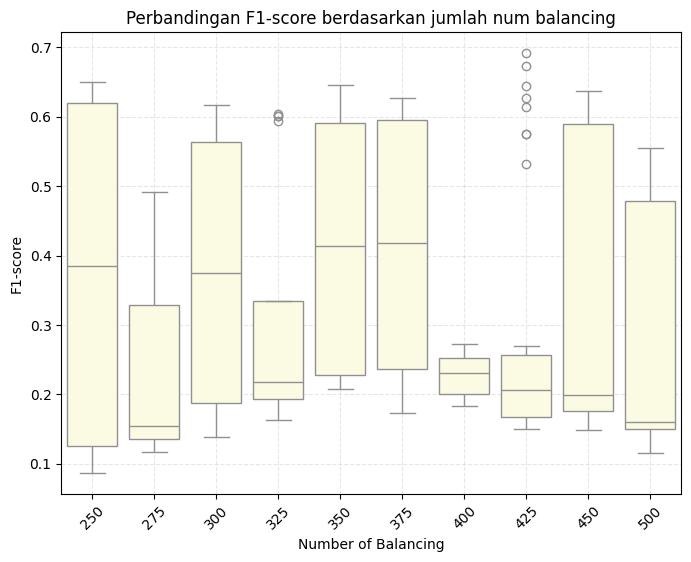

In [309]:
# Plot num_of_balancing vs F1 Score for polynomial kernel
plt.figure(figsize=(8,6))
sns.boxplot(x="num_of_balancing", y="F1 Score", data=poly_df, color='lightyellow')
plt.title("Perbandingan F1-score berdasarkan jumlah num balancing")
plt.xlabel("Number of Balancing")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [310]:
'''
Factor 1: Polynomial
Factor 2: num_of_balancing
Y: F1 Score
'''
# Num balancing kruskal the fuck out test and Dunn test
kruskal_num_poly = kruskal_walis_test(poly_df, groupby='num_of_balancing', y='F1 Score')
print(kruskal_num_poly)
if kruskal_num_poly["Significance"][0] == "Significant":
    dunn_num_poly = costum_dunn_test(poly_df, group='num_of_balancing', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value Significance
0    20.443284  0.015365  Significant

Z-table value: 3.0588

Dunn's Test Z-values:


250      275     300     325     350     375     400     425     450  \
250  0.0000   1.7281 -0.2443 -0.2450 -1.5820 -1.8291 -0.1197  0.4335 -0.0415   
275 -1.7281      0.0 -1.6776 -1.9549 -2.9466 -3.4215 -1.5594 -1.6378 -1.6553   
300  0.2443   1.6776  0.0000  0.0443 -1.1585 -1.2492  0.1079  0.6044  0.1970   
325  0.2450   1.9549 -0.0443  0.0000 -1.3820 -1.5841  0.0803  0.7301  0.1853   
350  1.5820   2.9466  1.1585  1.3820  0.0000  0.0885  1.2664  2.1115  1.4661   
375  1.8291  3.4215*  1.2492  1.5841 -0.0885  0.0000  1.3738  2.6486  1.6519   
400  0.1197   1.5594 -0.1079 -0.0803 -1.2664 -1.3738  0.0000  0.4641  0.0788   
425 -0.4335   1.6378 -0.6044 -0.7301 -2.1115 -2.6486 -0.4641  0.0000 -0.4373   
450  0.0415   1.6553 -0.1970 -0.1853 -1.4661 -1.6519 -0.0788  0.4373  0.0000   
500 -1.4827   0.2295 -1.4723 -1.7095 -2.7413 -3.1762 -1.3541 -1.3501 -1.4258   

         500  
250   1.4827  
275  -0.2295  
300   1.4723  
325   1.7095  
350   2.7413  
375  3.1762*  
400   1.3541  
425   1.3501  
450   1.4258  
500      0.0


Score-based Ranking from Dunn's Test:


Group  Score  rank
5    375      2   1.0
0    250      0   2.0
2    300      0   2.0
1    275      0   2.0
3    325      0   2.0
4    350      0   2.0
6    400      0   2.0
7    425      0   2.0
8    450      0   2.0
9    500      0   2.0

#### Gamma

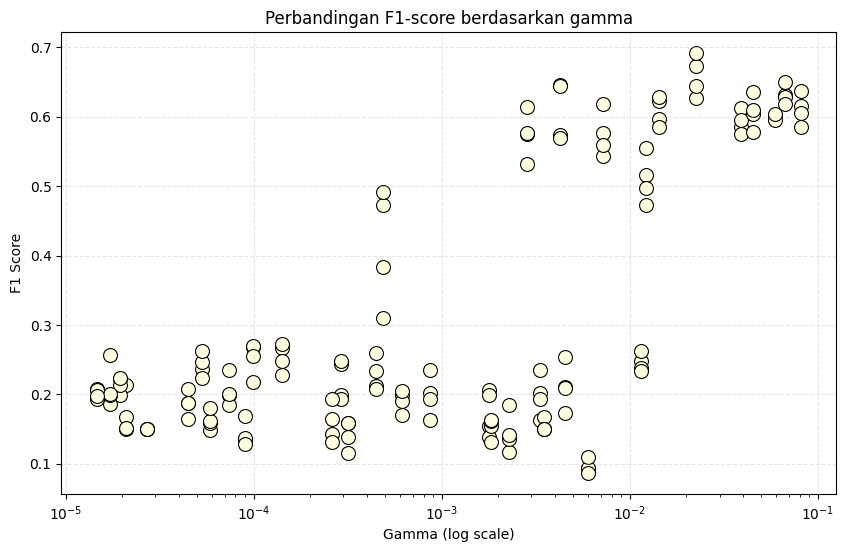

In [311]:
# Scatter gamma vs f1 score fur das poly kernel

plt.figure(figsize=(10,6))
sns.scatterplot(x="gamma", y="F1 Score", data=poly_df, color='lightyellow', s=100, edgecolor='black')
plt.xscale('log')
plt.title("Perbandingan F1-score berdasarkan gamma")
plt.xlabel("Gamma (log scale)")
plt.ylabel("F1 Score")
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [312]:
'''
Factor 1: Poly
Factor 2: gamma
Y: F1 Score
'''
# Gamma spearman Correlation Test
corr_gamma_poly, pvalue_gamma_poly = stats.spearmanr(pd.to_numeric(poly_df["gamma"], errors='coerce'), poly_df["F1 Score"])

print(f'Significant: {pvalue_gamma_poly < 0.05}\nP-value: {pvalue_gamma_poly:.4f}\nCorrelation Coefficient: {corr_gamma_poly:.4f}')

Significant: True
P-value: 0.0000
Correlation Coefficient: 0.5515


#### Degree

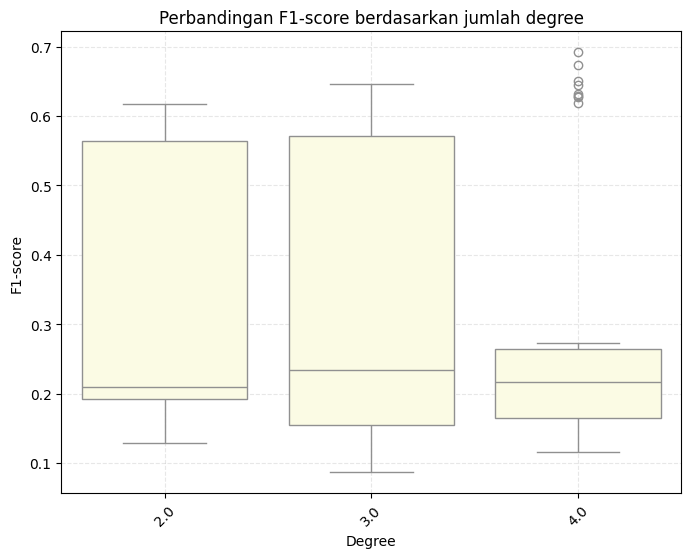

In [313]:
# boxplot derajat vs f1 score fur das poly kernel

plt.figure(figsize=(8,6))
sns.boxplot(x="degree", y="F1 Score", data=poly_df, color='lightyellow')
plt.title("Perbandingan F1-score berdasarkan jumlah degree")
plt.xlabel("Degree")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [314]:
'''
Factor 1: Poly
Factor 2: degree
Y: F1 Score
'''
# Kruskal and dunn test for degree
kruskal_degree_poly = kruskal_walis_test(poly_df, groupby='degree', y='F1 Score')

print(kruskal_degree_poly)
if kruskal_degree_poly["Significance"][0] == "Significant":
    dunn_degree_poly = costum_dunn_test(poly_df, group='degree', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value     Significance
0     0.218119  0.896677  Not significant


#### HOG Hyperparameters

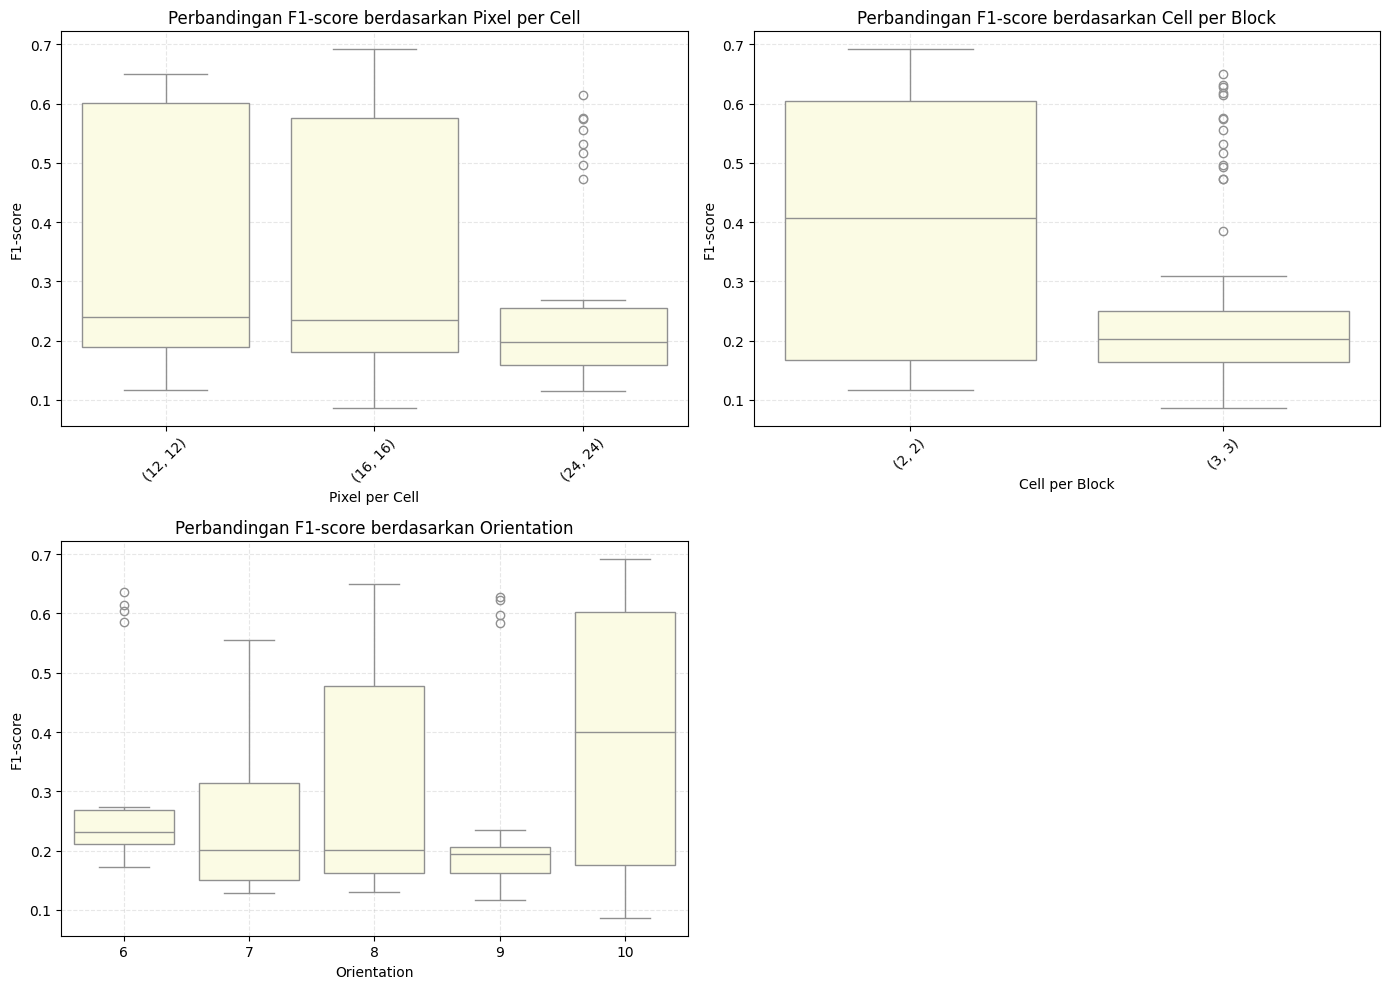

In [315]:
# HOG parameter PLOTS
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Pixel per cell
sns.boxplot(x="pixels_per_cell", y="F1 Score", data=poly_df.sort_values(by="pixels_per_cell", ascending=True), ax=axes[0, 0], color='lightyellow')
axes[0, 0].set_title("Perbandingan F1-score berdasarkan Pixel per Cell")
axes[0, 0].set_xlabel("Pixel per Cell")
axes[0, 0].set_ylabel("F1-score")
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

# Cell per block BOXPLOT
sns.boxplot(x="cell_per_block", y="F1 Score", data=poly_df.sort_values(by="cell_per_block", ascending=True), ax=axes[0, 1], color='lightyellow')
axes[0, 1].set_title("Perbandingan F1-score berdasarkan Cell per Block")
axes[0, 1].set_xlabel("Cell per Block")
axes[0, 1].set_ylabel("F1-score")
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, linestyle='--')

# Orientation BOXPLOT
sns.boxplot(x="orientation", y="F1 Score", data=poly_df, ax=axes[1, 0], color='lightyellow')
axes[1, 0].set_title("Perbandingan F1-score berdasarkan Orientation")
axes[1, 0].set_xlabel("Orientation")
axes[1, 0].set_ylabel("F1-score")
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

# Hide the fourth subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

##### Pixels per cell

In [316]:
'''
Factor 1: Polynomial
Factor 2: Pixels per cell
Y: F1 Score
'''
# Pixels per cell kruskal the fuck out test and Dunn test
kruskal_pixels_poly = kruskal_walis_test(poly_df, groupby='pixels_per_cell', y='F1 Score')
print(kruskal_pixels_poly)
if kruskal_pixels_poly["Significance"][0] == "Significant":
    dunn_pixels_poly = costum_dunn_test(poly_df, group='pixels_per_cell', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value Significance
0     8.819296  0.012159  Significant

Z-table value: 2.1280

Dunn's Test Z-values:


(12, 12)  (16, 16) (24, 24)
(12, 12)    0.0000    0.8409  2.8947*
(16, 16)   -0.8409    0.0000   2.0709
(24, 24)   -2.8947   -2.0709      0.0


Score-based Ranking from Dunn's Test:


Group  Score  rank
0  (12, 12)      1   1.0
1  (16, 16)      0   2.0
2  (24, 24)      0   2.0

##### Cell per block

In [317]:
'''
Factor 1: Polynomial
Factor 2: Cells per block
Y: F1 Score
'''
# Cells per block kruskal the fuck out test and Dunn test
kruskal_cellperblock_poly = kruskal_walis_test(poly_df, groupby='cell_per_block', y='F1 Score')
print(kruskal_cellperblock_poly)
if kruskal_cellperblock_poly["Significance"][0] == "Significant":
    dunn_cellperblock_poly = costum_dunn_test(poly_df, group='cell_per_block', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value Significance
0    11.917288  0.000556  Significant

Z-table value: 1.6449

Dunn's Test Z-values:


(2, 2)   (3, 3)
(2, 2)  0.0000  3.4519*
(3, 3) -3.4519      0.0


Score-based Ranking from Dunn's Test:


Group  Score  rank
0  (2, 2)      1   1.0
1  (3, 3)      0   2.0

##### Orientation

In [318]:
'''
Factor 1: Polynomial
Factor 2: orientation
Y: F1 Score
'''
# Orientation kruskal the fuck out test and Dunn test
kruskal_orientation_poly = kruskal_walis_test(poly_df, groupby='orientation', y='F1 Score')
print(kruskal_orientation_poly)
if kruskal_orientation_poly["Significance"][0] == "Significant":
    dunn_orientation_poly = costum_dunn_test(poly_df, group='orientation', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value Significance
0    14.774579  0.005192  Significant

Z-table value: 2.5758

Dunn's Test Z-values:


6       7       8        9       10
6   0.0000  2.0381  1.4186  2.7008*  0.1209
7  -2.0381  0.0000 -0.9584   0.2817 -2.2566
8  -1.4186  0.9584  0.0000   1.5403 -1.6484
9  -2.7008 -0.2817 -1.5403      0.0 -3.2323
10 -0.1209  2.2566  1.6484  3.2323*  0.0000


Score-based Ranking from Dunn's Test:


Group  Score  rank
0      6      1   1.0
4     10      1   1.0
2      8      0   3.0
1      7      0   3.0
3      9      0   3.0

### RBF

In [319]:
rbf_df = hogsvm_all_df[hogsvm_all_df["kernel"] == "rbf"]
rbf_df = rbf_df.drop(columns=["kernel", "degree"])
rbf_df["gamma"] = pd.to_numeric(rbf_df["gamma"], errors='coerce')

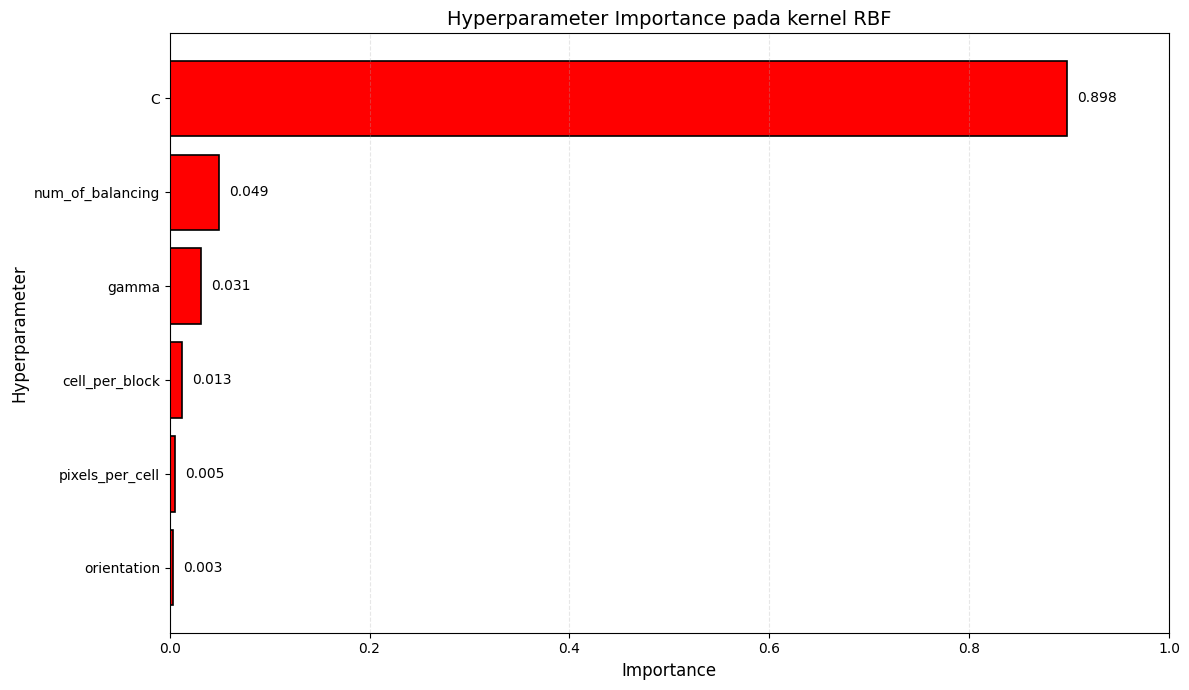

In [320]:
X = rbf_df.drop(columns=["Balanced Accuracy", "Precision", "Recall", "F1 Score"])
y = rbf_df["F1 Score"]

X[["C", "gamma", "num_of_balancing","orientation"]] = X[["C", "gamma", "num_of_balancing","orientation"]].astype(float)
X[["C", "gamma", "num_of_balancing","orientation"]] = StandardScaler().fit_transform(X[["C", "gamma", "num_of_balancing","orientation"]])

pixels_per_cell_map = {j:i for i,j in enumerate(sorted(linear_df["pixels_per_cell"].unique()))  }
X["pixels_per_cell"] = X["pixels_per_cell"].map(pixels_per_cell_map)
cell_per_block_map = {j:i for i,j in enumerate(sorted(linear_df["cell_per_block"].unique()))  }
X["cell_per_block"] = X["cell_per_block"].map(cell_per_block_map)

# Extra Trees Regressor as the model for hyperparameter importance
et = ExtraTreesRegressor(n_estimators=500)
et.fit(X, y)

# cross validate the model
result = permutation_importance(et, X, y, n_repeats=10)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance_df['Normalized'] = importance_df['Importance'] / importance_df['Importance'].sum()

plt.figure(figsize=(12, 7))
bars = plt.barh(importance_df['Feature'], importance_df['Normalized'], color='RED', edgecolor='black', linewidth=1.2)
for i, (bar, value) in enumerate(zip(bars, importance_df['Normalized'])):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Hyperparameter', fontsize=12)
plt.title('Hyperparameter Importance pada kernel RBF', fontsize=14)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#### C

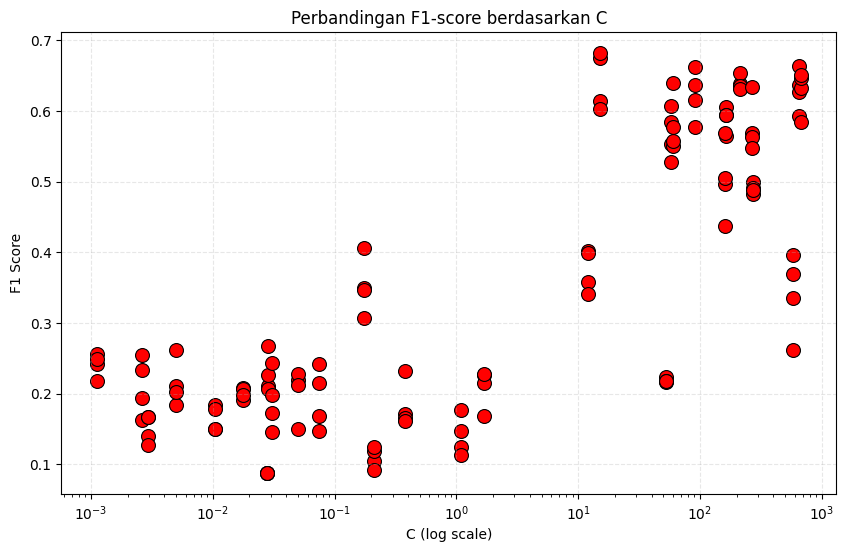

In [321]:
# Plot C vs F1 Score for RBF kernel
plt.figure(figsize=(10,6))
sns.scatterplot(x="C", y="F1 Score", data=rbf_df, color='red', s=100, edgecolor='black')
plt.xscale('log')
plt.title("Perbandingan F1-score berdasarkan C")
plt.xlabel("C (log scale)")
plt.ylabel("F1 Score")
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [322]:
'''
Factor 1: RBF
Factor 2: C Value
Y: F1 Score
'''
# C spearman Correlation Test
corr_c_rbf, pvalue_c_rbf = stats.spearmanr(rbf_df["C"], rbf_df["F1 Score"])

print(f'Significant: {pvalue_c_rbf < 0.05}\nP-value: {pvalue_c_rbf:.4f}\nCorrelation Coefficient: {corr_c_rbf:.4f}')

Significant: True
P-value: 0.0000
Correlation Coefficient: 0.7218


#### Num Balancing

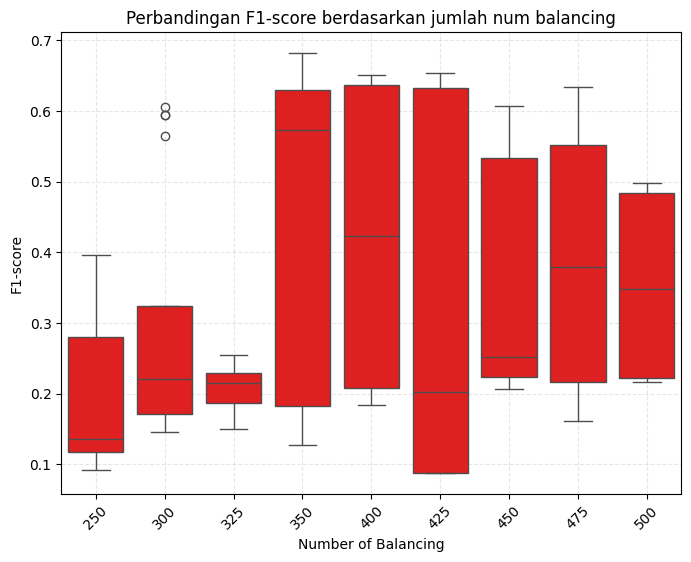

In [323]:
# Plot num_of_balancing vs F1 Score for RBF kernel
plt.figure(figsize=(8,6))
sns.boxplot(x="num_of_balancing", y="F1 Score", data=rbf_df, color='red')
plt.title("Perbandingan F1-score berdasarkan jumlah num balancing")
plt.xlabel("Number of Balancing")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [324]:
'''
Factor 1: RBF
Factor 2: num_of_balancing
Y: F1 Score
'''
# Num balancing kruskal the fuck out test and Dunn test
kruskal_num_rbf = kruskal_walis_test(rbf_df, groupby='num_of_balancing', y='F1 Score')
print(kruskal_num_rbf)
if kruskal_num_rbf["Significance"][0] == "Significant":
    dunn_num_rbf = costum_dunn_test(rbf_df, group='num_of_balancing', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value Significance
0    22.529992  0.004023  Significant

Z-table value: 2.9913

Dunn's Test Z-values:


250     300     325     350     400     425     450     475     500
250      0.0 -1.6515 -0.7086 -3.9443 -2.8382 -1.3614 -2.5028 -2.4588 -2.4969
300   1.6515  0.0000  0.7095 -2.3302 -1.5353  0.1960 -1.0241 -0.9771 -1.0178
325   0.7086 -0.7095  0.0000 -2.5880 -1.9441 -0.5091 -1.5300 -1.4906 -1.5247
350  3.9443*  2.3302  2.5880  0.0000  0.1633  2.3334  0.9830  1.0350  0.9899
400   2.8382  1.5353  1.9441 -0.1633  0.0000  1.6205  0.5997  0.6390  0.6049
425   1.3614 -0.1960  0.5091 -2.3334 -1.6205  0.0000 -1.1414 -1.0973 -1.1355
450   2.5028  1.0241  1.5300 -0.9830 -0.5997  1.1414  0.0000  0.0440  0.0059
475   2.4588  0.9771  1.4906 -1.0350 -0.6390  1.0973 -0.0440  0.0000 -0.0381
500   2.4969  1.0178  1.5247 -0.9899 -0.6049  1.1355 -0.0059  0.0381  0.0000


Score-based Ranking from Dunn's Test:


Group  Score  rank
3    350      1   1.0
0    250      0   2.0
1    300      0   2.0
2    325      0   2.0
4    400      0   2.0
5    425      0   2.0
6    450      0   2.0
7    475      0   2.0
8    500      0   2.0

#### Gamma

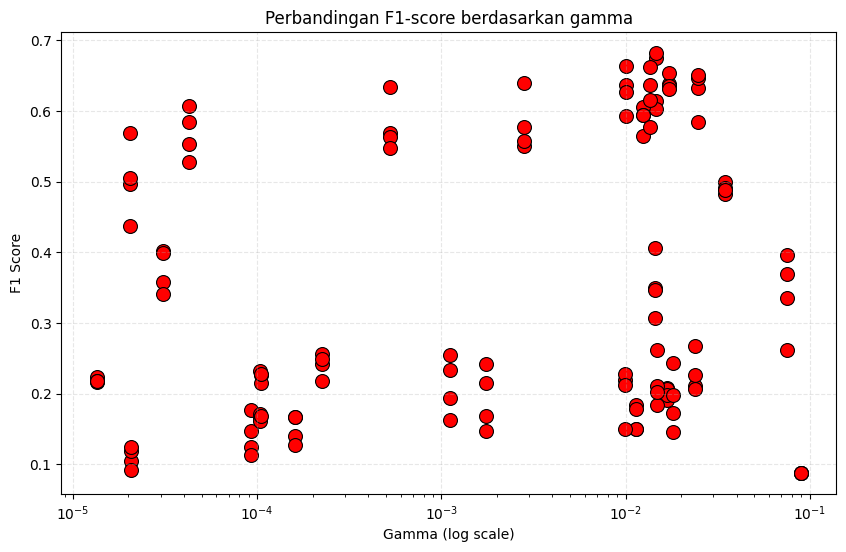

In [325]:
# Scatter gamma vs f1 score fur das RBF kernel

plt.figure(figsize=(10,6))
sns.scatterplot(x="gamma", y="F1 Score", data=rbf_df, color='red', s=100, edgecolor='black')
plt.xscale('log')
plt.title("Perbandingan F1-score berdasarkan gamma")
plt.xlabel("Gamma (log scale)")
plt.ylabel("F1 Score")
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [327]:
'''
Factor 1: RBF
Factor 2: gamma
Y: F1 Score
'''
# Gamma spearman Correlation Test
corr_gamma_rbf, pvalue_gamma_rbf = stats.spearmanr(pd.to_numeric(rbf_df["gamma"], errors='coerce'), rbf_df["F1 Score"])

print(f'Significant: {pvalue_gamma_rbf < 0.05}\nP-value: {pvalue_gamma_rbf:.4f}\nCorrelation Coefficient: {corr_gamma_rbf:.4f}')

Significant: False
P-value: 0.0701
Correlation Coefficient: 0.1659


#### HOG Hyperparameters

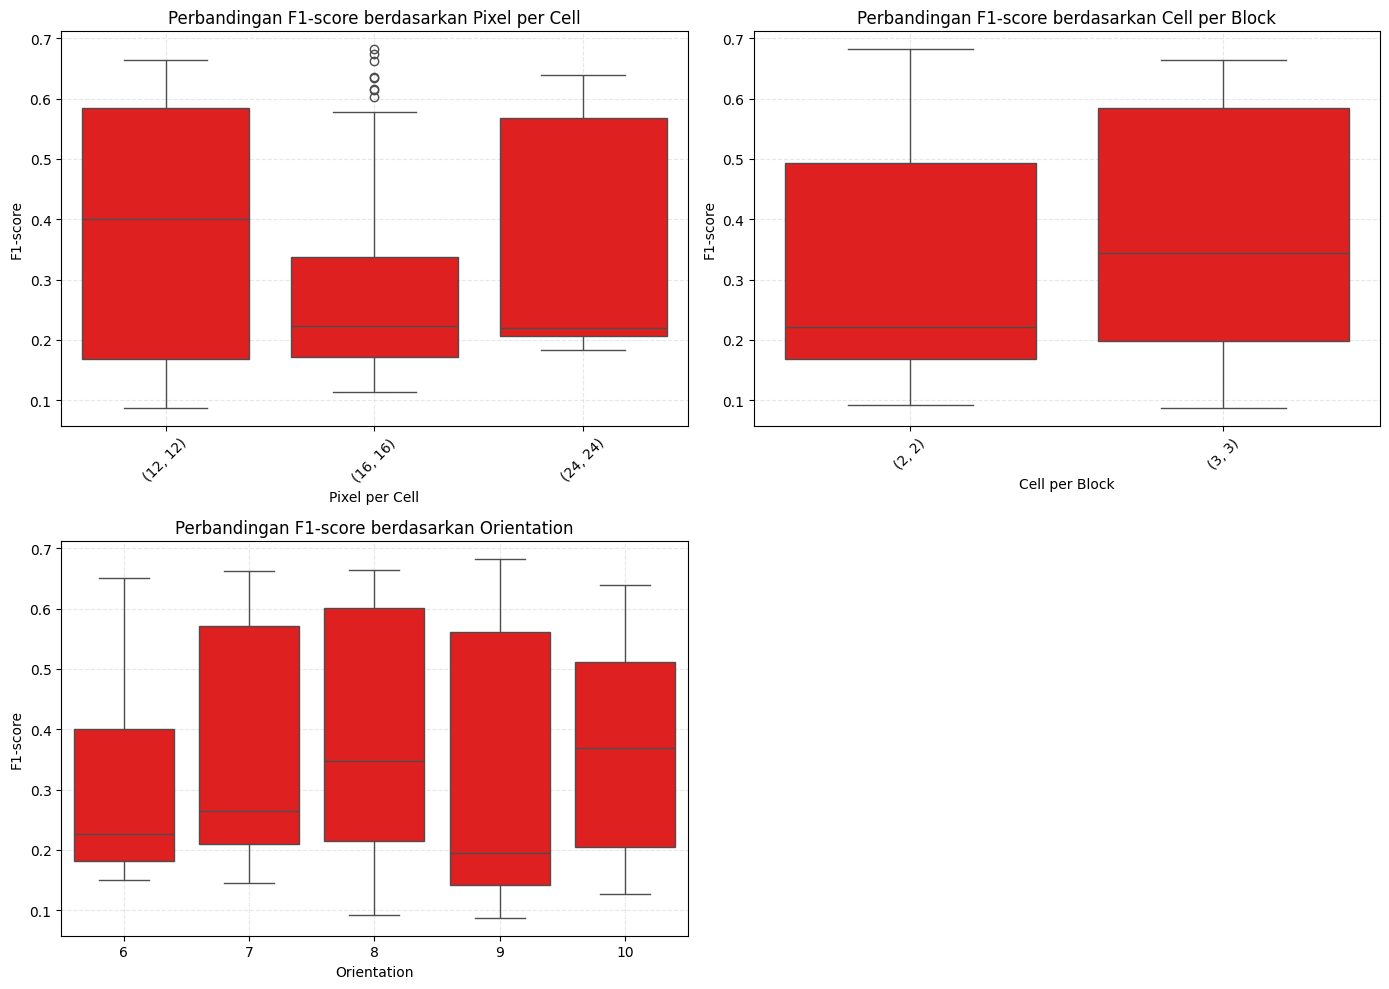

In [328]:
# HOG parameter PLOTS
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Pixel per cell
sns.boxplot(x="pixels_per_cell", y="F1 Score", data=rbf_df.sort_values(by="pixels_per_cell", ascending=True), ax=axes[0, 0], color='red')
axes[0, 0].set_title("Perbandingan F1-score berdasarkan Pixel per Cell")
axes[0, 0].set_xlabel("Pixel per Cell")
axes[0, 0].set_ylabel("F1-score")
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

# Cell per block BOXPLOT
sns.boxplot(x="cell_per_block", y="F1 Score", data=rbf_df.sort_values(by="cell_per_block", ascending=True), ax=axes[0, 1], color='red')
axes[0, 1].set_title("Perbandingan F1-score berdasarkan Cell per Block")
axes[0, 1].set_xlabel("Cell per Block")
axes[0, 1].set_ylabel("F1-score")
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, linestyle='--')

# Orientation BOXPLOT
sns.boxplot(x="orientation", y="F1 Score", data=rbf_df, ax=axes[1, 0], color='red')
axes[1, 0].set_title("Perbandingan F1-score berdasarkan Orientation")
axes[1, 0].set_xlabel("Orientation")
axes[1, 0].set_ylabel("F1-score")
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

# Hide the fourth subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

##### Pixels per cell

In [329]:
'''
Factor 1: RBF
Factor 2: Pixels per cell
Y: F1 Score
'''
# Pixels per cell kruskal the fuck out test and Dunn test
kruskal_pixels_rbf = kruskal_walis_test(rbf_df, groupby='pixels_per_cell', y='F1 Score')
print(kruskal_pixels_rbf)
if kruskal_pixels_rbf["Significance"][0] == "Significant":
    dunn_pixels_rbf = costum_dunn_test(rbf_df, group='pixels_per_cell', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value     Significance
0     3.206244  0.201267  Not significant


##### Cell per block

In [330]:
'''
Factor 1: RBF
Factor 2: Cells per block
Y: F1 Score
'''
# Cells per block kruskal the fuck out test and Dunn test
kruskal_cellperblock_rbf = kruskal_walis_test(rbf_df, groupby='cell_per_block', y='F1 Score')
print(kruskal_cellperblock_rbf)
if kruskal_cellperblock_rbf["Significance"][0] == "Significant":
    dunn_cellperblock_rbf = costum_dunn_test(rbf_df, group='cell_per_block', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value     Significance
0     2.820469  0.093069  Not significant


##### Orientation

In [331]:
'''
Factor 1: RBF
Factor 2: orientation
Y: F1 Score
'''
# Orientation kruskal the fuck out test and Dunn test
kruskal_orientation_rbf = kruskal_walis_test(rbf_df, groupby='orientation', y='F1 Score')
print(kruskal_orientation_rbf)
if kruskal_orientation_rbf["Significance"][0] == "Significant":
    dunn_orientation_rbf = costum_dunn_test(rbf_df, group='orientation', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value     Significance
0      5.18533  0.268805  Not significant


## Summary

In [332]:
results_summary_linear = pd.DataFrame({
    'Hyperparameter': ['C', 'Num balancing', 'Pixels per cell', 'Cells per block', 'Orientation'],
    'Test': ['Spearman', 'Kruskal-Wallis', 'Kruskal-Wallis', 'Kruskal-Wallis', 'Kruskal-Wallis'],
    'P_Value': [round(pvalue_c_linear, 4), round(kruskal_num_linear["p-value"][0], 4), round(kruskal_pixels_linear["p-value"][0], 4), round(kruskal_cellperblock_linear["p-value"][0], 4), round(kruskal_orientation_linear["p-value"][0], 4)],
    'Significant': [pvalue_c_linear < 0.05, kruskal_num_linear["p-value"][0] < 0.05, kruskal_pixels_linear["p-value"][0] < 0.05, kruskal_cellperblock_linear["p-value"][0] < 0.05, kruskal_orientation_linear["p-value"][0] < 0.05],
    'Detail': [f'Corr: {round(corr_c_linear, 4)}',
                f'Dunn: {dunn_num_linear[dunn_num_linear["rank"] == dunn_num_linear["rank"].unique()[0]]["Group"].values if kruskal_num_linear["Significance"][0] == "Significant" else "Nothing good"}',
                f'Dunn: {dunn_pixels_linear[dunn_pixels_linear["rank"] == dunn_pixels_linear["rank"].unique()[0]]["Group"].values if kruskal_pixels_linear["Significance"][0] == "Significant" else "Nothing good"}',
                f'Dunn: {dunn_cellperblock_linear[dunn_cellperblock_linear["rank"] == dunn_cellperblock_linear["rank"].unique()[0]]["Group"].values if kruskal_cellperblock_linear["Significance"][0] == "Significant" else "Nothing good"}',
                f'Dunn: {dunn_orientation_linear[dunn_orientation_linear["rank"] == dunn_orientation_linear["rank"].unique()[0]]["Group"].values if kruskal_orientation_linear["Significance"][0] == "Significant" else "Nothing good"}']
})

In [333]:
results_summary_poly = pd.DataFrame({
    'Hyperparameter': ['C', 'Num balancing', 'Gamma', 'Degree', 'Pixels per cell', 'Cells per block', 'Orientation'],
    'Test': ['Spearman', 'Kruskal-Wallis', 'Spearman', 'Kruskal-Wallis', 'Kruskal-Wallis', 'Kruskal-Wallis', 'Kruskal-Wallis'],
    'P_Value': [round(pvalue_c_poly, 4), round(kruskal_num_poly["p-value"][0], 4), round(pvalue_gamma_poly, 4), round(kruskal_degree_poly["p-value"][0], 4), round(kruskal_pixels_poly["p-value"][0], 4), round(kruskal_cellperblock_poly["p-value"][0], 4), round(kruskal_orientation_poly["p-value"][0], 4)],
    'Significant': [pvalue_c_poly < 0.05, kruskal_num_poly["p-value"][0] < 0.05, pvalue_gamma_poly < 0.05, kruskal_degree_poly["p-value"][0] < 0.05, kruskal_pixels_poly["p-value"][0] < 0.05, kruskal_cellperblock_poly["p-value"][0] < 0.05, kruskal_orientation_poly["p-value"][0] < 0.05],
    'Detail': [f'Corr: {round(corr_c_poly, 4)}',
                f'Dunn: {dunn_num_poly[dunn_num_poly["rank"] == dunn_num_poly["rank"].unique()[0]]["Group"].values if kruskal_num_poly["Significance"][0] == "Significant" else "Nothing good"}',
                f'Corr: {round(corr_gamma_poly, 4)}',
                f'Dunn: {dunn_degree_poly[dunn_degree_poly["rank"] == dunn_degree_poly["rank"].unique()[0]]["Group"].values if kruskal_degree_poly["Significance"][0] == "Significant" else "Nothing good"}',
                f'Dunn: {dunn_pixels_poly[dunn_pixels_poly["rank"] == dunn_pixels_poly["rank"].unique()[0]]["Group"].values if kruskal_pixels_poly["Significance"][0] == "Significant" else "Nothing good"}',
                f'Dunn: {dunn_cellperblock_poly[dunn_cellperblock_poly["rank"] == dunn_cellperblock_poly["rank"].unique()[0]]["Group"].values if kruskal_cellperblock_poly["Significance"][0] == "Significant" else "Nothing good"}',
                f'Dunn: {dunn_orientation_poly[dunn_orientation_poly["rank"] == dunn_orientation_poly["rank"].unique()[0]]["Group"].values if kruskal_orientation_poly["Significance"][0] == "Significant" else "Nothing good"}']
})

In [334]:
results_summary_rbf = pd.DataFrame({
    'Hyperparameter': ['C', 'Num balancing', 'Gamma', 'Pixels per cell', 'Cells per block', 'Orientation'],
    'Test': ['Spearman', 'Kruskal-Wallis', 'Spearman', 'Kruskal-Wallis', 'Kruskal-Wallis', 'Kruskal-Wallis'],
    'P_Value': [round(pvalue_c_rbf, 4), round(kruskal_num_rbf["p-value"][0], 4), round(pvalue_gamma_rbf, 4), round(kruskal_pixels_rbf["p-value"][0], 4), round(kruskal_cellperblock_rbf["p-value"][0], 4), round(kruskal_orientation_rbf["p-value"][0], 4)],
    'Significant': [pvalue_c_rbf < 0.05, kruskal_num_rbf["p-value"][0] < 0.05, pvalue_gamma_rbf < 0.05, kruskal_pixels_rbf["p-value"][0] < 0.05, kruskal_cellperblock_rbf["p-value"][0] < 0.05, kruskal_orientation_rbf["p-value"][0] < 0.05],
    'Detail': [f'Corr: {round(corr_c_rbf, 4)}',
                f'Dunn: {dunn_num_rbf[dunn_num_rbf["rank"] == dunn_num_rbf["rank"].unique()[0]]["Group"].values if kruskal_num_rbf["Significance"][0] == "Significant" else "Nothing good"}',
                f'Corr: {round(corr_gamma_rbf, 4)}',
                f'Dunn: {dunn_pixels_rbf[dunn_pixels_rbf["rank"] == dunn_pixels_rbf["rank"].unique()[0]]["Group"].values if kruskal_pixels_rbf["Significance"][0] == "Significant" else "Nothing good"}',
                f'Dunn: {dunn_cellperblock_rbf[dunn_cellperblock_rbf["rank"] == dunn_cellperblock_rbf["rank"].unique()[0]]["Group"].values if kruskal_cellperblock_rbf["Significance"][0] == "Significant" else "Nothing good"}',
                f'Dunn: {dunn_orientation_rbf[dunn_orientation_rbf["rank"] == dunn_orientation_rbf["rank"].unique()[0]]["Group"].values if kruskal_orientation_rbf["Significance"][0] == "Significant" else "Nothing good"}']
})

In [336]:
print("\nKernel:")
display(kruskal_kernel)
display(dunn_kernel)

print(f'\n{"="*100}')
print("\nLinear")

display(results_summary_linear)

print("\nPolynomial")
display(results_summary_poly)

print("\nRBF")
display(results_summary_rbf)


Kernel:


H-statistic       p-value Significance
0    58.733399  1.762805e-13  Significant

Group  Score  rank
0      linear      2   1.0
1  polynomial      0   2.0
2         rbf      0   2.0



Linear


Hyperparameter            Test  P_Value  Significant  \
0                C        Spearman   0.0620        False   
1    Num balancing  Kruskal-Wallis   0.0318         True   
2  Pixels per cell  Kruskal-Wallis   0.0000         True   
3  Cells per block  Kruskal-Wallis   0.0322         True   
4      Orientation  Kruskal-Wallis   0.0005         True   

                          Detail  
0                   Corr: 0.1654  
1                    Dunn: [500]  
2  Dunn: ['(12, 12)' '(16, 16)']  
3               Dunn: ['(3, 3)']  
4                     Dunn: [10]


Polynomial


Hyperparameter            Test  P_Value  Significant              Detail
0                C        Spearman   0.0000         True        Corr: 0.4046
1    Num balancing  Kruskal-Wallis   0.0154         True         Dunn: [375]
2            Gamma        Spearman   0.0000         True        Corr: 0.5515
3           Degree  Kruskal-Wallis   0.8967        False  Dunn: Nothing good
4  Pixels per cell  Kruskal-Wallis   0.0122         True  Dunn: ['(12, 12)']
5  Cells per block  Kruskal-Wallis   0.0006         True    Dunn: ['(2, 2)']
6      Orientation  Kruskal-Wallis   0.0052         True       Dunn: [ 6 10]


RBF


Hyperparameter            Test  P_Value  Significant              Detail
0                C        Spearman   0.0000         True        Corr: 0.7218
1    Num balancing  Kruskal-Wallis   0.0040         True         Dunn: [350]
2            Gamma        Spearman   0.0701        False        Corr: 0.1659
3  Pixels per cell  Kruskal-Wallis   0.2013        False  Dunn: Nothing good
4  Cells per block  Kruskal-Wallis   0.0931        False  Dunn: Nothing good
5      Orientation  Kruskal-Wallis   0.2688        False  Dunn: Nothing good

## Confliction BEST MODEL FROM OPTUNA vs BEST MODEL FROM STATISTICAL TEST

### FUNKY FUNKY!! Function.

In [ ]:
# from sklearn.svm import SVC
# import shutil
# from PIL import Image, ImageEnhance, ImageOps
# from IPython.display import clear_output

# def get_metrics_SVM(model, X, y_true, class_labels, mode : Literal["simple", "detailed"] = "simple"):
#     """
#     """
#     y_pred = model.predict(X).astype(int)
#     y_true = np.array(y_true)

#     returnClassmetrics = {}
#     for index, class_name in enumerate(class_labels):
#         # Get true positives, false positives, and false negatives
#         tp = sum((y_true == index) & (y_pred == index))
#         fp = sum((y_true != index) & (y_pred == index))
#         fn = sum((y_true == index) & (y_pred != index))

#         class_precision = tp / (tp + fp) if (tp + fp) > 0 else 0    # Precision = TP / (TP + FP)
#         class_recall = tp / (tp + fn) if (tp + fn) > 0 else 0       # Recall = TP / (TP + FN)
#         class_f1 = 2 * class_precision * class_recall / (class_precision + class_recall) if (class_precision + class_recall) > 0 else 0 # F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

#         returnClassmetrics[class_name] = {
#             'True Positives': int(tp),
#             "False Positives": int(fp),
#             "False Negatives": int(fn),
#             'Precision': round(class_precision,4),
#             'Recall': round(class_recall, 4),
#             'F1 Score': round(class_f1,4)
#         }
    
#     # Calculate overall metrics (macro averaged)
#     balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
#     overal_precision = np.mean([metrics['Precision'] for metrics in returnClassmetrics.values()])
#     overall_recall = np.mean([metrics['Recall'] for metrics in returnClassmetrics.values()])
#     overall_f1_score = np.mean([metrics['F1 Score'] for metrics in returnClassmetrics.values()])
            
#     if mode == "detailed":
#         result = { 
#             "Balanced Accuracy": round(balanced_accuracy, 4),
#             "Precision": round(overal_precision, 4), 
#             "Recall": round(overall_recall, 4), 
#             "F1 Score": round(overall_f1_score, 4), 
#             "Class Metrics": returnClassmetrics
#         } 
#         # Create a main DataFrame with overall metrics
#         overall_metrics = {k: [v] for k, v in result.items() if k != "Class Metrics"}
#         overall_df = pd.DataFrame(overall_metrics)
#         print("Overall Metrics:")
#         display(overall_df)

#         # Create a DataFrame for class-specific metrics
#         class_metrics = result["Class Metrics"]
#         class_df = pd.DataFrame.from_dict(class_metrics, orient='index').sort_index()
#         print("\nClass-Specific Metrics:")
#         display(class_df)

#     return result



# def count_class(src, returnType: Literal["count", "full"]="count") -> pd.DataFrame:
#     """
#     """
#     class_counts = []
#     class_names = []

#     # Get the list of class directories
#     for class_name in os.listdir(src):
#         class_path = os.path.join(src, class_name)
#         if os.path.isdir(class_path):
#             count = len(os.listdir(class_path))
#             class_counts.append(count)
#             class_names.append(class_name)
    
#     if returnType == "count":
#         return class_counts
#     elif returnType == "full":
#         df = pd.DataFrame({'Class': class_names, 'len': class_counts})
#         df['len'] = df['len'].astype(int)
#         return df

# def adjustClassBalance(dir_name, target_sample_class = 100, custom = False) -> pd.DataFrame:
#     '''
#     '''
#     if custom:
#         dir_path = dir_name
#     else:
#         dir_path = os.path.join("../DATA/!TEMP", dir_name, "train")
#     class_names = os.listdir(dir_path)
#     # Count the number of images in each class before adjustment
#     old_len_classes = count_class(dir_path, returnType="count")

#     for class_name in tqdm(class_names , desc="Adjusting class balance"):
#         class_path = os.path.join(dir_path, class_name)
#         images = os.listdir(class_path)
#         current_len = len(images)

#         # Oversampling if the class has fewer samples than target_sample_class
#         if current_len < target_sample_class:
#             index = 0
#             while len(os.listdir(class_path)) < target_sample_class:
#                 image = rd.choice(images)
#                 image = Image.open(os.path.join(class_path, image))
#                 # random rotation
#                 rotation_angle = rd.randint(-20, 20) 
#                 image = image.rotate(rotation_angle)
#                 # Random horizontal flip
#                 if rd.random() > 0.5:
#                     image = ImageOps.mirror(image)
#                 # zooming in or out
#                 if rd.random() > 0.5:
#                     width, height = image.size
#                     scale_factor = rd.uniform(0.8, 1.2)
#                     new_width = int(width * scale_factor)
#                     new_height = int(height * scale_factor)
#                     image = image.resize((new_width, new_height))
#                     image = image.crop((0, 0, width, height)) 
#                 # random brightness adjustment
#                 enhancer = ImageEnhance.Brightness(image)
#                 factor = rd.uniform(0.7, 1.3)
#                 image = enhancer.enhance(factor)

#                 # Save the augmented image
#                 saveName = f"augmented_{index}.jpg"
#                 image.save(os.path.join(class_path, saveName))
#                 index += 1
        
#         # Undersampling if the class has more samples than target_sample_class 
#         elif current_len > target_sample_class:
#             selected_images = rd.sample(images, target_sample_class)
#             for image in images:
#                 if image not in selected_images:
#                     os.remove(os.path.join(class_path, image))
    
#     new_len_classes = count_class(dir_path, returnType="count")

#     return pd.DataFrame({
#         "Class": class_names,
#         "Old train Len": old_len_classes,
#         "New train Len": new_len_classes
#     })


# def load_data_test(is_HOG = False, orientation = "", pixels_per_cell = "", cell_per_block = ""):
#     """
#     """
#     # Check if HOG parameters are provided when is_HOG is True
#     if is_HOG and (not orientation or not pixels_per_cell or not cell_per_block):
#         raise TimeoutError("Please put orientation, pixels_per_cell, and cell_per_block if is_HOG ON")

#     DIR_PATH = os.path.join("../DATA/!FINAL/test")
#     label_names = os.listdir(DIR_PATH)

#     test_X = []
#     test_y = []
    
#     if is_HOG:
#         for class_dir in os.listdir(DIR_PATH):
#             class_path = os.path.join(DIR_PATH, class_dir)
#             for image_file in os.listdir(class_path):
#                 image_path = os.path.join(class_path, image_file)
#                 image = Image.open(image_path).convert("L")  # Convert to grayscale
#                 image = image.resize((224, 224))
#                 image_array = np.array(image) / 255.0
#                 hog_features = hog(
#                     image_array,
#                     orientations= orientation,
#                     pixels_per_cell=pixels_per_cell,
#                     cells_per_block=cell_per_block,
#                     transform_sqrt=True,
#                     block_norm='L2-Hys'
#                 )
#                 test_X.append(hog_features)
#                 test_y.append(label_names.index(class_dir))
#     else:
#         for class_dir in os.listdir(DIR_PATH):
#             class_path = os.path.join(DIR_PATH, class_dir)
#             for image_file in os.listdir(class_path):
#                 image_path = os.path.join(class_path, image_file)
#                 image = Image.open(image_path).convert("RGB")
#                 image = image.resize((224, 224))
#                 image_array = np.array(image) / 255.0
#                 test_X.append(image_array.flatten())
#                 test_y.append(label_names.index(class_dir))

#     return test_X, test_y, label_names

# class RETRY_SVM_HOG:
#         def __init__(self, k:int=4, savedir: str = ""):
#             self.test_X, self.test_y, self.label_names = load_data_test()
#             self.k = k
#             self.error = []
#             self.overallMetrics = pd.DataFrame(columns=["fold" , "C", "kernel", "gamma", "degree",
#                                                         "num_of_balancing", "Balanced Accuracy", "Precision", "Recall", "F1 Score"])
            
#         def start(self, C, kernel, gamma, degree, num_of_balancing, orientations, pixels_per_cell, cells_per_block):
#             """
#             """

#             self.C = C
#             self.kernel = kernel
#             self.gamma = gamma
#             self.degree = degree
#             self.num_of_balancing = num_of_balancing

#             self.orientations = orientations
#             self.pixels_per_cell = pixels_per_cell
#             self.cells_per_block = cells_per_block
#             self.dataset_name = f"{self.C}, {self.kernel}, {self.gamma}, {self.degree}, {self.num_of_balancing}"
        
#             self.stratified_k_fold_cross_validation()
            
#             filters = [i for i in list(self.overallMetrics.columns) if i not in ["fold", "Balanced Accuracy", "Precision", "Recall", "F1 Score"]]
#             self.overallMetrics[filters] = self.overallMetrics[filters].astype(str)
#             avg_metrics = self.overallMetrics.groupby(filters).mean().reset_index().sort_values(by="F1 Score", ascending=False).drop(columns=["fold"])
            
#             avg_metrics["Balanced Accuracy"] = avg_metrics["Balanced Accuracy"].round(4)
#             avg_metrics["Precision"] = avg_metrics["Precision"].round(4)
#             avg_metrics["Recall"] = avg_metrics["Recall"].round(4)
#             avg_metrics["F1 Score"] = avg_metrics["F1 Score"].round(4)

#             self.avg_metrics = avg_metrics

#         def stratified_k_fold_split(self, dst_name, composition = [0.85, 0.15], seed=rd.randint(0, 100000)):
#             """
#             """
#             assert sum(composition) == 1, "Composition must sum to 1"
            
#             # Split dataset into train and val equally on each class
#             for class_name in tqdm(os.listdir(f'../DATA/!FINAL/train_val'), desc="Splitting data into train and eval"):
#                 class_path = os.path.join(f'../DATA/!FINAL/train_val', class_name)

#                 # Create paths for train and val directories
#                 for split in ["train", "val"]:
#                     os.makedirs(os.path.join("../DATA/!TEMP/", dst_name, split, class_name), exist_ok=True)

#                 # Split the images into train and eval sets
#                 eval_target = int(len(os.listdir(class_path)) * composition[1])
#                 list_of_images = os.listdir(class_path)

#                 # Shuffle the images and get unique image for evaluation each fold
#                 rd.seed(seed)
#                 rd.shuffle(list_of_images)
#                 eval_image = [i for i in list_of_images if i not in self.blacklist[class_name]][:eval_target]
#                 train_image = [i for i in list_of_images if i not in eval_image]


#                 # Copy images to the respective directories
#                 for image in train_image:
#                     shutil.copy(os.path.join(class_path, image), os.path.join("../DATA/!TEMP", dst_name, "train", class_name, image))
#                 for image in eval_image:
#                     shutil.copy(os.path.join(class_path, image), os.path.join("../DATA/!TEMP", dst_name, "val", class_name, image))
                
#                 self.blacklist[class_name].extend(eval_image)

#         def load_data_train_HOG(self, DIR_NAME):
#             DIR_PATH = os.path.join("../DATA/!TEMP", DIR_NAME)
#             label_names = os.listdir(os.path.join(DIR_PATH, "train"))
#             train_X = []
#             train_y = []
#             eval_X = []
#             eval_y = []

#             for data_split_type in os.listdir(DIR_PATH):
#                 current_path = os.path.join(DIR_PATH, data_split_type)
#                 if data_split_type == "train":
#                     for class_dir in os.listdir(current_path):
#                         class_path = os.path.join(current_path, class_dir)
#                         for image_file in os.listdir(class_path):
#                             image_path = os.path.join(class_path, image_file)
#                             image = Image.open(image_path).convert("L")  # Convert to grayscale
#                             image = image.resize((224, 224))
#                             image_array = np.array(image) / 255.0
#                             hog_features = hog(
#                                 image_array,
#                                 orientations=self.orientations,
#                                 pixels_per_cell=self.pixels_per_cell,
#                                 cells_per_block=self.cells_per_block,
#                                 transform_sqrt=True,
#                                 block_norm='L2-Hys'
#                             )
#                             train_X.append(hog_features)
#                             train_y.append(label_names.index(class_dir))
#                 elif data_split_type == "val":
#                     for class_dir in os.listdir(current_path):
#                         class_path = os.path.join(current_path, class_dir)
#                         for image_file in os.listdir(class_path):
#                             image_path = os.path.join(class_path, image_file)
#                             image = Image.open(image_path).convert("L")  # Convert to grayscale
#                             image = image.resize((224, 224))
#                             image_array = np.array(image) / 255.0
#                             hog_features = hog(
#                                 image_array,
#                                 orientations=self.orientations,
#                                 pixels_per_cell=self.pixels_per_cell,
#                                 cells_per_block=self.cells_per_block,
#                                 transform_sqrt=True,
#                                 block_norm='L2-Hys'
#                             )
#                             eval_X.append(hog_features)
#                             eval_y.append(label_names.index(class_dir))
                            
#             return train_X, train_y, eval_X, eval_y

#         def stratified_k_fold_cross_validation(self):
#             '''
#             '''            
#             self.blacklist = {"Darna_trima": [], "Parasa_lepida": [], "Setora_nitens": [], "Setothosea_asigna": []}
#             f1_fold = []
        
#             for i in tqdm(range(self.k), desc="K-Fold Cross Validation"):
                
#                 # Create a new dataset for each fold
#                 fold_name = f"{i}_fold_{self.dataset_name}"
#                 dataset_path = os.path.join("../DATA/!TEMP", fold_name)

#                 self.stratified_k_fold_split(fold_name, composition=[0.85, 0.15])
#                 adjustClassBalance(fold_name, target_sample_class=self.num_of_balancing)

#                 train_X, train_y, eval_X, eval_y = self.load_data_train_HOG(fold_name)
                
#                 model = SVC(C=self.C, kernel=self.kernel, gamma=self.gamma, degree = self.degree, class_weight="balanced")
                
#                 st = time()
#                 model.fit(train_X, train_y)
#                 et = time()
#                 fitting_time = et - st
        
#                 st = time()
#                 result = get_metrics_SVM(model, eval_X, eval_y, self.label_names, mode="detailed")
#                 et = time()
#                 predict_time = et-st

#                 # each class metrics
#                 log_class = pd.DataFrame(result["Class Metrics"]).T
#                 log_class[["True Positives", "False Positives", "False Negatives"]] = log_class[["True Positives", "False Positives", "False Negatives"]].astype(int)
#                 log_class["Class"] = log_class.index
#                 log_class = log_class[["Class", "True Positives", "False Positives", "False Negatives", "Precision", "Recall", "F1 Score"]]
        
#                 # overall metrics
#                 result.pop("Class Metrics")
#                 log_overall = pd.DataFrame(result, index=[0])
#                 log_overall = log_overall[["Balanced Accuracy", "Precision", "Recall", "F1 Score"]]
        
#                 # Process time
#                 temp = pd.DataFrame([fitting_time, predict_time]).T
#                 temp.columns = ["Fitting Time", "predict Time"]
                
#                 # Clean up the dataset path after training
#                 shutil.rmtree(dataset_path, ignore_errors=True)
                
                
#                 # used_vram, total_vram = get_vram_usage()
#                 del model
#                 # if (used_vram / total_vram) > 0.7:
#                 #     gc.collect()
#                 #     keras.backend.clear_session()
                
#                 log_overall["C"] = self.C
#                 log_overall["kernel"] = self.kernel
#                 log_overall["gamma"] = self.gamma
#                 log_overall["degree"] = self.degree
#                 log_overall["num_of_balancing"] = self.num_of_balancing
#                 log_overall["orientation"] = self.orientations
#                 log_overall["pixels_per_cell"] = str(self.pixels_per_cell)
#                 log_overall["cell_per_block"] = str(self.cells_per_block)
#                 log_overall["fold"] = i + 1

#                 self.overallMetrics = pd.concat([self.overallMetrics, log_overall], ignore_index=True)
                
#                 clear_output(wait=True)
#                 f1_fold.append(log_overall["F1 Score"].values[0])

### Comparison

In [3]:
pd.read_csv("!SVM_RESULT/AVERAGE_SVM_HOG_TUNING.csv").head(10)

C      kernel                 gamma  degree  orientation  \
0  207.834850  polynomial  0.022444141445516333     4.0           10   
1   15.086146         rbf  0.014669175363061157     NaN            9   
2  212.894866         rbf  0.017278224012453054     NaN            8   
3  553.756275  polynomial   0.06716767114785299     4.0            8   
4  650.665802         rbf  0.010107143587817046     NaN            8   
5  676.093918         rbf   0.02459158775873568     NaN            6   
6   91.380758         rbf  0.013483311101200657     NaN            7   
7   38.529297  polynomial    0.0813234313091507     3.0            6   
8  106.339171  polynomial  0.004247864548619983     3.0           10   
9   15.413906  polynomial  0.014214151928630573     3.0            9   

  pixels_per_cell cell_per_block  num_of_balancing  Balanced Accuracy  \
0        (16, 16)         (2, 2)               425             0.6454   
1        (16, 16)         (2, 2)               350             0.6339   
2        (12, 12)         (3, 3)               425             0.6278   
3        (12, 12)         (3, 3)               250             0.6480   
4        (12, 12)         (3, 3)               350             0.6271   
5        (12, 12)         (3, 3)               400             0.6234   
6        (16, 16)         (2, 2)               350             0.6178   
7        (16, 16)         (2, 2)               450             0.6054   
8        (12, 12)         (2, 2)               350             0.6023   
9        (12, 12)         (2, 2)               375             0.6047   

   Precision  Recall  F1 Score  
0     0.6828  0.6455    0.6590  
1     0.6596  0.6340    0.6434  
2     0.6739  0.6278    0.6400  
3     0.6256  0.6480    0.6317  
4     0.6421  0.6271    0.6303  
5     0.6562  0.6234    0.6287  
6     0.6355  0.6178    0.6232  
7     0.6225  0.6054    0.6103  
8     0.6186  0.6023    0.6082  
9     0.6188  0.6047    0.6082

In [ ]:
# a = RETRY_SVM_HOG(k=4)

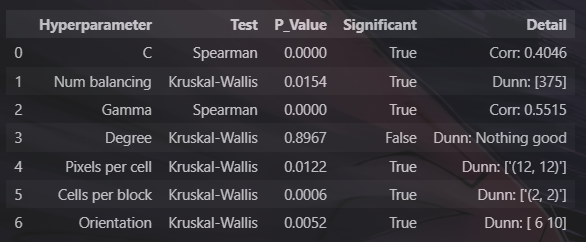

In [ ]:
# a.start(C=1000, 
#         kernel="poly", 
#         gamma=0.1, 
#         degree=3, 
#         num_of_balancing=375, 
#         orientations=10, 
#         pixels_per_cell=(12,12),
#         cells_per_block=(2, 2)
#     )

K-Fold Cross Validation: 100%|██████████| 4/4 [31:52<00:00, 478.11s/it]


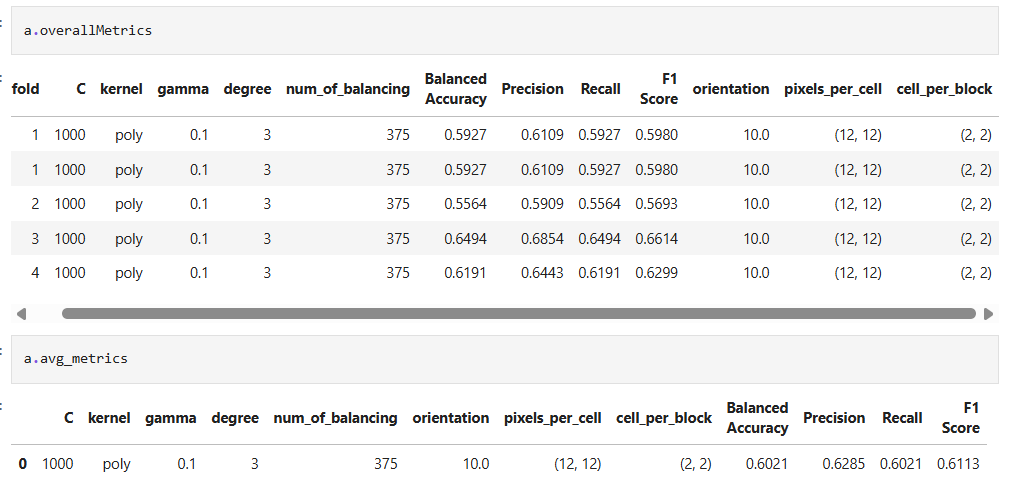


Yeah, not even close LOL.

# CNN

## Basic visualization and Statistical Test

In [2]:
cnn_all_df = pd.read_csv("!CNN_RESULT/CNN_overallMetrics.csv")
cnn_all_df = cnn_all_df.drop(["fold", "Epoch", "conv2d_filters"], axis=1)
# cnn_all_df["conv2d_filters"] = list(map(lambda x: sum(ast.literal_eval(x)), cnn_all_df["conv2d_filters"].values))

### No Filter

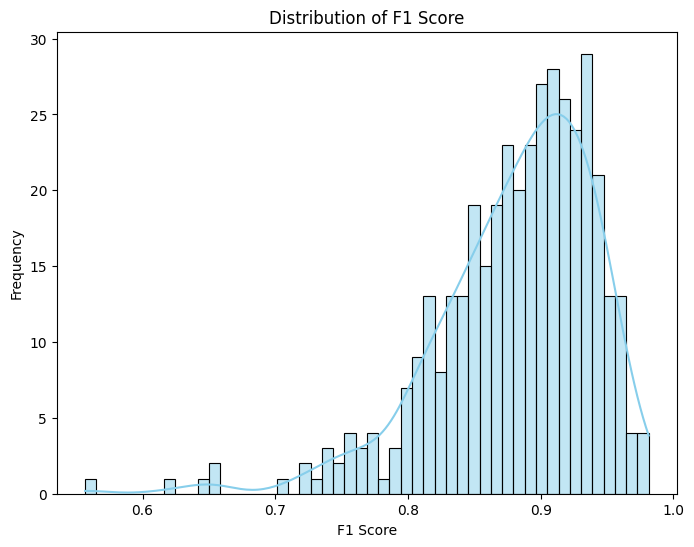

H0: The data is normally distributed
H1: The data is not normally distributed

Shapiro-Wilk Test: Statistics=0.9153, p-value=0.0000
Reject H0


In [3]:
# Example why parametric test is not suitable

# F1 Score distribution
plt.figure(figsize=(8,6))
sns.histplot(cnn_all_df["F1 Score"], bins=50, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of F1 Score")
plt.xlabel("F1 Score")
plt.ylabel("Frequency")
plt.show()

# Normality test using Ben Shapiro test on hogsvm_all_df
stat, p_value = stats.shapiro(cnn_all_df["F1 Score"])

print("H0: The data is normally distributed")
print("H1: The data is not normally distributed")

print(f'\nShapiro-Wilk Test: Statistics={stat:.4f}, p-value={p_value:.4f}')
print("Reject H0" if p_value < 0.05 else "Fail to Reject H0")

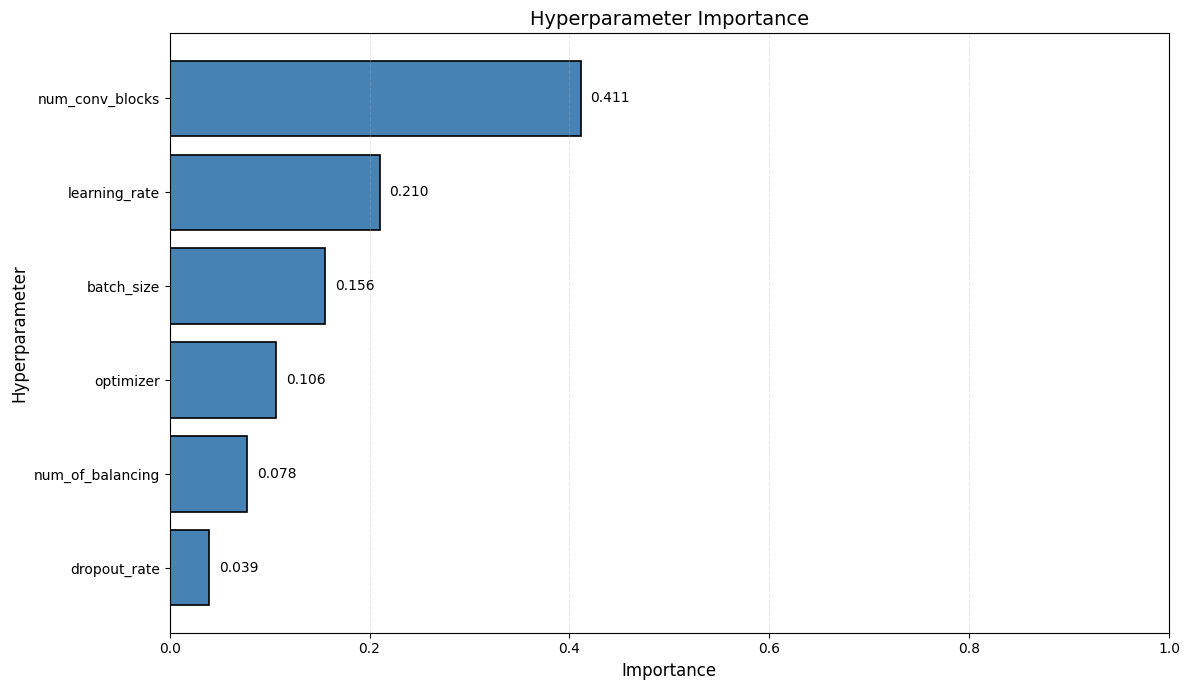

In [4]:
X = cnn_all_df.drop(columns=["Balanced Accuracy", "Precision", "Recall", "F1 Score"])
y = cnn_all_df["F1 Score"]


X[["num_of_balancing", "dropout_rate", "batch_size", "learning_rate", "num_conv_blocks"]] = X[["num_of_balancing", "dropout_rate", "batch_size", "learning_rate", "num_conv_blocks"]].astype(float)
X[["num_of_balancing", "dropout_rate", "batch_size", "learning_rate", "num_conv_blocks"]] = StandardScaler().fit_transform(X[["num_of_balancing", "dropout_rate", "batch_size", "learning_rate", "num_conv_blocks"]])

optimizer_map = {optimizer: i for i, optimizer in enumerate(X["optimizer"].unique())}
X["optimizer"] = X["optimizer"].map(optimizer_map)


# Extra Trees Regressor as the model for hyperparameter importance
et = ExtraTreesRegressor(n_estimators=500)
et.fit(X, y)

# cross validate the model
result = permutation_importance(et, X, y, n_repeats=10)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance_df['Normalized'] = importance_df['Importance'] / importance_df['Importance'].sum()


plt.figure(figsize=(12, 7))
bars = plt.barh(importance_df['Feature'], importance_df['Normalized'], color='steelblue', edgecolor='black', linewidth=1.2)
for i, (bar, value) in enumerate(zip(bars, importance_df['Normalized'])):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Hyperparameter', fontsize=12)
plt.title('Hyperparameter Importance', fontsize=14)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [5]:
importance_df

Feature  Importance  Normalized
1      dropout_rate    0.058467    0.039114
0  num_of_balancing    0.116060    0.077642
4         optimizer    0.158983    0.106357
2        batch_size    0.232651    0.155640
3     learning_rate    0.314040    0.210087
5   num_conv_blocks    0.614608    0.411162

### Optimizer

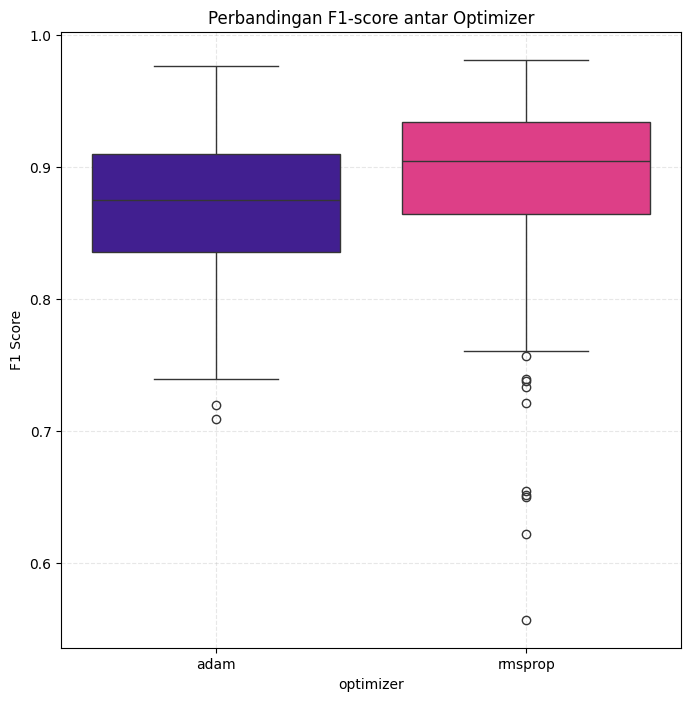

In [252]:
# Kernel BOXPLOT
thecolors = {
    "adam": "#3A0CA3",      # Ungu janda
    "rmsprop": "#F72585",   # Pink flowery
}
plt.figure(figsize=(8,8))
sns.boxplot(x="optimizer", y="F1 Score", data=cnn_all_df, palette=thecolors)
plt.title("Perbandingan F1-score antar Optimizer")
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [254]:
kruskal_optimizer = kruskal_walis_test(cnn_all_df, groupby='optimizer', y='F1 Score')
print(kruskal_optimizer)

   H-statistic   p-value Significance
0    20.705416  0.000005  Significant


In [255]:
dunn_optimizer =costum_dunn_test(cnn_all_df, group='optimizer', val_y='F1 Score', tail='right', alpha=0.05)


Z-table value: 1.6449

Dunn's Test Z-values:


adam  rmsprop
adam         0.0  -4.5503
rmsprop  4.5503*   0.0000


Score-based Ranking from Dunn's Test:


Group  Score  rank
1  rmsprop      1   1.0
0     adam      0   2.0

## RMSProp

In [256]:
rmsprop_df = cnn_all_df[cnn_all_df["optimizer"] == "rmsprop"].copy()
rmsprop_df = rmsprop_df.drop(columns= "optimizer")

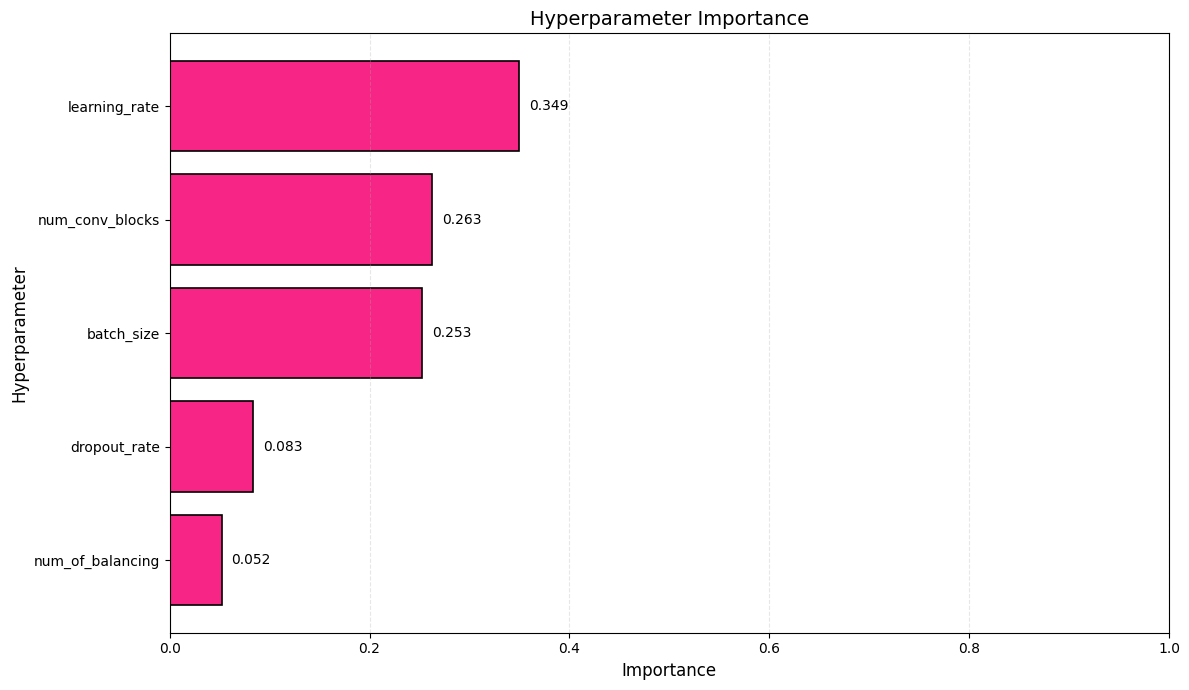

In [257]:
X = rmsprop_df.drop(columns=["Balanced Accuracy", "Precision", "Recall", "F1 Score"])
y = rmsprop_df["F1 Score"]


X[["num_of_balancing", "dropout_rate", "batch_size", "learning_rate", "num_conv_blocks"]] = X[["num_of_balancing", "dropout_rate", "batch_size", "learning_rate", "num_conv_blocks"]].astype(float)
X[["num_of_balancing", "dropout_rate", "batch_size", "learning_rate", "num_conv_blocks"]] = StandardScaler().fit_transform(X[["num_of_balancing", "dropout_rate", "batch_size", "learning_rate", "num_conv_blocks"]])

# Extra Trees Regressor as the model for hyperparameter importance
et = ExtraTreesRegressor(n_estimators=500)
et.fit(X, y)

# cross validate the model
result = permutation_importance(et, X, y, n_repeats=10)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance_df['Normalized'] = importance_df['Importance'] / importance_df['Importance'].sum()


plt.figure(figsize=(12, 7))
bars = plt.barh(importance_df['Feature'], importance_df['Normalized'], color='#F72585', edgecolor='black', linewidth=1.2)
for i, (bar, value) in enumerate(zip(bars, importance_df['Normalized'])):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Hyperparameter', fontsize=12)
plt.title('Hyperparameter Importance', fontsize=14)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### Learning Rate

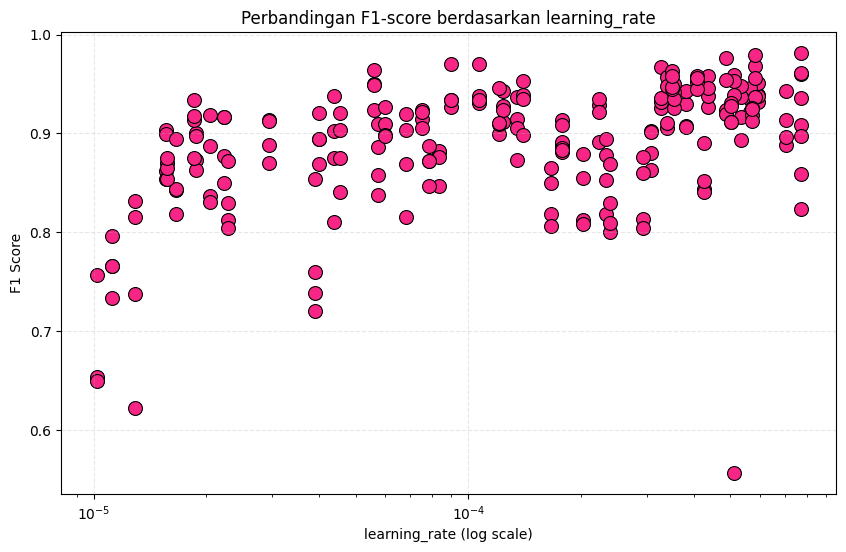

In [258]:
# Plot LR vs F1 Score for RMSProp

plt.figure(figsize=(10,6))
sns.scatterplot(x="learning_rate", y="F1 Score", data=rmsprop_df, color='#F72585', s=100, edgecolor='black')
plt.xscale('log')
plt.title("Perbandingan F1-score berdasarkan learning_rate")
plt.xlabel("learning_rate (log scale)")
plt.ylabel("F1 Score")
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [259]:
'''
Factor 1: RMSProp
Factor 2: Learning_Rate
Y: F1 Score
'''
# Learning Rate spearman Correlation Test
corr_lr_rmsprop, pvalue_lr_rmsprop = stats.spearmanr(rmsprop_df["learning_rate"], rmsprop_df["F1 Score"])
print(f'Significant: {pvalue_lr_rmsprop < 0.05}\nP-value: {pvalue_lr_rmsprop:.4f}\nCorrelation Coefficient: {corr_lr_rmsprop:.4f}')

Significant: True
P-value: 0.0000
Correlation Coefficient: 0.5107


### Num of Blocks

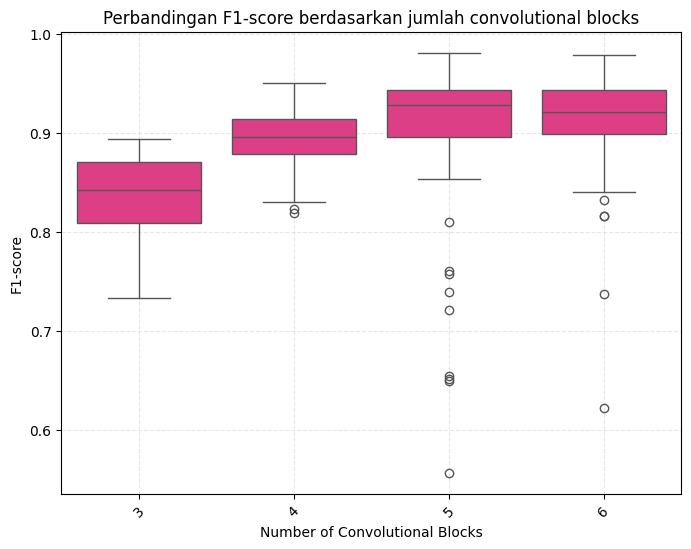

In [260]:
# Plot Num of blocks vs F1 Score for RMSProp
plt.figure(figsize=(8,6))
sns.boxplot(x="num_conv_blocks", y="F1 Score", data=rmsprop_df, color='#F72585')
plt.title("Perbandingan F1-score berdasarkan jumlah convolutional blocks")
plt.xlabel("Number of Convolutional Blocks")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [261]:
'''
Factor 1: RMSProp
Factor 2: num_conv_blocks
Y: F1 Score
'''
# kruskal the PMO test and Dunn test
kruskal_numblock_rmsprop = kruskal_walis_test(rmsprop_df, groupby='num_conv_blocks', y='F1 Score')
print(kruskal_numblock_rmsprop)
if kruskal_numblock_rmsprop["Significance"][0] == "Significant":
    dunn_numblock_rmsprop = costum_dunn_test(rmsprop_df, group='num_conv_blocks', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic       p-value Significance
0    61.177568  3.293280e-13  Significant

Z-table value: 2.3940

Dunn's Test Z-values:


3        4       5       6
3      0.0  -4.5882 -6.8503 -7.1236
4  4.5882*      0.0 -2.7174 -2.9423
5  6.8503*  2.7174*  0.0000 -0.1361
6  7.1236*  2.9423*  0.1361  0.0000


Score-based Ranking from Dunn's Test:


Group  Score  rank
3      6      2   1.0
2      5      2   1.0
1      4      1   3.0
0      3      0   4.0

### Num Balancing

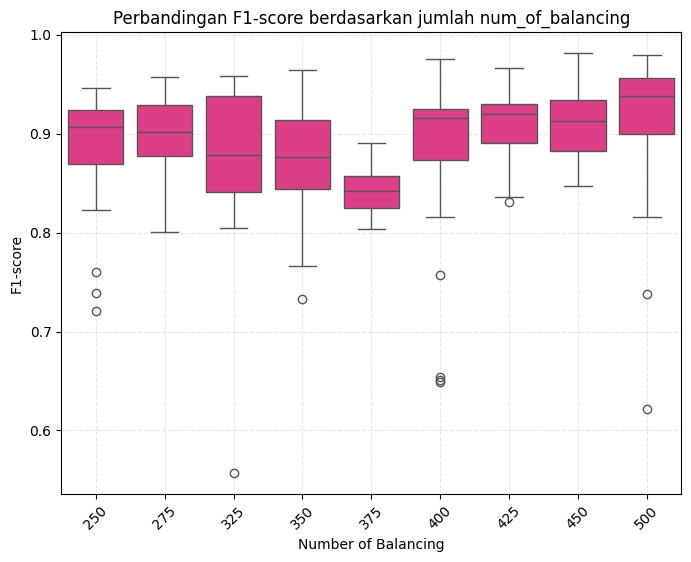

In [262]:
# Plot Num of balancing vs F1 Score for RMSProp
plt.figure(figsize=(8,6))
sns.boxplot(x="num_of_balancing", y="F1 Score", data=rmsprop_df, color='#F72585')
plt.title("Perbandingan F1-score berdasarkan jumlah num_of_balancing")
plt.xlabel("Number of Balancing")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [263]:
'''
Factor 1: RMSProp
Factor 2: num_of_balancing
Y: F1 Score
'''
# kruskal the fuck out test and Dunn test
kruskal_numbalancing_rmsprop = kruskal_walis_test(rmsprop_df, groupby='num_of_balancing', y='F1 Score')
print(kruskal_numbalancing_rmsprop)
if kruskal_numbalancing_rmsprop["Significance"][0] == "Significant":
    dunn_numbalancing_rmsprop = costum_dunn_test(rmsprop_df, group='num_of_balancing', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value Significance
0    29.142371  0.000299  Significant

Z-table value: 2.9913

Dunn's Test Z-values:


250     275     325      350      375     400     425     450     500
250  0.0000 -0.2755  0.2670   1.4434    2.623 -0.5431 -0.7725 -1.3094 -2.9004
275  0.2755  0.0000  0.4626   1.4227   2.5875 -0.1947 -0.4509 -0.8521 -2.1412
325 -0.2670 -0.4626  0.0000   0.8885   2.2378 -0.6944 -0.8870 -1.3353 -2.6409
350 -1.4434 -1.4227 -0.8885      0.0   1.7889 -1.8126 -1.8284 -2.5081 -4.1253
375 -2.6230 -2.5875 -2.2378  -1.7889      0.0 -2.8423 -2.8490 -3.2833 -4.2638
400  0.5431  0.1947  0.6944   1.8126   2.8423  0.0000 -0.3006 -0.7224 -2.1322
425  0.7725  0.4509  0.8870   1.8284    2.849  0.3006  0.0000 -0.3308 -1.5178
450  1.3094  0.8521  1.3353   2.5081  3.2833*  0.7224  0.3308  0.0000 -1.3261
500  2.9004  2.1412  2.6409  4.1253*  4.2638*  2.1322  1.5178  1.3261  0.0000


Score-based Ranking from Dunn's Test:


Group  Score  rank
8    500      2   1.0
7    450      1   2.0
2    325      0   3.0
0    250      0   3.0
3    350      0   3.0
4    375      0   3.0
5    400      0   3.0
1    275      0   3.0
6    425      0   3.0

### Dropout Rate

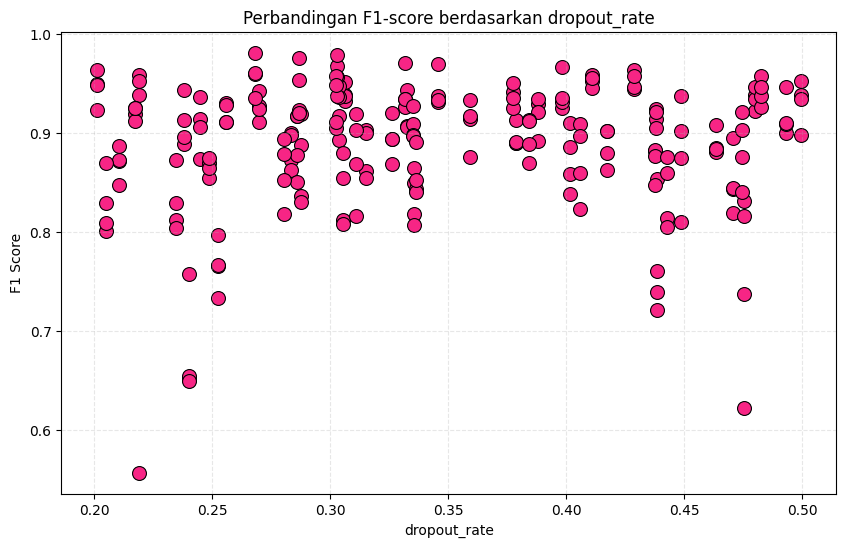

In [264]:
# Plot dropout rate vs F1 Score for RMSProp

plt.figure(figsize=(10,6))
sns.scatterplot(x="dropout_rate", y="F1 Score", data=rmsprop_df, color='#F72585', s=100, edgecolor='black')
plt.title("Perbandingan F1-score berdasarkan dropout_rate")
plt.xlabel("dropout_rate")
plt.ylabel("F1 Score")
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [265]:
'''
Factor 1: RMSProp
Factor 2: dropout_rate
Y: F1 Score
'''
# dropout_rate spearman Correlation Test
corr_dropout_rmsprop, pvalue_dropout_rmsprop = stats.spearmanr(rmsprop_df["dropout_rate"], rmsprop_df["F1 Score"])
print(f'Significant: {pvalue_dropout_rmsprop < 0.05}\nP-value: {pvalue_dropout_rmsprop:.4f}\nCorrelation Coefficient: {corr_dropout_rmsprop:.4f}')

Significant: False
P-value: 0.4990
Correlation Coefficient: 0.0450


### Batch Size

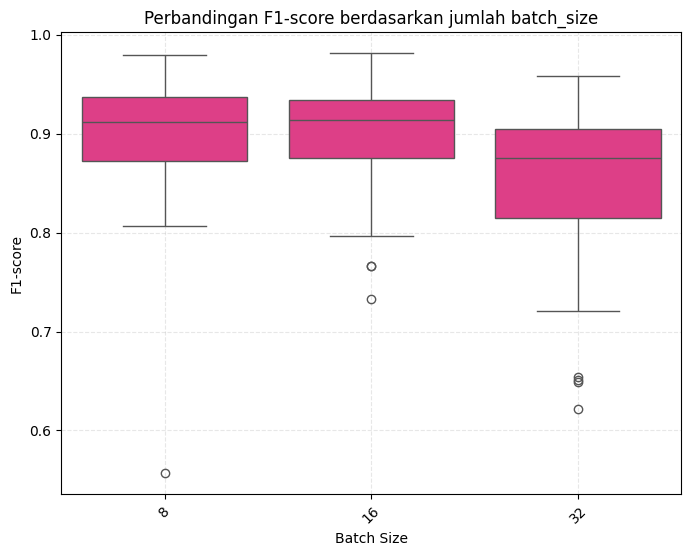

In [266]:
# Plot batch_size vs F1 Score for RMSProp
plt.figure(figsize=(8,6))
sns.boxplot(x="batch_size", y="F1 Score", data=rmsprop_df, color='#F72585')
plt.title("Perbandingan F1-score berdasarkan jumlah batch_size")
plt.xlabel("Batch Size")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [267]:
'''
Factor 1: RMSProp
Factor 2: batch_size
Y: F1 Score
'''
# kruskal the fuck out test and Dunn test
kruskal_batchsize_rmsprop = kruskal_walis_test(rmsprop_df, groupby='batch_size', y='F1 Score')
print(kruskal_batchsize_rmsprop)
if kruskal_batchsize_rmsprop["Significance"][0] == "Significant":
    dunn_batchsize_rmsprop = costum_dunn_test(rmsprop_df, group='batch_size', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value Significance
0    17.821317  0.000135  Significant

Z-table value: 2.1280

Dunn's Test Z-values:


8       16       32
8   0.0000  0.3405  3.8052*
16 -0.3405  0.0000  3.7467*
32 -3.8052 -3.7467      0.0


Score-based Ranking from Dunn's Test:


Group  Score  rank
0      8      1   1.0
1     16      1   1.0
2     32      0   3.0

## Adam

In [268]:
adam_df = cnn_all_df[cnn_all_df["optimizer"] == "adam"].copy()
adam_df = adam_df.drop(columns= "optimizer")

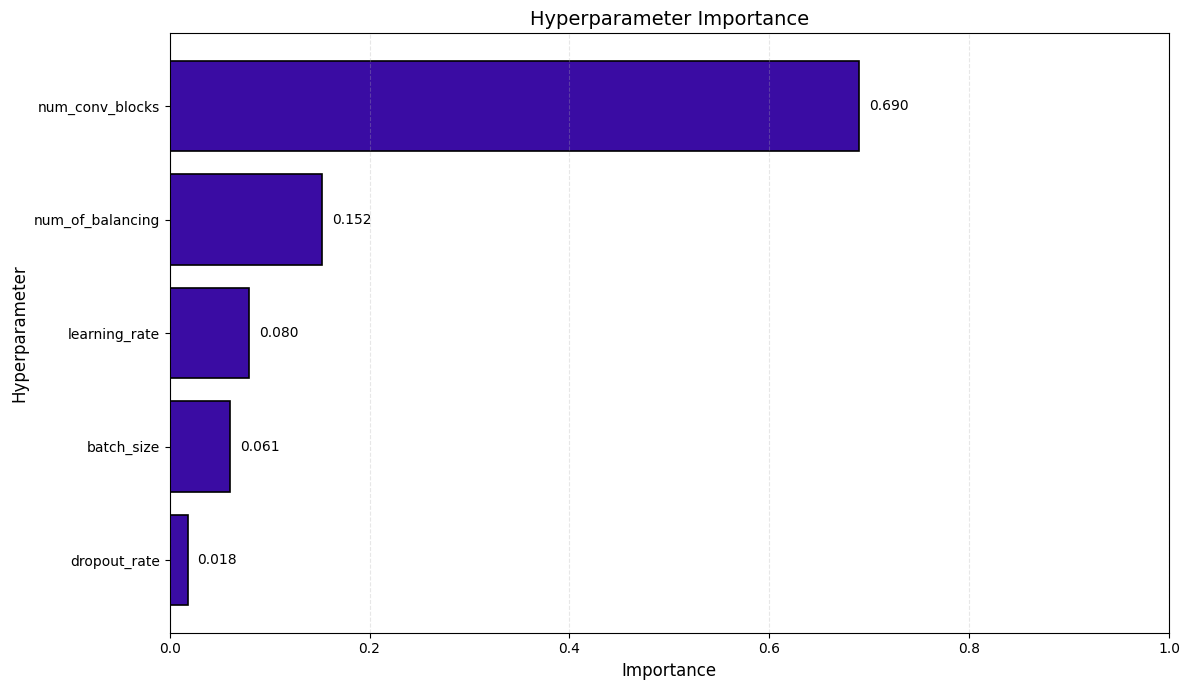

In [269]:
X = adam_df.drop(columns=["Balanced Accuracy", "Precision", "Recall", "F1 Score"])
y = adam_df["F1 Score"]


X[["num_of_balancing", "dropout_rate", "batch_size", "learning_rate", "num_conv_blocks"]] = X[["num_of_balancing", "dropout_rate", "batch_size", "learning_rate", "num_conv_blocks"]].astype(float)
X[["num_of_balancing", "dropout_rate", "batch_size", "learning_rate", "num_conv_blocks"]] = StandardScaler().fit_transform(X[["num_of_balancing", "dropout_rate", "batch_size", "learning_rate", "num_conv_blocks"]])

# Extra Trees Regressor as the model for hyperparameter importance
et = ExtraTreesRegressor(n_estimators=500)
et.fit(X, y)

# cross validate the model
result = permutation_importance(et, X, y, n_repeats=10)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance_df['Normalized'] = importance_df['Importance'] / importance_df['Importance'].sum()


plt.figure(figsize=(12, 7))
bars = plt.barh(importance_df['Feature'], importance_df['Normalized'], color='#3A0CA3', edgecolor='black', linewidth=1.2)
for i, (bar, value) in enumerate(zip(bars, importance_df['Normalized'])):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Hyperparameter', fontsize=12)
plt.title('Hyperparameter Importance', fontsize=14)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### Learning Rate

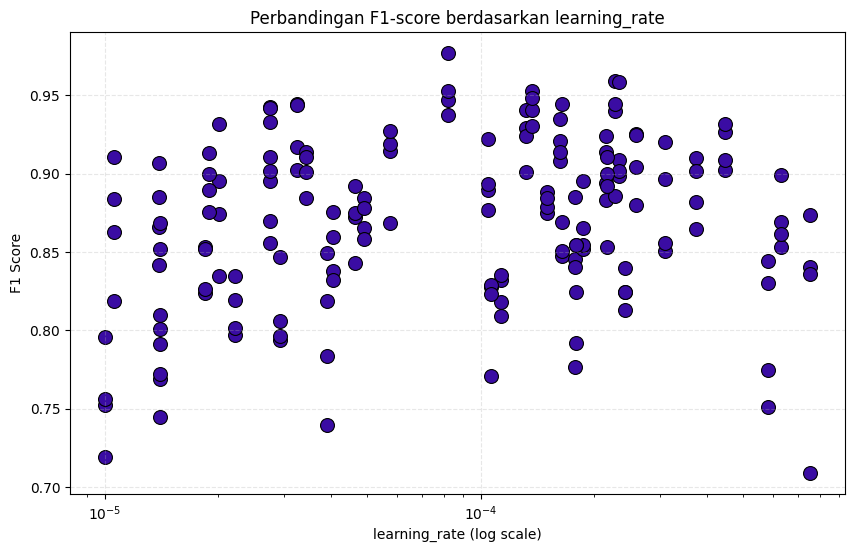

In [270]:
# Plot LR vs F1 Score for Adam

plt.figure(figsize=(10,6))
sns.scatterplot(x="learning_rate", y="F1 Score", data=adam_df, color='#3A0CA3', s=100, edgecolor='black')
plt.xscale('log')
plt.title("Perbandingan F1-score berdasarkan learning_rate")
plt.xlabel("learning_rate (log scale)")
plt.ylabel("F1 Score")
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [271]:
'''
Factor 1: Adam
Factor 2: Learning_Rate
Y: F1 Score
'''
# Learning Rate spearman Correlation Test
corr_lr_adam, pvalue_lr_adam = stats.spearmanr(adam_df["learning_rate"], adam_df["F1 Score"])
print(f'Significant: {pvalue_lr_adam < 0.05}\nP-value: {pvalue_lr_adam:.4f}\nCorrelation Coefficient: {corr_lr_adam:.4f}')

Significant: True
P-value: 0.0163
Correlation Coefficient: 0.1830


### Num of Blocks

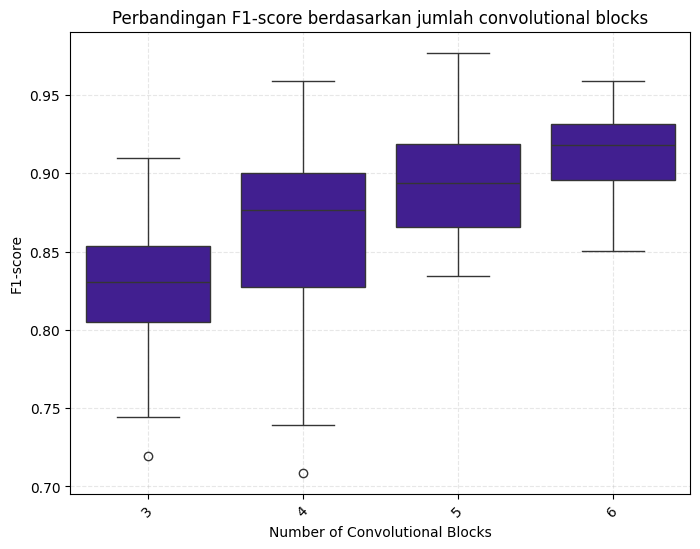

In [272]:
# Plot Num of blocks vs F1 Score for Adam
plt.figure(figsize=(8,6))
sns.boxplot(x="num_conv_blocks", y="F1 Score", data=adam_df, color='#3A0CA3')
plt.title("Perbandingan F1-score berdasarkan jumlah convolutional blocks")
plt.xlabel("Number of Convolutional Blocks")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [273]:
'''
Factor 1: adam
Factor 2: num_conv_blocks
Y: F1 Score
'''
# kruskal the PMO test and Dunn test
kruskal_numblock_adam = kruskal_walis_test(adam_df, groupby='num_conv_blocks', y='F1 Score')
print(kruskal_numblock_adam)
if kruskal_numblock_adam["Significance"][0] == "Significant":
    dunn_numblock_adam = costum_dunn_test(adam_df, group='num_conv_blocks', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic       p-value Significance
0    73.628211  7.129877e-16  Significant

Z-table value: 2.3940

Dunn's Test Z-values:


3        4       5       6
3      0.0  -3.3378 -5.7389 -8.1111
4  3.3378*      0.0 -2.4944 -4.6787
5  5.7389*  2.4944*  0.0000 -2.0092
6  8.1111*  4.6787*  2.0092  0.0000


Score-based Ranking from Dunn's Test:


Group  Score  rank
3      6      2   1.0
2      5      2   1.0
1      4      1   3.0
0      3      0   4.0

### Num Balancing

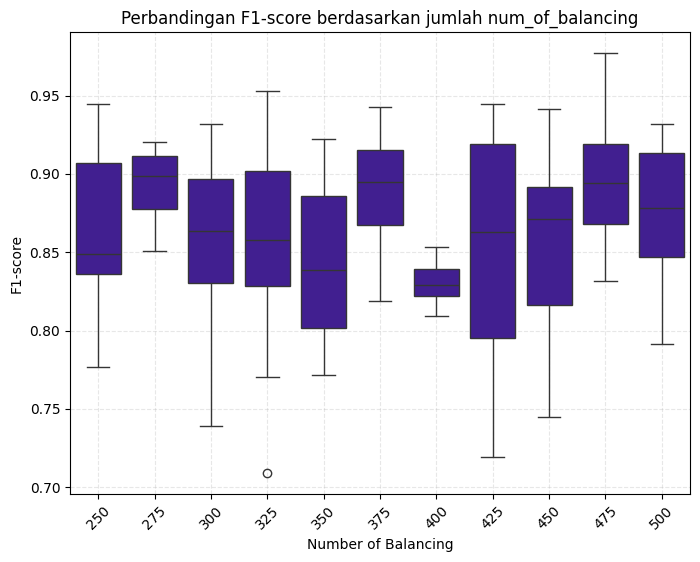

In [274]:
# Plot Num of balancing vs F1 Score for Adam
plt.figure(figsize=(8,6))
sns.boxplot(x="num_of_balancing", y="F1 Score", data=adam_df, color='#3A0CA3')
plt.title("Perbandingan F1-score berdasarkan jumlah num_of_balancing")
plt.xlabel("Number of Balancing")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [275]:
'''
Factor 1: Adam
Factor 2: num_of_balancing
Y: F1 Score
'''
# kruskal the fuck out test and Dunn test
kruskal_numbalancing_adam = kruskal_walis_test(adam_df, groupby='num_of_balancing', y='F1 Score')
print(kruskal_numbalancing_adam)
if kruskal_numbalancing_adam["Significance"][0] == "Significant":
    dunn_numbalancing_adam = costum_dunn_test(adam_df, group='num_of_balancing', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value Significance
0    27.648944  0.002054  Significant

Z-table value: 3.1184

Dunn's Test Z-values:


250     275     300     325      350     375      400     425     450  \
250  0.0000 -1.3145  0.2394  0.0515   1.0686 -1.7882   1.8304  0.1154  0.2716   
275  1.3145  0.0000  1.4473  1.3565    2.187 -0.0195   2.7236  1.4087  1.5362   
300 -0.2394 -1.4473  0.0000 -0.1917   0.7499 -1.8910   1.5362 -0.1326  0.0121   
325 -0.0515 -1.3565  0.1917  0.0000   1.0171 -1.8446   1.7884  0.0639  0.2201   
350 -1.0686 -2.1870 -0.7499 -1.0171      0.0 -2.9588    0.958 -0.9532 -0.7970   
375  1.7882  0.0195  1.8910  1.8446   2.9588  0.0000  3.3552*  1.9146  2.0857   
400 -1.8304 -2.7236 -1.5362 -1.7884   -0.958 -3.3552      0.0 -1.7362 -1.6087   
425 -0.1154 -1.4087  0.1326 -0.0639   0.9532 -1.9146   1.7362  0.0000  0.1562   
450 -0.2716 -1.5362 -0.0121 -0.2201    0.797 -2.0857   1.6087 -0.1562  0.0000   
475  2.0383  0.1389  2.1138  2.0978  3.2722*  0.1739   3.584*  2.1715  2.3519   
500  0.5406 -0.6702  0.7131  0.5826    1.413 -0.8403   2.0534  0.6348  0.7623   

        475     500  
250 -2.0383 -0.5406  
275 -0.1389  0.6702  
300 -2.1138 -0.7131  
325 -2.0978 -0.5826  
350 -3.2722 -1.4130  
375 -0.1739  0.8403  
400 -3.5840 -2.0534  
425 -2.1715 -0.6348  
450 -2.3519 -0.7623  
475  0.0000  0.9867  
500 -0.9867  0.0000


Score-based Ranking from Dunn's Test:


Group  Score  rank
9     475      2   1.0
5     375      1   2.0
2     300      0   3.0
0     250      0   3.0
3     325      0   3.0
4     350      0   3.0
6     400      0   3.0
1     275      0   3.0
7     425      0   3.0
8     450      0   3.0
10    500      0   3.0

### Dropout Rate

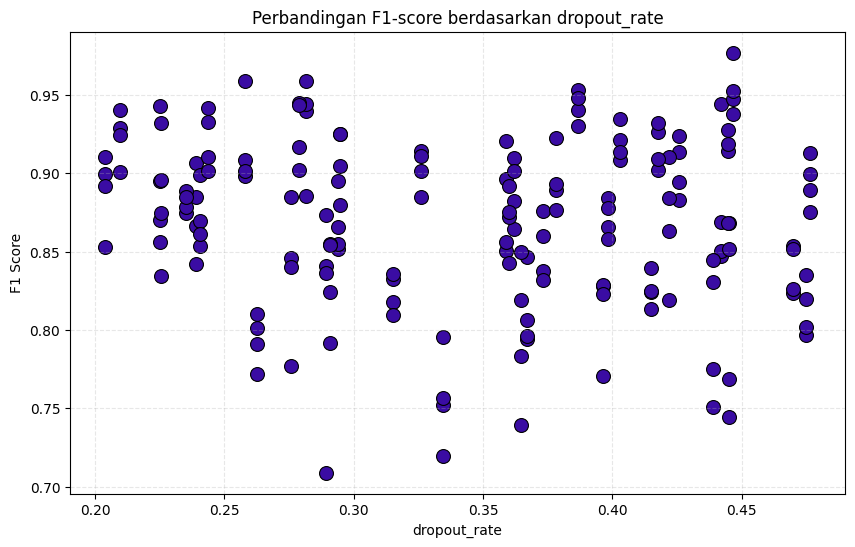

In [276]:
# Plot dropout rate vs F1 Score for Adam

plt.figure(figsize=(10,6))
sns.scatterplot(x="dropout_rate", y="F1 Score", data=adam_df, color='#3A0CA3', s=100, edgecolor='black')
plt.title("Perbandingan F1-score berdasarkan dropout_rate")
plt.xlabel("dropout_rate")
plt.ylabel("F1 Score")
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [277]:
'''
Factor 1: Adam
Factor 2: dropout_rate
Y: F1 Score
'''
# dropout_rate spearman Correlation Test
corr_dropout_adam, pvalue_dropout_adam = stats.spearmanr(adam_df["dropout_rate"], adam_df["F1 Score"])
print(f'Significant: {pvalue_dropout_adam < 0.05}\nP-value: {pvalue_dropout_adam:.4f}\nCorrelation Coefficient: {corr_dropout_adam:.4f}')

Significant: False
P-value: 0.1342
Correlation Coefficient: -0.1147


### Batch Size

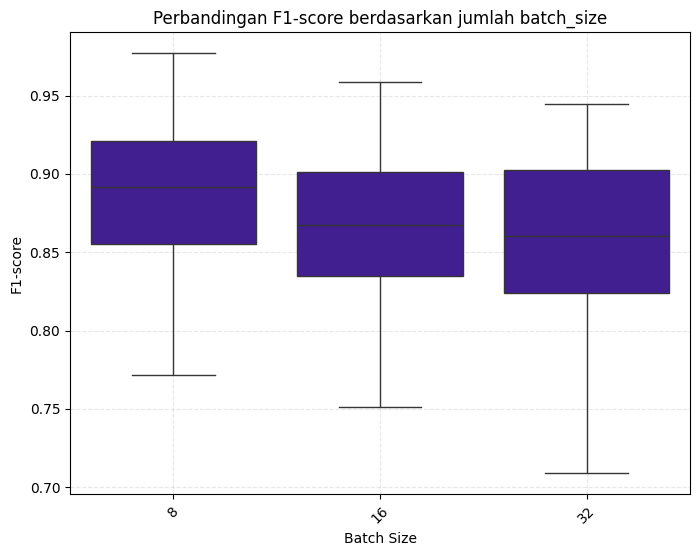

In [278]:
# Plot batch_size vs F1 Score for Adam
plt.figure(figsize=(8,6))
sns.boxplot(x="batch_size", y="F1 Score", data=adam_df, color='#3A0CA3')
plt.title("Perbandingan F1-score berdasarkan jumlah batch_size")
plt.xlabel("Batch Size")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

In [279]:
'''
Factor 1: Adam
Factor 2: batch_size
Y: F1 Score
'''
# kruskal the fuck out test and Dunn test
kruskal_batchsize_adam = kruskal_walis_test(adam_df, groupby='batch_size', y='F1 Score')
print(kruskal_batchsize_adam)
if kruskal_batchsize_adam["Significance"][0] == "Significant":
    dunn_batchsize_adam = costum_dunn_test(adam_df, group='batch_size', val_y='F1 Score', tail='right', alpha=0.05, simple=False)

   H-statistic   p-value Significance
0     9.400823  0.009092  Significant

Z-table value: 2.1280

Dunn's Test Z-values:


8       16       32
8   0.0000  2.0437  2.9363*
16 -2.0437  0.0000   0.5167
32 -2.9363 -0.5167      0.0


Score-based Ranking from Dunn's Test:


Group  Score  rank
0      8      1   1.0
1     16      0   2.0
2     32      0   2.0

## Summary

In [280]:
results_summary_rmsprop = pd.DataFrame({
    'Hyperparameter': [
        'Learning Rate', 'Num of Blocks', 'Num Balancing', 'Dropout Rate', 'Batch Size'
    ],
    'Test': ['Spearman', 'Kruskal-Wallis', 'Kruskal-Wallis', 'Spearman', 'Kruskal-Wallis'],
    'P_Value': [round(pvalue_lr_rmsprop, 4), round(kruskal_numblock_rmsprop["p-value"][0], 4), round(kruskal_numbalancing_rmsprop["p-value"][0], 4), round(pvalue_dropout_rmsprop, 4), round(kruskal_batchsize_rmsprop["p-value"][0], 4)],
    'Significant': [pvalue_lr_rmsprop < 0.05, kruskal_numblock_rmsprop["p-value"][0] < 0.05, kruskal_numbalancing_rmsprop["p-value"][0] < 0.05, pvalue_dropout_rmsprop < 0.05, kruskal_batchsize_rmsprop["p-value"][0] < 0.05],
    'Detail': [f'Corr: {round(corr_lr_rmsprop, 4)}',
               f'Dunn: {dunn_numblock_rmsprop[dunn_numblock_rmsprop["rank"] == dunn_numblock_rmsprop["rank"].unique()[0]]["Group"].values if kruskal_numblock_rmsprop["Significance"][0] == "Significant" else "Nothing good"}',
               f'Dunn: {dunn_numbalancing_rmsprop[dunn_numbalancing_rmsprop["rank"] == dunn_numbalancing_rmsprop["rank"].unique()[0]]["Group"].values if kruskal_numbalancing_rmsprop["Significance"][0] == "Significant" else "Nothing good"}',
               f'Corr: {round(corr_dropout_rmsprop, 4)}',
               f'Dunn: {dunn_batchsize_rmsprop[dunn_batchsize_rmsprop["rank"] == dunn_batchsize_rmsprop["rank"].unique()[0]]["Group"].values if kruskal_batchsize_rmsprop["Significance"][0] == "Significant" else "Nothing good"}',]
})

In [281]:
results_summary_adam = pd.DataFrame({
        'Hyperparameter': [
        'Learning Rate', 'Num of Blocks', 'Num Balancing', 'Dropout Rate', 'Batch Size'
    ],
    'Test': ['Spearman', 'Kruskal-Wallis', 'Kruskal-Wallis', 'Spearman', 'Kruskal-Wallis'],
    'P_Value': [round(pvalue_lr_adam, 4), round(kruskal_numblock_adam["p-value"][0], 4), round(kruskal_numbalancing_adam["p-value"][0], 4), round(pvalue_dropout_adam, 4), round(kruskal_batchsize_adam["p-value"][0], 4)],
    'Significant': [pvalue_lr_adam < 0.05, kruskal_numblock_adam["p-value"][0] < 0.05, kruskal_numbalancing_adam["p-value"][0] < 0.05, pvalue_dropout_adam < 0.05, kruskal_batchsize_adam["p-value"][0] < 0.05],
    'Detail': [f'Corr: {round(corr_lr_adam, 4)}',
                f'Dunn: {dunn_numblock_adam[dunn_numblock_adam["rank"] == dunn_numblock_adam["rank"].unique()[0]]["Group"].values if kruskal_numblock_adam["Significance"][0] == "Significant" else "Nothing good"}',
                f'Dunn: {dunn_numbalancing_adam[dunn_numbalancing_adam["rank"] == dunn_numbalancing_adam["rank"].unique()[0]]["Group"].values if kruskal_numbalancing_adam["Significance"][0] == "Significant" else "Nothing good"}',
                f'Corr: {round(corr_dropout_adam, 4)}',
                f'Dunn: {dunn_batchsize_adam[dunn_batchsize_adam["rank"] == dunn_batchsize_adam["rank"].unique()[0]]["Group"].values if kruskal_batchsize_adam["Significance"][0] == "Significant" else "Nothing good"}',]
})

In [282]:
print("\nKernel:")
display(kruskal_optimizer)
display(dunn_optimizer)

print(f'\n{"="*100}')
print("\nRMSProp")

display(results_summary_rmsprop)

print("\nAdam")
display(results_summary_adam)


Kernel:


H-statistic   p-value Significance
0    20.705416  0.000005  Significant

Group  Score  rank
1  rmsprop      1   1.0
0     adam      0   2.0



RMSProp


Hyperparameter            Test  P_Value  Significant         Detail
0  Learning Rate        Spearman   0.0000         True   Corr: 0.5107
1  Num of Blocks  Kruskal-Wallis   0.0000         True    Dunn: [6 5]
2  Num Balancing  Kruskal-Wallis   0.0003         True    Dunn: [500]
3   Dropout Rate        Spearman   0.4990        False    Corr: 0.045
4     Batch Size  Kruskal-Wallis   0.0001         True  Dunn: [ 8 16]


Adam


Hyperparameter            Test  P_Value  Significant         Detail
0  Learning Rate        Spearman   0.0163         True    Corr: 0.183
1  Num of Blocks  Kruskal-Wallis   0.0000         True    Dunn: [6 5]
2  Num Balancing  Kruskal-Wallis   0.0021         True    Dunn: [475]
3   Dropout Rate        Spearman   0.1342        False  Corr: -0.1147
4     Batch Size  Kruskal-Wallis   0.0091         True      Dunn: [8]